In [11]:
## Basic
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import time
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
#sys.path.append("../../package/")
#cm =1/2.54
#fig = fig_pre_def(6,4.5,1)# 圖片大小
#ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格
#fig_post_def()

from scipy.optimize import curve_fit,fmin
from scipy.optimize import least_squares
import numpy
import pylab

# Function

In [12]:
cm =1/2.54
def fig_pre_def(fx=8, fy=6,lw=1,dpi = 200):
    cm =1/2.54
    plt.rcParams['figure.dpi'] = dpi
    plt.rc('font', family='Helvetica')         # 自型
    plt.rcParams['axes.linewidth'] = lw     # 設置外框的寬度
    return  plt.figure(figsize=(fx*cm,fy*cm))   
    ax = fig.add_subplot(1, 1, 1)
def fig_post_def(xticks =(None,None),yticks =(None,None), 
                 xlim=(None,None),ylim=(None,None),
                 xlabel = None,ylabel=None,
                 title=None,
                 lg_fs = 6,lb_fs = 8, n_col =1,
                 unit = 1/2.54, SVG = False,onefig=True):
    if xticks[0] != None:
        # Edit the major and minor tick locations 設定格線 不指定將由程式自行設定
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xticks[0]))    
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xticks[1]))    
    if yticks[0] != None:
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yticks[0]))
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(yticks[1]))
    #plt.rc('xtick', labelsize=fontsize)          # X軸數字的文字大小
    #plt.rc('ytick', labelsize=fontsize)          # Y軸數字的文字大小
    ax.tick_params(axis='x', labelsize= lb_fs)
    ax.tick_params(axis='y', labelsize= lb_fs)
    ax.xaxis.set_tick_params(which='major', size=10*unit, width=1, direction='in', top='on')    # x軸主要格線
    ax.xaxis.set_tick_params(which='minor', size=7*unit, width=1, direction='in', top='on')     # x軸次要格線
    ax.yaxis.set_tick_params(which='major', size=10*unit, width=1, direction='in', right='on')   # y軸主要格線
    ax.yaxis.set_tick_params(which='minor', size=7*unit, width=1, direction='in', right='on')   # y軸次要格線
    new_rc_params = {'text.usetex': False,
        "svg.fonttype": 'none'
        }
    plt.rcParams['axes.linewidth'] = 1     # 設置外框的寬度
    mpl.rcParams.update(new_rc_params)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    if xlabel != None:
        ax.set_xlabel(xlabel,fontsize=lb_fs)
    if ylabel != None:
        ax.set_ylabel(ylabel,fontsize=lb_fs)

    if SVG == True:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

        new_rc_params = {'text.usetex': False,
        "svg.fonttype": 'none'
        }
        plt.rcParams['axes.linewidth'] = 1     # 設置外框的寬度
        mpl.rcParams.update(new_rc_params)
    if onefig ==True:
        plt.gca().set_position([0, 0, 1, 1])


    plt.legend(fontsize=lg_fs,title=title,title_fontsize=lg_fs,frameon= False,ncol=n_col)
    plt.rcParams['figure.dpi'] = 80

#cm =1/2.54
#fig = fig_pre_def(6,4.5,1)# 圖片大小
#ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格
#plt.scatter(x,y, alpha=0.6,linewidth=0,s=30*cm,label=' ')
#plt.plot(x,y     ,'--ob',markersize=8*cm,linewidth=3*cm,mew=0,label='point source')
#fig_post_def()

def sorting(input_data, bin_number , lower_range, upper_range):
    hist, edges = np.histogram( #hist 每格裡面統計的數量 edges:每一格的邊界
    input_data, #要分析的矩陣
    bins=bin_number, 
    range=(lower_range, upper_range), #範圍
    density=False) #是否Normalized成百分比
    Bin_center = []
    for i in range(len(edges)-1):
        Bin_center_single = round((edges[i]+edges[i+1])/2,2)
        Bin_center = np.append(Bin_center,Bin_center_single)
    
    return Bin_center, hist
def interpolation_function(data_x,data_y,new_x):
    new_y = interp1d(data_x, data_y,fill_value="extrapolate")(new_x)
    return new_y

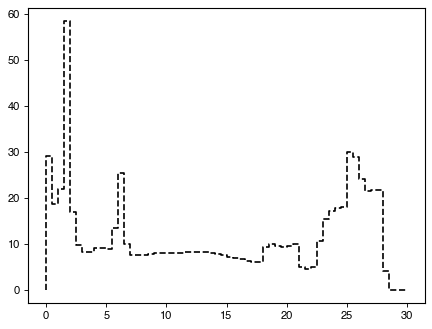

In [117]:
INER_QMN = np.loadtxt("INER_QMN_30MeV.txt")
INER_QMN_bar_x,INER_QMN_bar_y = bar_plot(INER_QMN[:,0], INER_QMN[:,1] ,0.5)
plt.plot(0.25+INER_QMN_bar_x,30*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5cm')

# Calculate TOF energy uncertainty


In [13]:
def energy_to_time_gTOF_modified(E,d):
    distance = d/100 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    core = (1+(E*10**6*1.6*10**-19/(neutron_mass*light_speed**2)))
    speed = ((1-core**-2)*light_speed**2)**0.5
    TOF= (distance/speed)*10**9
    return TOF

def E_resolution_gTOF_modified(E,delta_T,d,dd):
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    gamma = 1+(E*(1.6*10**-19)*(10**6)/(neutron_mass*light_speed**2))
    #print(gamma)
    #delta_T = 5 # ns
    TOF = energy_to_time_gTOF_modified(E,d)
    delta_E = E*gamma*(gamma+1)*(((0.0847**2)**0.5/TOF)**2+((1.006**2)**0.5/TOF)**2+((delta_T**2)**0.5/TOF)**2+(dd/d)**2)**0.5
    return delta_E


In [14]:
plot_Ep = np.arange(0,150,0.01)

/var/folders/qd/hhwc9gc95fv6tx8vycl4f3bm0000gn/T/ipykernel_22115/1133975486.py:7: RuntimeWarning: divide by zero encountered in divide
  TOF= (distance/speed)*10**9
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


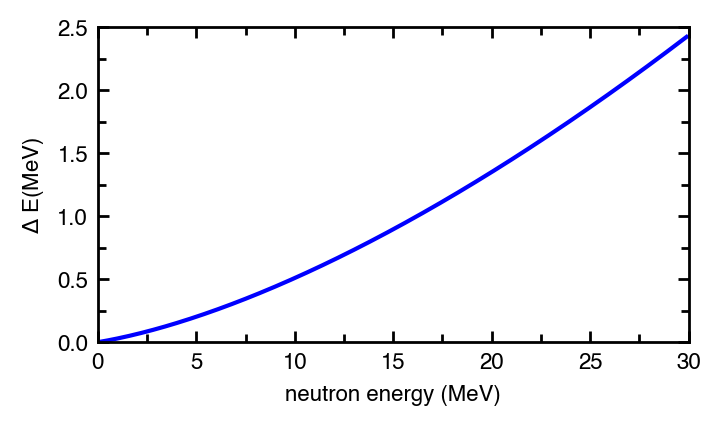

In [15]:
# 150 MeV
fig = fig_pre_def(7.5,4) #定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111

plot_Ep = np.arange(0,30,0.1)

E_resolution = E_resolution_gTOF_modified(plot_Ep, 1.02,294,3.86)
ax.plot(plot_Ep,E_resolution,'b')#,label ='TOF')

fig_post_def(xlim=(0,30),xticks=(5,2.5)
             ,ylim=(0,2.5),yticks=(0.5,0.25)
             ,lg_fs=8
             #,title=r'150 cm $\Delta t = 1.5 ns$'
             ,xlabel ='neutron energy (MeV)'
             ,ylabel = r'$\Delta$ E(MeV)'#,title=r"energy resolution $\Delta$ E")
)
plt.savefig('/Users/thlin/Library/CloudStorage/Dropbox/Research/Publication/2024 ABNS/Figure/Python_export/E_resolution.svg', format="svg")


# Read File

## neutron response

In [16]:
neutron_response= np.loadtxt("../response/N_response_17_30MeV.txt")

## Experimental data

In [463]:
folder = "../../data/INER/INER_TOF/"
#folder = "../../../data/NSTOF_experiment_data/"

#raw_data_1  =np.loadtxt(folder+"20230411_AmBe_10hours.txt")
raw_data_1  =np.loadtxt(folder+"20230413_INER_Neutron_TOF_CFD2ns100_5mins.txt")
#raw_data_1  =np.loadtxt(folder+"20230413_INER_TOF_CFD_10mins.txt") # low current 
#raw_data_1  =np.loadtxt(folder+"20230413_INER_low_current_TOF_CFD_10min.txt")
#raw_data_1   =np.loadtxt(folder+"20230413_INER_TOF_CFD_1A_10min.txt")
#raw_data_1   =np.loadtxt(folder+"20230413_INER_TOF_CFD_2A_20min.txt")

raw_data = np.zeros(shape=6)
print(raw_data)
for i in range(1,2):
    #print(i)
    add = globals()["raw_data_"+str(i)]  # convert string to variable name
    print(add.shape)
    raw_data=np.vstack((raw_data,add))

#raw_data = pd.DataFrame(raw_data,columns=["time_diff","Rec_PSD","Rec_LO_ch","Tri_Det","Tri_PSD","Tri_LO_ch"])
#raw_data = pd.DataFrame(raw_data,columns=["time_diff","Rec_PSD","Rec_LO_ch","Tri_Det","Tri_LO_ch"])
raw_data = raw_data[1:,:]
print(raw_data)
print(len(raw_data))
print(raw_data.shape)

[0. 0. 0. 0. 0. 0.]
(313930, 6)
[[2.88741e+02 3.57513e-01 3.86000e+02 6.00000e+00 2.24439e-02 4.01000e+02]
 [2.78165e+02 3.65314e-01 5.42000e+02 4.00000e+00 3.72197e-01 2.23000e+02]
 [1.92340e+02 4.60648e-01 4.32000e+02 6.00000e+00 3.02831e-01 2.57900e+03]
 ...
 [1.30950e+01 3.19682e-01 1.63600e+03 4.00000e+00 3.28554e-01 1.67400e+03]
 [1.00742e+02 3.65023e-01 8.52000e+02 6.00000e+00 3.18519e-01 2.70000e+02]
 [2.54140e+01 4.62798e-01 6.72000e+02 4.00000e+00 3.34734e-01 7.14000e+02]]
313930
(313930, 6)


# Processing  

In [464]:
source_to_main_detector= 2.94 #m
source_to_trigger_detector= 0.2 #m

## Light output convertion

In [465]:
#Rec_Ch_To_LO        = 0.00273 #0.00301#0.00273#0.002285 #0.00414 #
#Rec_Ch_To_LO_offset = -0.0696  #-0.1263#-0.0696 #0.019369 #-0.3544#

Rec_Ch_To_LO        =  0.00213#0.00238
Rec_Ch_To_LO_offset =  0.079  #0.0
#Rec_Ch_To_LO        = 0.0016#*(1650/1500)
#Rec_Ch_To_LO_offset = 0.01643#*(1650/1500)

Tri_Ch_To_LO = 0.0003625*4#0.000317
Tri_Ch_To_LO_offset = 0.015225*4
raw_data_LO = raw_data.copy()
raw_data_LO[:,2] = raw_data[:,2]*Rec_Ch_To_LO+Rec_Ch_To_LO_offset
#raw_data_LO[:,2] = raw_data[:,2]*Rec_Ch_To_LO
raw_data_LO[:,5] = raw_data[:,5]*Tri_Ch_To_LO+Tri_Ch_To_LO_offset
raw_data = pd.DataFrame(raw_data_LO,columns=["time_diff","Rec_PSD","Rec_LO","Tri_Det","Tri_PSD","Tri_LO"])
print(raw_data.head())
#neutron_signal[:,0] = neutron_signal[:,0]

   time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD    Tri_LO
0    288.741  0.357513   0.90118      6.0  0.022444   0.64235
1    278.165  0.365314   1.23346      4.0  0.372197   0.38425
2    192.340  0.460648   0.99916      6.0  0.302831   3.80045
3     67.556  0.338262   3.53599      4.0  0.404312  10.48640
4     75.051  0.396496  17.09770      4.0  0.306701   0.62350


## PSD selection

In [466]:
#Signal processing
print(raw_data.shape)
mask_Tri_Ch4        = raw_data['Tri_Det']==4
mask_Rec_LO         = raw_data['Rec_LO']>0
mask_Rec_PSD_upper  = raw_data['Rec_PSD'] < 0.6
mask_Rec_PSD_lower  = raw_data['Rec_PSD'] > 0.38
mask_Tri_n_PSD_upper  = raw_data['Tri_PSD'] < 0.6
mask_Tri_n_PSD_lower  = raw_data['Tri_PSD'] > 0.38
mask_Tri_g_PSD_upper  = raw_data['Tri_PSD'] < 0.36
mask_Tri_g_PSD_lower  = raw_data['Tri_PSD'] > 0.2

#filter neutron in recording detector
pro_data = raw_data[(
                    #mask_Tri_Ch4 
                    mask_Rec_LO
                    & mask_Rec_PSD_upper
                    & mask_Rec_PSD_lower 
                    )] 

print(pro_data.shape)
print(pro_data.head())
#not filter neutron in recording detector
# just for time delay correction
pro_data_all = raw_data[(#mask_Tri_Ch4 
                        mask_Rec_LO)]



(313930, 6)
(158777, 6)
   time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD   Tri_LO
2    192.340  0.460648   0.99916      6.0  0.302831  3.80045
4     75.051  0.396496  17.09770      4.0  0.306701  0.62350
7    287.040  0.400336   5.14414      4.0  0.306376  1.92560
8     90.958  0.459610   0.84367      6.0  0.291294  1.84295
9    166.547  0.446194   1.70206      4.0  0.478673  0.67280


# gamma trigger

In [467]:
print(pro_data_all.head())

mask_Rec_LO           = pro_data_all['Rec_LO']<16000*Rec_Ch_To_LO
mask_Rec_PSD_upper    = pro_data_all['Rec_PSD'] < 0.6
mask_Rec_PSD_lower    = pro_data_all['Rec_PSD'] > 0.38
mask_Tri_g_PSD_upper  = pro_data_all['Tri_PSD'] < 0.38
mask_Tri_g_PSD_lower  = pro_data_all['Tri_PSD'] > 0.2


# trigger by the gamma at the trigger detector
pro_g_data_delay = pro_data_all[(mask_Rec_LO 
                        #&mask_Tri_g_PSD_upper
                        #&mask_Tri_g_PSD_lower
                         )]


   time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD    Tri_LO
0    288.741  0.357513   0.90118      6.0  0.022444   0.64235
1    278.165  0.365314   1.23346      4.0  0.372197   0.38425
2    192.340  0.460648   0.99916      6.0  0.302831   3.80045
3     67.556  0.338262   3.53599      4.0  0.404312  10.48640
4     75.051  0.396496  17.09770      4.0  0.306701   0.62350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


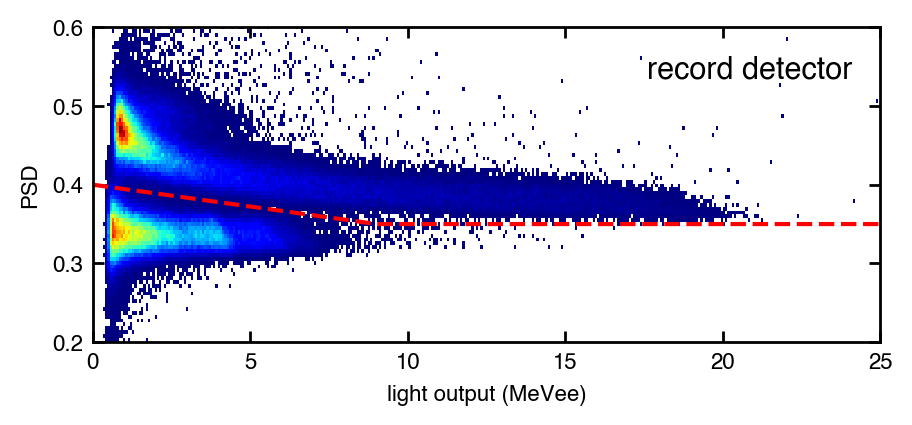

In [468]:
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(pro_g_data_delay['Rec_LO'],pro_g_data_delay['Rec_PSD'], bins=(400, 200),cmin=1, cmap=plt.cm.jet)
#ax.axhline(y=0.35, color='r', linestyle='-')
#ax.axvline(x=6, color='r', linestyle='-')
Fed_cut_x = np.arange(0,25,0.01)
Fed_cut_y = Fed_cut_x*-0.00556+ 0.4
Fed_cut_y[900:]=0.35
plt.plot(Fed_cut_x,Fed_cut_y,'--r')

fig_post_def(xlim =(0,25),ylim = (0.2,0.6),xlabel = 'light output (MeVee)',ylabel = 'PSD',
             title='record detector', lg_fs = 11)


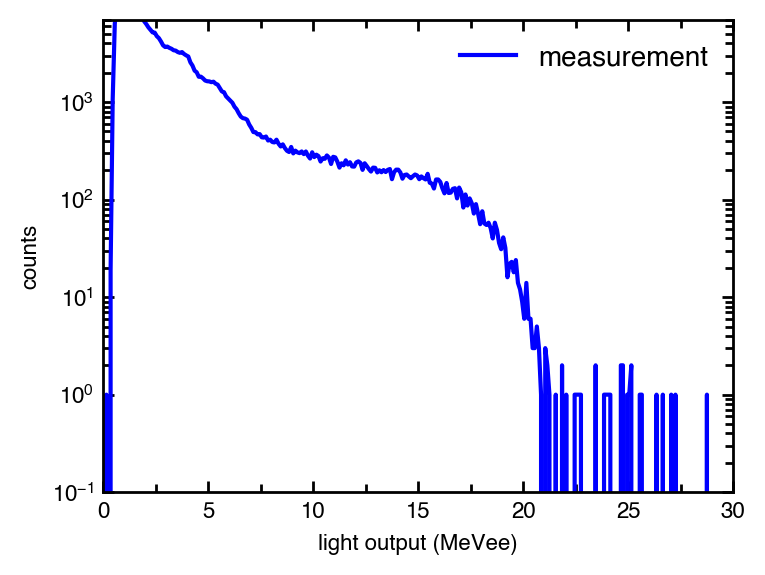

In [469]:
fig = fig_pre_def(8,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

response_x, response_y = sorting(pro_g_data_delay['Rec_LO'],300,0,30)
plt.plot(response_x, response_y,'b',label='measurement')

plt.yscale('log')

fig_post_def(xlim =(0,30),xticks=(5,2.5),ylim = (0.1,7000)
             ,lg_fs = 10
             ,xlabel = 'light output (MeVee)',ylabel = 'counts')


In [470]:
QMN_response = np.hstack((response_x[:,np.newaxis],response_y[:,np.newaxis]))
print(QMN_response.shape)
np.savetxt('../../data/30MeV_QMN_response/20240906_QMN_response.txt',QMN_response)

(300, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


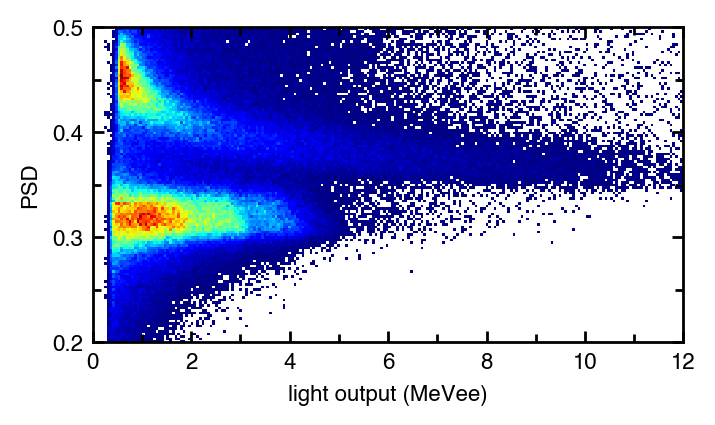

In [478]:
fig = fig_pre_def(7.5,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(pro_g_data_delay['Tri_LO'],pro_g_data_delay['Tri_PSD'], bins=(400, 200),cmin=1, cmap=plt.cm.jet)
#ax.axhline(y=0.35, color='r', linestyle='-')
#ax.axvline(x=6, color='r', linestyle='-')
Tri_Fed_cut_x = np.arange(0,25,0.01)
Tri_Fed_cut_y = Fed_cut_x*-0.00556+ 0.4-0.02
Tri_Fed_cut_y[900:]=0.35-0.02
plt.plot(Tri_Fed_cut_x,Tri_Fed_cut_y,'--r',label= 'fiducial cut')

fig_post_def(xlim =(0,12),xticks=(2,1)
             ,ylim = (0.2,0.5),yticks=(0.1,0.05),xlabel = 'light output (MeVee)',ylabel = 'PSD'
             #title='trigger detector'
             #,SVG=True
             ,lg_fs = 9)
plt.legend(loc='lower right',frameon =False,fontsize = 9)

#plt.axis('off')
#plt.savefig('INER_TOF_PSD_LO.png', format="png")
#plt.savefig('/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_TOF_PSD_LO.svg', format="svg")

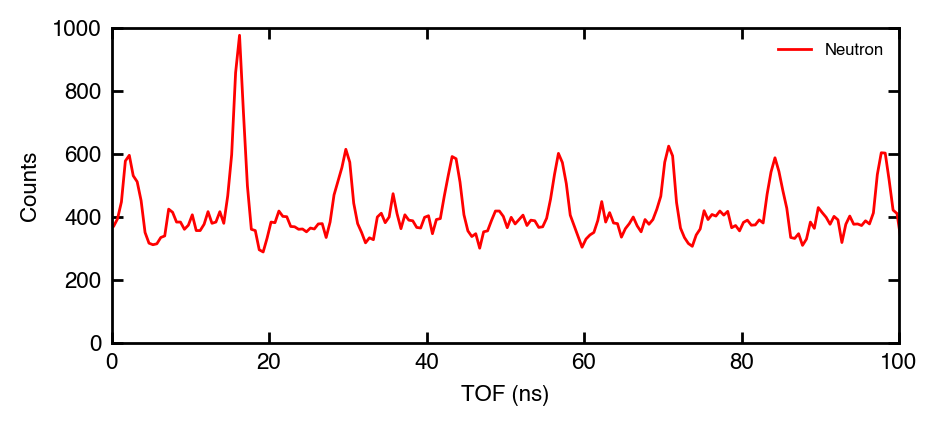

In [378]:
bin_center,hist_gamma = sorting(pro_g_data_delay['time_diff'],1200,-200,400)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_gamma,'r' ,linewidth=1,label ='Neutron')
fig_post_def(xlim =(-0,100),ylim = (0,1000),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(0,5500)
#plt.yscale('log')

In [379]:
g_max_position = np.argmax(hist_gamma[0:1000])
g_measured_gamma_time_diff= bin_center[g_max_position]
print('measured gamma different time: ',g_measured_gamma_time_diff,' ns')

measured gamma different time:  16.25  ns


In [380]:
light_speed = 299792468 #m/s
nano_second = 10**(-9)  #s
g_experimental_gamma_different= ((source_to_main_detector#+1.5*0.0254
                                  -source_to_trigger_detector)/light_speed)/nano_second
print(g_experimental_gamma_different)

9.13965590356326


In [381]:
g_system_delay = g_measured_gamma_time_diff - g_experimental_gamma_different
print('system_delay  ',g_system_delay, '  ns')

#g_system_delay = 4.74653

system_delay   7.110344096436741   ns


In [382]:
source_to_trigger_detector=0.2
light_speed = 299792468 #m/s
nano_second = 10**(-9)  #s
gamma_to_trigger= ((source_to_trigger_detector)/light_speed)/nano_second
print(gamma_to_trigger)

0.6671281681433037


In [383]:
pro_T_data = pro_data_all.copy(deep=True)
pro_T_data["TOF"] = pro_T_data["time_diff"].apply(lambda x:x-g_system_delay+gamma_to_trigger)
print(pro_T_data.head())

   time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD    Tri_LO         TOF
0    288.741  0.357513   0.90118      6.0  0.022444   0.64235  282.297784
1    278.165  0.365314   1.23346      4.0  0.372197   0.38425  271.721784
2    192.340  0.460648   0.99916      6.0  0.302831   3.80045  185.896784
3     67.556  0.338262   3.53599      4.0  0.404312  10.48640   61.112784
4     75.051  0.396496  17.09770      4.0  0.306701   0.62350   68.607784


In [384]:
def n_Time_to_energy(TOF):
    distance = source_to_main_detector#+1.5*0.0254 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    neutron_energy = 0.5*neutron_mass*(distance/(TOF*10**-9))**2/((1.6*10**-19)*(10**6))
    return neutron_energy

def Time_to_energy(TOF):
    distance = source_to_main_detector#+1.5*0.0254 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg

    if type(TOF).__module__ == np.__name__:
        #print(type(TOF))
        if TOF.any()==0:
            return 0
        else:
            beta= distance/(light_speed*TOF*10**-9)
            neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
            return neutron_energy
    else:
        beta= distance/(light_speed*TOF*10**-9)
        neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
        return neutron_energy

def n_energy_to_time(E):
    distance = 2.94 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    TOF = distance/((2*E*(1.6*10**-19)*(10**6)/neutron_mass)**0.5)*10**9 #ns
    return TOF
def energy_to_time(E):
    distance = 2.94 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    core = (1+(E*10**6*1.6*10**-19/(neutron_mass*light_speed**2)))
    speed = ((1-core**-2)*light_speed**2)**0.5
    TOF= (distance/speed)*10**9
    return TOF
def n_energy_to_speed(E):
    neutron_mass = 1.64749*10**-27 #kg
    speed = ((2*E*(1.6*10**-19)*(10**6)/neutron_mass)**0.5)/10**9 #ns
    return speed #m
def energy_to_speed(E):
    distance = 2.94 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    core = (1+(E*10**6*1.6*10**-19/(neutron_mass*light_speed**2)))
    speed = ((1-core**-2)*light_speed**2)**0.5/10**9
    return speed

In [385]:
RF_T = 10**9*1/(73.129*10**6)
print("RF time period: ",RF_T)

RF time period:  13.674465670253936


In [386]:
print(Time_to_energy(39.44))
print(n_Time_to_energy(39.44))

30.00725336677126
28.608405778322982


In [387]:
print(n_energy_to_speed(30))
print(n_energy_to_speed(20))
print(n_energy_to_speed(10))
print(0.05/n_energy_to_speed(10))

0.07633509016942637
0.0623273401281463
0.044072084857932674
1.1345049856655542


In [388]:
print(n_energy_to_speed(10))
print(energy_to_speed(30))

0.044072084857932674
0.07453502277296906


In [389]:
print(energy_to_time(5))
print(energy_to_time(30))
print(39.44+13.674)
print(Time_to_energy(39.44+13.674))
print(Time_to_energy(39.44))

94.72247565480548
39.444544197096874
53.114
16.189403407882196
30.00725336677126


In [390]:
print(Time_to_energy(53.11))
print(n_Time_to_energy(40))
print(Time_to_energy(40)/n_Time_to_energy(40))

16.19190649903519
27.812977664062497
1.0474647855155335


In [391]:
print(energy_to_speed(20)*100)
print(energy_to_speed(30)*100)
print(energy_to_time(16.7))
print(energy_to_time(17))
slow_E=16.616
fast_E=30
print("over time",energy_to_speed(slow_E)*100*13/(energy_to_speed(fast_E)*100-energy_to_speed(slow_E)*100))
print("fast arrived time", 294/(energy_to_speed(fast_E)*100))
print("the minimum energy can be resolved for due to the exceed:  ", energy_to_time(slow_E))

6.133758296933391
7.453502277296906
52.31693020569679
51.865601372912444
over time 39.44162213115755
fast arrived time 39.444544197096874
the minimum energy can be resolved for due to the exceed:   52.44550731309359


In [392]:
resolution_time =0.002 #ns

proE_data = pro_T_data.copy()
proE_data['Rec_E'] = Time_to_energy(np.round(proE_data['TOF']/resolution_time)*resolution_time  )
print(proE_data)


        time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD    Tri_LO  \
0         288.741  0.357513   0.90118      6.0  0.022444   0.64235   
1         278.165  0.365314   1.23346      4.0  0.372197   0.38425   
2         192.340  0.460648   0.99916      6.0  0.302831   3.80045   
3          67.556  0.338262   3.53599      4.0  0.404312  10.48640   
4          75.051  0.396496  17.09770      4.0  0.306701   0.62350   
...           ...       ...       ...      ...       ...       ...   
313925    120.173  0.341986   1.96618      6.0  0.453125   0.98890   
313926     21.211  0.443586   1.45711      6.0  0.466667   1.88790   
313927     13.095  0.319682   3.56368      4.0  0.328554   2.48820   
313928    100.742  0.365023   1.89376      6.0  0.318519   0.45240   
313929     25.414  0.462798   1.51036      4.0  0.334734   1.09620   

               TOF       Rec_E  
0       282.297784    0.558914  
1       271.721784    0.603313  
2       185.896784    1.290432  
3        61.112784   12.150

In [393]:
Rec_Fed_cut_x = np.arange(0,50,0.01)
Rec_Fed_cut_y = Rec_Fed_cut_x*-0.00556+ 0.4
Rec_Fed_cut_y[900:]=0.35

def Rec_GN_discrimination(LO,PSD): 
    global Rec_Fed_cut_x,Rec_Fed_cut_y
    LO_int = np.round(LO*100,0).astype(int)
    corresponded_PSD = Rec_Fed_cut_y[LO_int]
    #print(corresponded_PSD)
    output=[]
    for i in np.arange(0,len(corresponded_PSD),1):
        if PSD[i] >corresponded_PSD[i]: # neutron 
            output = np.append(output,2)
        else: #gamma
            output = np.append(output,1)
    return output


Tri_Fed_cut_x = np.arange(0,50,0.01)
Tri_Fed_cut_y = Tri_Fed_cut_x*-0.00556+ 0.4-0.02
Tri_Fed_cut_y[900:]=0.35-0.02


def Tri_GN_discrimination(LO,PSD): 
    global Tri_Fed_cut_x,Tri_Fed_cut_y
    LO_int = np.round(LO*100,0).astype(int)
    corresponded_PSD = Tri_Fed_cut_y[LO_int]
    #print(corresponded_PSD)
    output=[]
    for i in np.arange(0,len(corresponded_PSD),1):
        if PSD[i] >corresponded_PSD[i]: # neutron 
            output = np.append(output,2)
        else: #gamma
            output = np.append(output,1)
    return output

In [394]:

Rec_P = Rec_GN_discrimination(proE_data['Rec_LO'].values, proE_data['Rec_PSD'].values)
Tri_P = Tri_GN_discrimination(proE_data['Tri_LO'].values, proE_data['Tri_PSD'].values)


In [395]:
print(Rec_P[:5])
print(Tri_P[:5])

[1. 1. 2. 1. 2.]
[1. 1. 1. 2. 1.]


In [396]:
pd_Tri_p=pd.DataFrame(Tri_P, columns=["Tri_p"])
pd_Rec_p=pd.DataFrame(Rec_P, columns=["Rec_p"])
proE_GN_data1 = pd.concat([proE_data, pd_Tri_p], axis=1)
proE_GN_data  = pd.concat([proE_GN_data1, pd_Rec_p], axis=1)
print(proE_GN_data)

        time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD    Tri_LO  \
0         288.741  0.357513   0.90118      6.0  0.022444   0.64235   
1         278.165  0.365314   1.23346      4.0  0.372197   0.38425   
2         192.340  0.460648   0.99916      6.0  0.302831   3.80045   
3          67.556  0.338262   3.53599      4.0  0.404312  10.48640   
4          75.051  0.396496  17.09770      4.0  0.306701   0.62350   
...           ...       ...       ...      ...       ...       ...   
313925    120.173  0.341986   1.96618      6.0  0.453125   0.98890   
313926     21.211  0.443586   1.45711      6.0  0.466667   1.88790   
313927     13.095  0.319682   3.56368      4.0  0.328554   2.48820   
313928    100.742  0.365023   1.89376      6.0  0.318519   0.45240   
313929     25.414  0.462798   1.51036      4.0  0.334734   1.09620   

               TOF       Rec_E  Tri_p  Rec_p  
0       282.297784    0.558914    1.0    1.0  
1       271.721784    0.603313    1.0    1.0  
2       185.896784

In [397]:
mask_Rec_n  = proE_GN_data['Rec_p'] == 2
mask_Rec_g  = proE_GN_data['Rec_p'] == 1
mask_Tri_n  = proE_GN_data['Tri_p'] == 2
mask_Tri_g  = proE_GN_data['Tri_p'] == 1

maks_LO_limit = proE_GN_data['Rec_LO']>0

In [398]:
tri_n_rec_n_data   = proE_GN_data[(mask_Tri_n & mask_Rec_n)]
tri_g_rec_g_data   = proE_GN_data[(mask_Tri_g & mask_Rec_g)]
tri_g_rec_n_data   = proE_GN_data[(mask_Tri_g & mask_Rec_n)]
tri_n_rec_g_data   = proE_GN_data[(mask_Tri_n & mask_Rec_g)]
tri_g_rec_All_data = proE_GN_data[(mask_Tri_g)]
tri_n_rec_All_data = proE_GN_data[(mask_Tri_n)]

tri_g_rec_n_LO_data   = proE_GN_data[(maks_LO_limit & mask_Tri_g & mask_Rec_n)]

hist_bin   = 1600
hist_lower = -400
hist_upper = 400

bin_center, hist_all           = sorting(proE_GN_data['TOF'],hist_bin,hist_lower,hist_upper)
#bin_center, hist_tri_All_rec_n       = sorting(pro_data['time_diff'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_n       = sorting(tri_n_rec_n_data['TOF'],hist_bin,hist_lower,hist_upper)

bin_center, hist_tri_g_rec_g   = sorting(tri_g_rec_g_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_g_rec_n   = sorting(tri_g_rec_n_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_g   = sorting(tri_n_rec_g_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_g_rec_all = sorting(tri_g_rec_All_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_all = sorting(tri_n_rec_All_data['TOF'],hist_bin,hist_lower,hist_upper)


bin_center, hist_tri_g_rec_n_LO = sorting(tri_g_rec_n_LO_data['TOF'],hist_bin,hist_lower,hist_upper)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


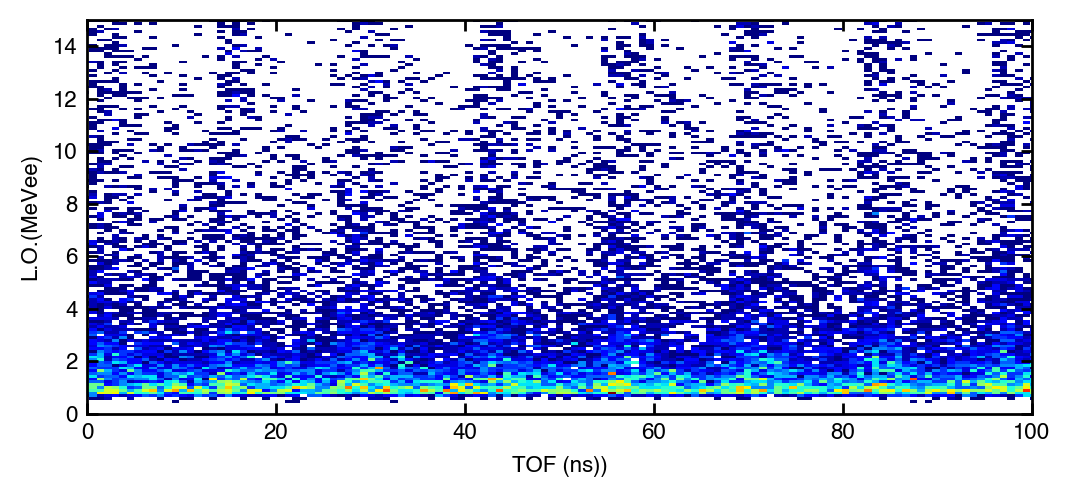

In [399]:
fig = fig_pre_def(12,5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(tri_g_rec_n_data['TOF'],tri_g_rec_n_data['Rec_LO'], bins=(800, 250),cmin=1, cmap=plt.cm.jet)


fig_post_def(xlim =(0,100),ylim = (0,15),xlabel = 'TOF (ns))',ylabel = 'L.O.(MeVee)')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


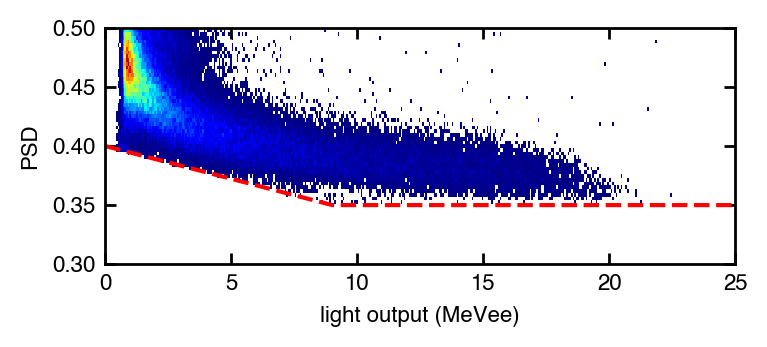

In [400]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(tri_g_rec_n_LO_data['Rec_LO'],tri_g_rec_n_LO_data['Rec_PSD'], bins=(400, 200),cmin=1, cmap=plt.cm.jet)
#ax.axhline(y=0.35, color='r', linestyle='-')
#ax.axvline(x=6, color='r', linestyle='-')
Fed_cut_x = np.arange(0,25,0.01)
Fed_cut_y = Fed_cut_x*-0.00556+ 0.4
Fed_cut_y[900:]=0.35
plt.plot(Fed_cut_x,Fed_cut_y,'--r')

fig_post_def(xlim =(0,25),ylim = (0.3,0.5),xlabel = 'light output (MeVee)',ylabel = 'PSD')


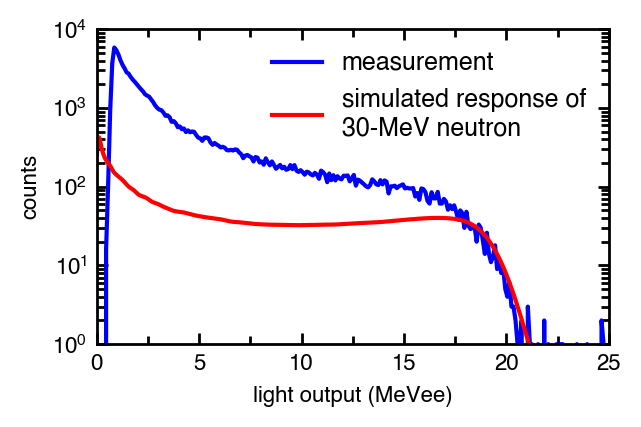

In [401]:
fig = fig_pre_def(6.5,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

response_x, response_y = sorting(tri_g_rec_n_LO_data['Rec_LO'],300,0,30)
plt.plot(response_x, response_y,'b',label='measurement')
plt.plot(neutron_response[:,0],70000*neutron_response[:,-1],'r',label = 'simulated response of\n30-MeV neutron ')
plt.yscale('log')

fig_post_def(xlim =(0,25),xticks=(5,2.5),ylim = (1,10000)
             ,lg_fs = 9
             ,xlabel = 'light output (MeVee)',ylabel = 'counts')
#plt.savefig('/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_sim_exp_LO.svg', format="svg")

In [402]:
QMN_response = np.hstack((response_x[:,np.newaxis],response_y[:,np.newaxis]))
print(QMN_response.shape)
np.savetxt('../../data/30MeV_QMN_response/20240906_QMN_response.txt',QMN_response)

(300, 2)


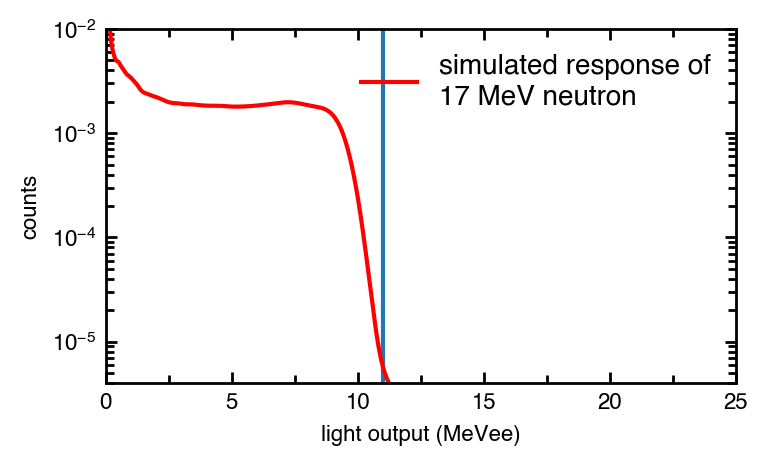

In [403]:
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

response_x, response_y = sorting(tri_g_rec_n_LO_data['Rec_LO'],300,0,30)
#plt.plot(response_x, response_y,'b',label='measurement')
plt.axvline(11)
plt.plot(neutron_response[:,0],neutron_response[:,1],'r',label = 'simulated response of\n17 MeV neutron ')
plt.yscale('log')

fig_post_def(xlim =(0,25),xticks=(5,2.5),ylim = (0.000004,0.01)
             ,lg_fs = 10
             ,xlabel = 'light output (MeVee)',ylabel = 'counts')


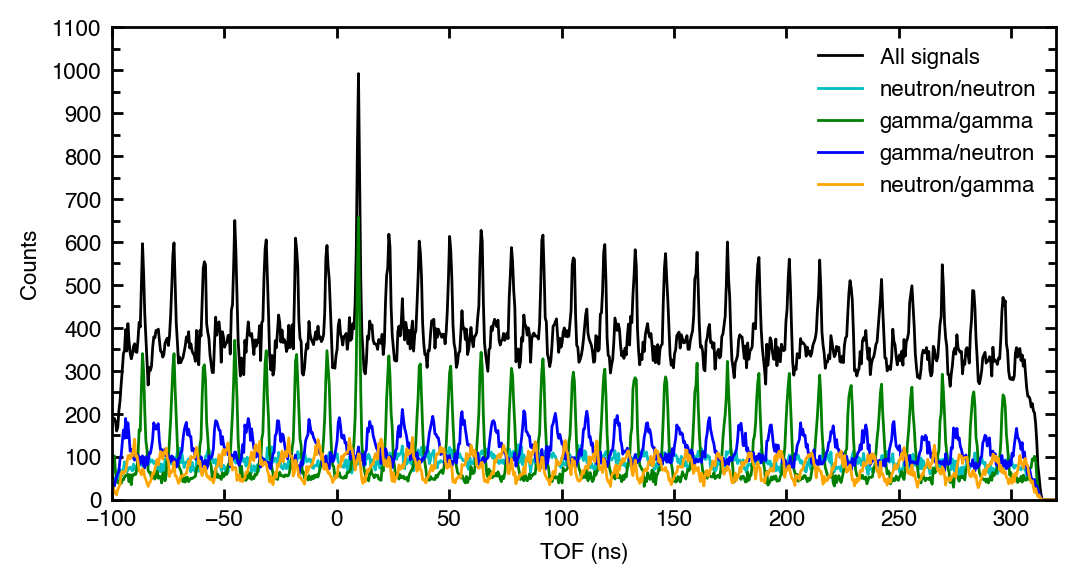

In [404]:
fig = fig_pre_def(12,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
plt.plot(bin_center+time_calibration,hist_all,'k',linewidth=1,label ='All signals')
plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'c' ,linewidth=1,label ='neutron/neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'b' ,linewidth=1,label ='gamma/neutron')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron/gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(-100,320)
             #,xticks=(10,5)
             ,ylim = (0,1100),yticks=(100,50),lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

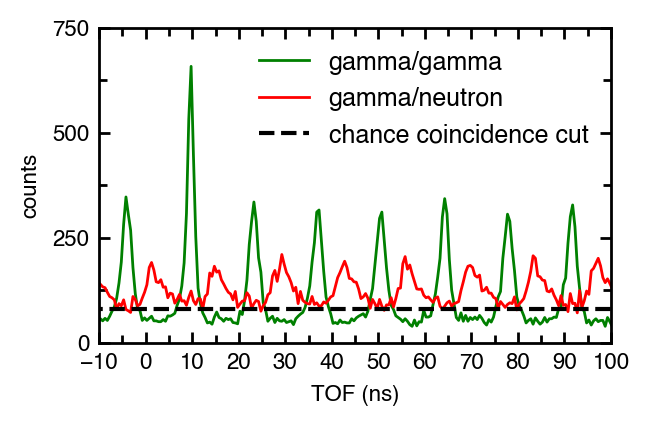

In [405]:
fig = fig_pre_def(6.5,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
#plt.plot(bin_center+time_calibration,hist_all,'k',linewidth=1,label ='all/all')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'c' ,linewidth=1,label ='neutron/neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'r' ,linewidth=1,label ='gamma/neutron')
plt.plot([-100,200],[80,80],'--k',label ='chance coincidence cut')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron/gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(-10,100)
             ,xticks=(10,5)
             ,ylim = (0,750),yticks=(250,125),lg_fs=9,xlabel = 'TOF (ns)',ylabel = 'counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')
#plt.savefig('/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_TOF.svg', format="svg")

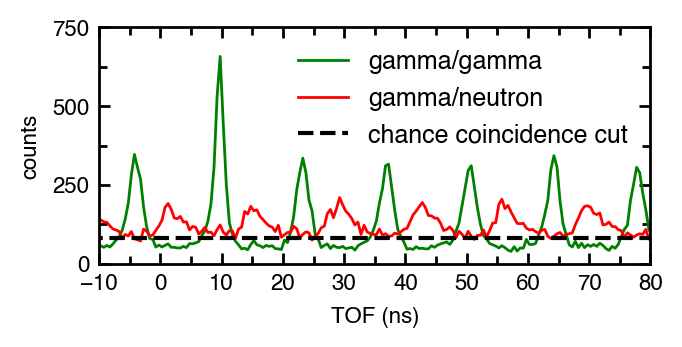

In [406]:
fig = fig_pre_def(7,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
#plt.plot(bin_center+time_calibration,hist_all,'k',linewidth=1,label ='all/all')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'c' ,linewidth=1,label ='neutron/neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'r' ,linewidth=1,label ='gamma/neutron')
plt.plot([-100,200],[80,80],'--k',label ='chance coincidence cut')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron/gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(-10,80)
             ,xticks=(10,5)
             ,ylim = (0,750),yticks=(250,125),lg_fs=9,xlabel = 'TOF (ns)',ylabel = 'counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')
#plt.savefig('/Users/thlin/Dropbox/INER_TOF.svg', format="svg")

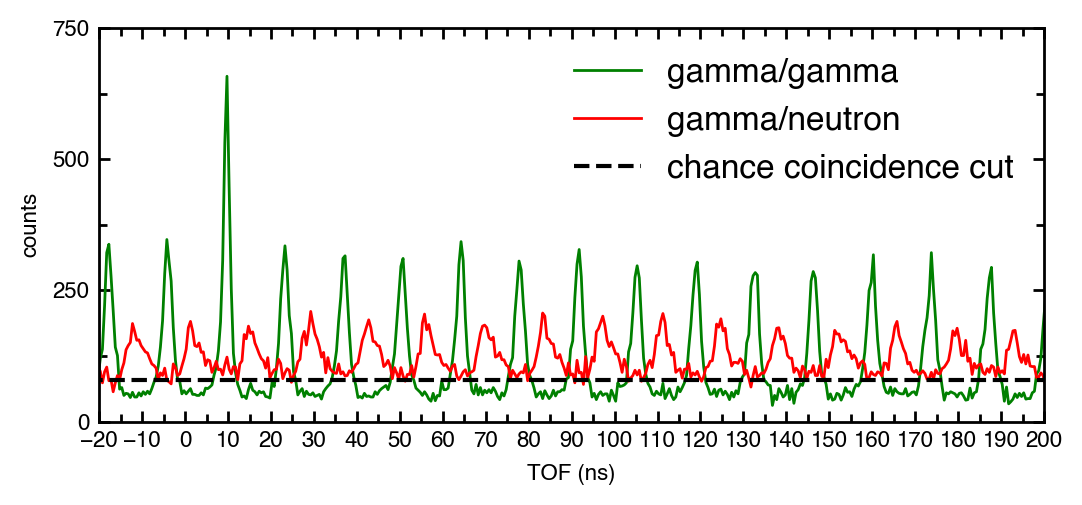

In [407]:
fig = fig_pre_def(12,5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
#plt.plot(bin_center+time_calibration,hist_all,'k',linewidth=1,label ='all/all')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'c' ,linewidth=1,label ='neutron/neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'r' ,linewidth=1,label ='gamma/neutron')
plt.plot([-100,200],[80,80],'--k',label ='chance coincidence cut')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron/gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(-20,200)
             ,xticks=(10,5)
             ,ylim = (0,750),yticks=(250,125),lg_fs=12,xlabel = 'TOF (ns)',ylabel = 'counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')
#plt.savefig('/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_TOF.svg', format="svg")

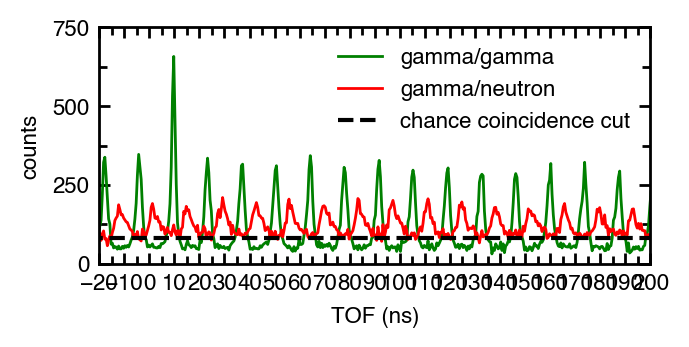

In [408]:
fig = fig_pre_def(7,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
#plt.plot(bin_center+time_calibration,hist_all,'k',linewidth=1,label ='all/all')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'c' ,linewidth=1,label ='neutron/neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'r' ,linewidth=1,label ='gamma/neutron')
plt.plot([-100,200],[80,80],'--k',label ='chance coincidence cut')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron/gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(-20,200)
             ,xticks=(10,5)
             ,ylim = (0,750),yticks=(250,125),lg_fs=8
             ,xlabel = 'TOF (ns)',ylabel = 'counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')
#plt.savefig('/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_TOF.svg', format="svg")

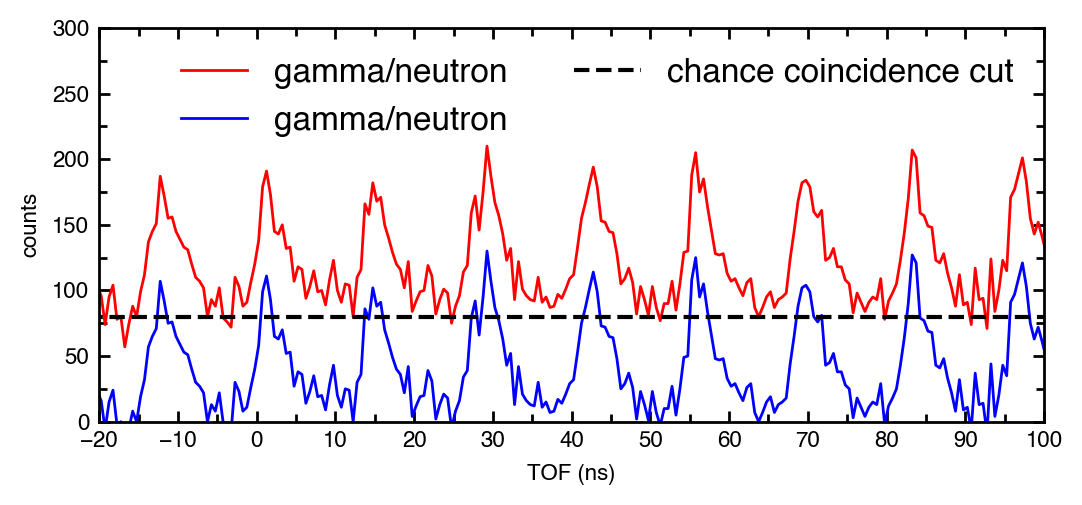

In [409]:
fig = fig_pre_def(12,5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
#plt.plot(bin_center+time_calibration,hist_all,'k',linewidth=1,label ='all/all')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'c' ,linewidth=1,label ='neutron/neutron')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'r' ,linewidth=1,label ='gamma/neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n-80,'b' ,linewidth=1,label ='gamma/neutron')
plt.plot([-100,200],[80,80],'--k',label ='chance coincidence cut')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron/gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(-20,100)
             ,xticks=(10,5),n_col=2
             ,ylim = (0,300),yticks=(50,25),lg_fs=12,xlabel = 'TOF (ns)',ylabel = 'counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')
#plt.savefig('/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_TOF.svg', format="svg")

In [410]:
def gauss_wo_baseline(x,  A, x0, sigma,y0):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))+y0

def gauss_fit_wo_baseline(x, y):  
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    try:  
        popt, pcov = curve_fit(gauss_wo_baseline, x, y, p0=[1, mean, sigma,0], maxfev=1000)
        return popt
    except RuntimeError:
        print("Error - curve_fit failed")
        return  [0,mean,sigma]

-1.75 17.75
[559.02204239   9.65374118   0.75434914  63.3569423 ]
1.7764922320960834


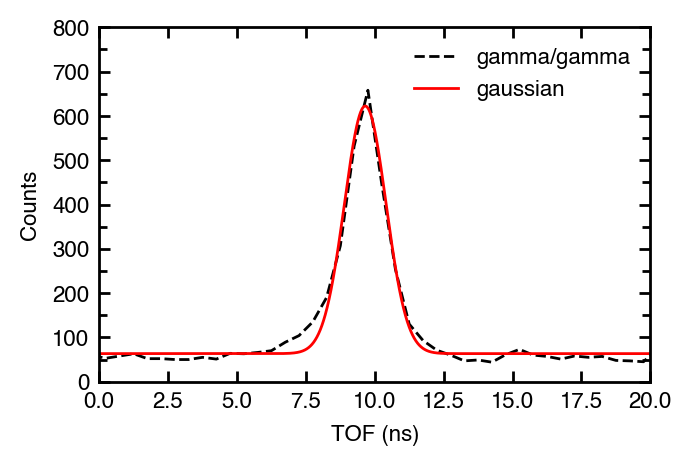

In [411]:
fig = fig_pre_def(7,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
#bin_center, hist_tri_g_rec_g_fine   = sorting(tri_g_rec_g_data['TOF'],1000,0,20)
#plt.plot(bin_center,hist_tri_g_rec_g_fine,'g',linewidth=1,label ='gamma/gamma')
g_center = np.arange(0,20,0.01)
LLD = 796
ULD = 835
print(bin_center[LLD],bin_center[ULD])
popt = gauss_fit_wo_baseline(bin_center[LLD:ULD], hist_tri_g_rec_g[LLD:ULD])
gauss_y = gauss_wo_baseline(g_center,  popt[0],popt[1],popt[2],popt[3])

plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'--k' ,linewidth=1,label ='gamma/gamma')
plt.plot(g_center+time_calibration,gauss_y,'r' ,linewidth=1,label ='gaussian')

fig_post_def(xlim =(0,20)
             ,ylim = (0,800),yticks=(100,50)
             ,lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts')
print(popt)
print(popt[2]*2.355)


In [412]:
(2.873**2-0.245-(2*2.54/30)**2)/2

3.990227611111112

In [413]:
(3.99+0.05**2+0.245)**0.5

2.05851888502389

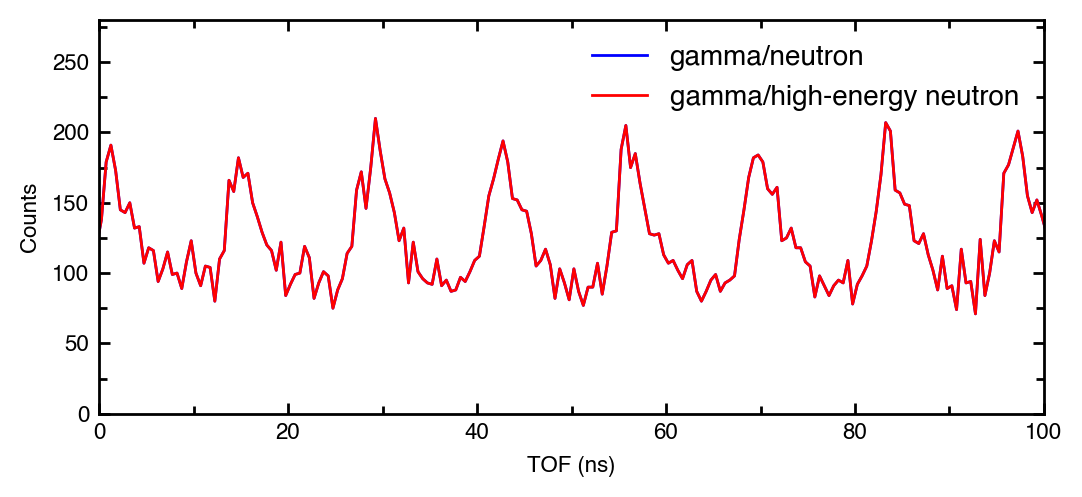

In [414]:
fig = fig_pre_def(12,5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
#plt.plot(bin_center+time_calibration,hist_all,'b',linewidth=1,label ='All events')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'r' ,linewidth=1,label ='neutron/neutron')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'b' ,linewidth=1,label ='gamma/neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(0,100),xticks=(20,10)
             ,ylim = (0,280),yticks=(50,25),lg_fs=10,xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

#  Chance coincidence processing

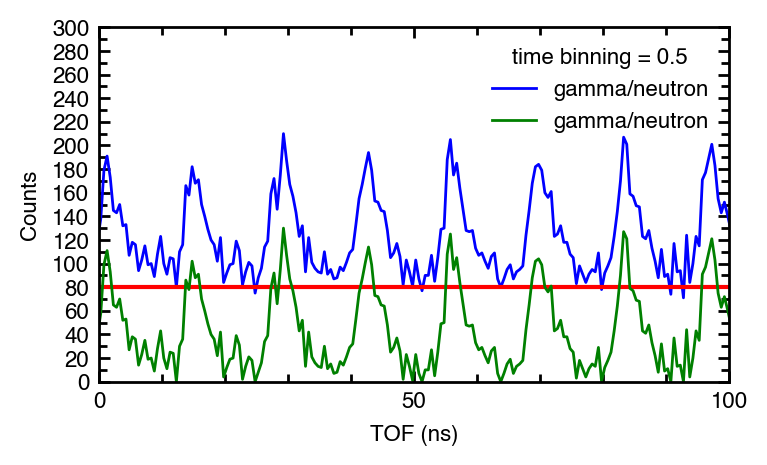

In [415]:
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
bin =2*800
window = 800/bin
bin_center_pro, hist_tri_g_rec_n_pro   = sorting(tri_g_rec_n_data['TOF'],bin,-400,400)
bin_center_pro, hist_tri_g_rec_g_pro   = sorting(tri_g_rec_g_data['TOF'],bin,-400,400)


plt.plot(bin_center_pro,hist_tri_g_rec_n_pro,'-b' ,linewidth=1,label ='gamma/neutron')
plt.axhline(80,color = 'red')
hist_tri_g_rec_n_pro_sub = hist_tri_g_rec_n_pro-80
hist_tri_g_rec_n_pro_sub[hist_tri_g_rec_n_pro_sub<0]=0
plt.plot(bin_center_pro,hist_tri_g_rec_n_pro_sub,'-g' ,linewidth=1,label ='gamma/neutron')
#plt.plot(bin_center_pro,hist_tri_g_rec_g_pro,'k' ,linewidth=1,label ='gamma/gamma')
fig_post_def(xlim =(0,100),xticks=(50,10)
             ,ylim = (0,300),yticks=(20,10)
             ,lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts',title='time binning = '+ str(window))
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


879 904
25


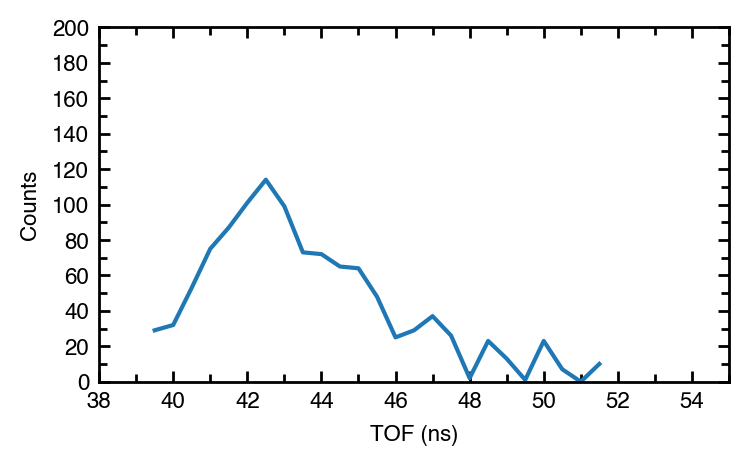

In [416]:
LLD = int(bin/2+int(39.5/window))
ULD = int(bin/2+int(52/window))
print(LLD,ULD)
print(ULD-LLD)
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(np.arange(39.5,52,window),hist_tri_g_rec_n_pro_sub[LLD:ULD])

fig_post_def(xlim =(38,55),xticks=(2,1)
             ,ylim = (0,200),yticks=(20,10)
             ,lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts',title='')

In [417]:
hist_tri_g_rec_n_pro_sub[LLD:ULD+1]

array([ 29,  32,  53,  75,  87, 101, 114,  99,  73,  72,  65,  64,  48,
        25,  29,  37,  26,   2,  23,  13,   1,  23,   7,   0,  10,  10])

In [418]:
def bar_plot(input_x,input_y,binning):
    xs = [input_x[0] - binning/2]
    ys = [0]
    for i in range(len(input_x)):
        xs.append(input_x[i] - binning/2)
        xs.append(input_x[i] + binning/2)
        ys.append(input_y[i])
        ys.append(input_y[i])
    xs.append(input_x[-1] + binning/2)
    ys.append(0)
    return np.array(xs),np.array(ys)

28
28


/var/folders/qd/hhwc9gc95fv6tx8vycl4f3bm0000gn/T/ipykernel_22115/1677561981.py:17: RuntimeWarning: invalid value encountered in sqrt
  err_bar = hist_tri_g_rec_n_pro_sub_interp**0.5


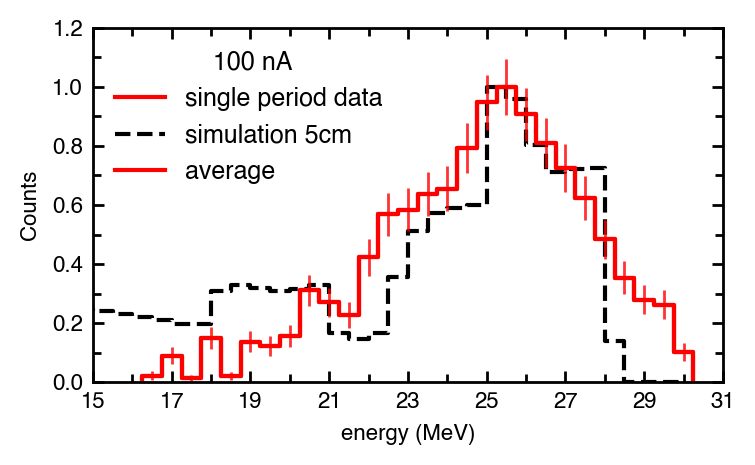

In [419]:

accumulate_x_energy = Time_to_energy(bin_center_pro[LLD-1:ULD+1+1])
print(len(accumulate_x_energy))
E_sub = np.append(hist_tri_g_rec_n_pro_sub[LLD:ULD+1],0)
E_sub = np.append(0,E_sub)
print(len(E_sub))
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
x_axis = np.arange(0,35,0.5)
hist_tri_g_rec_n_pro_sub_interp = interpolation_function(accumulate_x_energy[:],E_sub,x_axis)
bar_x,bar_y = bar_plot(x_axis, hist_tri_g_rec_n_pro_sub_interp/hist_tri_g_rec_n_pro_sub_interp.max(),0.5)
#plt.plot(x_axis,hist_tri_g_rec_n_pro_sub_interp)
plt.plot(bar_x,bar_y,color='red', label='single period data')
INER_QMN_bar_x,INER_QMN_bar_y = bar_plot(INER_QMN[:,0], INER_QMN[:,1] ,0.5)
plt.plot(0.25+INER_QMN_bar_x,INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5cm')

nor_factor = 1/hist_tri_g_rec_n_pro_sub_interp.max()
err_bar = hist_tri_g_rec_n_pro_sub_interp**0.5


# data
plt.plot(bar_x,bar_y,color='red', label='average')

# vertical uncertainty
ax.errorbar(x_axis, nor_factor*hist_tri_g_rec_n_pro_sub_interp,yerr = nor_factor*err_bar,fmt='None',ecolor= 'r',linewidth=1,alpha = 0.8)






#plt.plot(accumulate_x_energy,hist_tri_g_rec_n_pro_sub[LLD:ULD+1],label ='neutron')
fig_post_def(xlim =(15,31),xticks=(2,1),
             ylim = (0,1.2),yticks=(0.2,0.1),
             lg_fs=9,xlabel = 'energy (MeV)',ylabel = 'Counts',title = ' 100 nA')
ax.set_xticks(np.arange(15,33,2))

# plot for poster

In [480]:
unfolding_spectrum = np.loadtxt('../Unfolding/unfolding spectrum.txt')

28
28


/var/folders/qd/hhwc9gc95fv6tx8vycl4f3bm0000gn/T/ipykernel_22115/2223008229.py:17: RuntimeWarning: invalid value encountered in sqrt
  err_bar = hist_tri_g_rec_n_pro_sub_interp**0.5


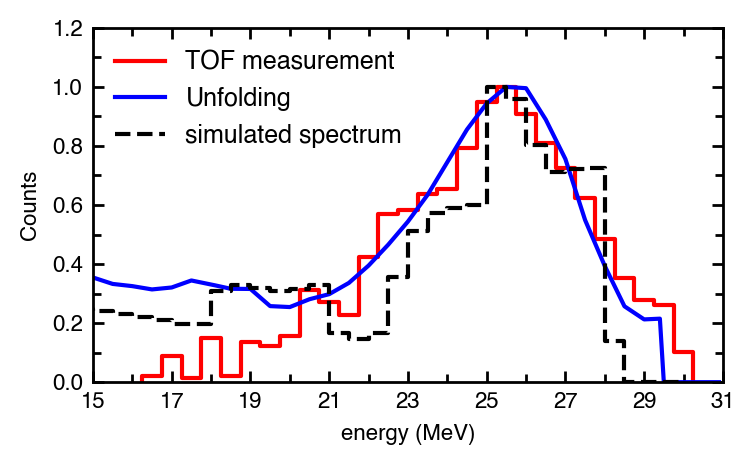

In [494]:

accumulate_x_energy = Time_to_energy(bin_center_pro[LLD-1:ULD+1+1])
print(len(accumulate_x_energy))
E_sub = np.append(hist_tri_g_rec_n_pro_sub[LLD:ULD+1],0)
E_sub = np.append(0,E_sub)
print(len(E_sub))
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
x_axis = np.arange(0,35,0.5)
hist_tri_g_rec_n_pro_sub_interp = interpolation_function(accumulate_x_energy[:],E_sub,x_axis)
bar_x,bar_y = bar_plot(x_axis, hist_tri_g_rec_n_pro_sub_interp/hist_tri_g_rec_n_pro_sub_interp.max(),0.5)
#plt.plot(x_axis,hist_tri_g_rec_n_pro_sub_interp)
plt.plot(bar_x,bar_y,color='red', label='TOF measurement')
INER_QMN_bar_x,INER_QMN_bar_y = bar_plot(INER_QMN[:,0], INER_QMN[:,1] ,0.5)


nor_factor = 1/hist_tri_g_rec_n_pro_sub_interp.max()
err_bar = hist_tri_g_rec_n_pro_sub_interp**0.5

unfolding_x_in = np.arange(0.5,30,0.5)
unfolding_x_axis = np.arange(0,31,0.1)
unfolding_spectrum_nor = interpolation_function(unfolding_x_in,unfolding_spectrum/unfolding_spectrum[30:].max(),unfolding_x_axis)
unfolding_spectrum_nor[295:]=0
plt.plot(unfolding_x_axis,unfolding_spectrum_nor,'b',label = 'Unfolding')

plt.plot(0.25+INER_QMN_bar_x,INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulated spectrum')

# data
#plt.plot(bar_x,bar_y,color='red', label='average')

# vertical uncertainty
#ax.errorbar(x_axis, nor_factor*hist_tri_g_rec_n_pro_sub_interp,yerr = nor_factor*err_bar,fmt='None',ecolor= 'r',linewidth=1,alpha = 0.8)






#plt.plot(accumulate_x_energy,hist_tri_g_rec_n_pro_sub[LLD:ULD+1],label ='neutron')
fig_post_def(xlim =(15,31),xticks=(2,1),
             ylim = (0,1.2),yticks=(0.2,0.1),
             lg_fs=9,xlabel = 'energy (MeV)',ylabel = 'Counts'
             #,title = ' 100 nA'
             )
ax.set_xticks(np.arange(15,33,2))

# Accumulate the neutron signals 

In [139]:
print(tri_g_rec_n_data.head())

    time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD   Tri_LO         TOF  \
2     192.340  0.460648   0.99916      6.0  0.302831  3.80045  185.896784   
4      75.051  0.396496  17.09770      4.0  0.306701  0.62350   68.607784   
7     287.040  0.400336   5.14414      4.0  0.306376  1.92560  280.596784   
8      90.958  0.459610   0.84367      6.0  0.291294  1.84295   84.514784   
10    -34.543  0.473348   1.07797      4.0  0.321452  2.29825  -40.986216   

        Rec_E  Tri_p  Rec_p  
2    1.290432    1.0    2.0  
4    9.601434    1.0    2.0  
7    0.565721    1.0    2.0  
8    6.293948    1.0    2.0  
10  27.685484    1.0    2.0  


In [154]:
# the fast neutron TOF is 39.44 ns, 

fastest_n =39.4445
fastest_1_period= 39.4445 + 13.6745
exceeded_n = 52.445
print(fastest_1_period)


53.119


In [184]:
# this function is used to move all the repeat neutron bunch in a single neutron bunch
def TOF_shift_fun(input_x):
    shifted_TOF = ((input_x+20*13.6745-39.4445)%13.6745+39.4445) #the first part aims to avoid the time after substract 39.445 become a value <0
    return shifted_TOF

#please notice that 
#print((0+20*13.6745-39.4445)%13.6745+39.4445)

In [185]:
y= TOF_shift_fun(-20)
print(y)

48.3725


In [187]:
# assign analyzed region
TOF_region_L=39.4445-7*RF_T
TOF_region_R=39.4445+5*RF_T

mask_TOF_L  = tri_g_rec_n_data['TOF'] > TOF_region_L
mask_TOF_R  = tri_g_rec_n_data['TOF'] < TOF_region_R

#filter neutron in recording detector
pro_merge_data_temp = tri_g_rec_n_data[(mask_TOF_L & mask_TOF_R )]

pro_merge_data = pro_merge_data_temp.copy(deep=True)
pro_merge_data["shift_TOF"] = pro_merge_data['TOF'].apply(lambda x:TOF_shift_fun(x))

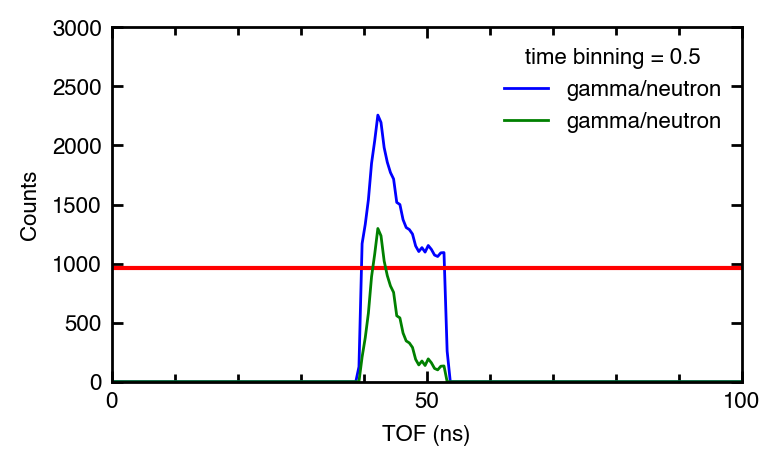

In [221]:
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
bin =2*800
window = 800/bin
bin_center_merge, hist_merge   = sorting(pro_merge_data['shift_TOF'],bin,-400,400)


plt.plot(bin_center_merge,hist_merge,'-b' ,linewidth=1,label ='gamma/neutron')
cut = 12*80
plt.axhline(cut,color = 'red')
hist_merge_sub = hist_merge-cut
hist_merge_sub[hist_merge_sub<0]=0
plt.plot(bin_center_merge,hist_merge_sub,'-g' ,linewidth=1,label ='gamma/neutron')
#plt.plot(bin_center_merge,hist_tri_g_rec_g_pro,'k' ,linewidth=1,label ='gamma/gamma')
fig_post_def(xlim =(0,100),xticks=(50,10)
             ,ylim = (0,3000)#,yticks=(20,10)
             ,lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts',title='time binning = '+ str(window))
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


878 908
30


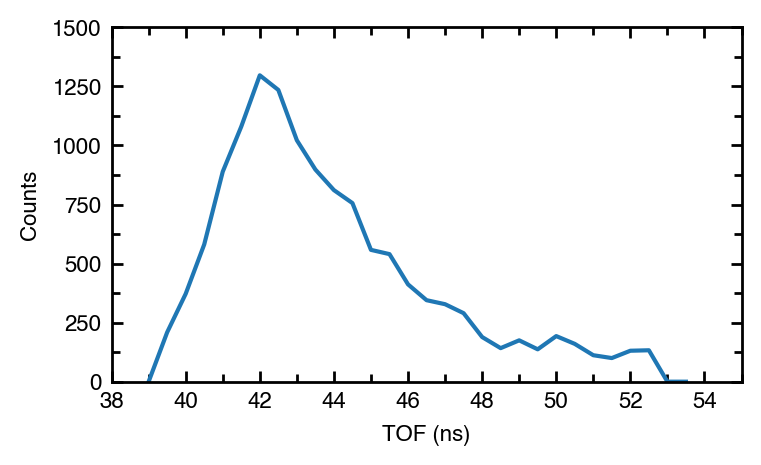

In [222]:
LLD = int(bin/2+int(39.0/window))
ULD = int(bin/2+int(54/window))
print(LLD,ULD)
print(ULD-LLD)
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(np.arange(39.0,54,window),hist_merge_sub[LLD:ULD])



fig_post_def(xlim =(38,55),xticks=(2,1)
             ,ylim = (0,1500),yticks=(250,125)
             ,lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts',title='')

33
33


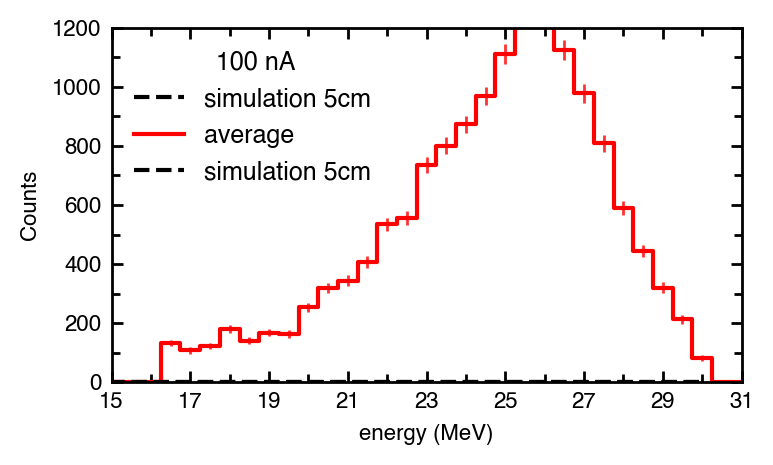

In [227]:

accumulate_x_energy = Time_to_energy(bin_center_merge[LLD-1:ULD+1+1])
print(len(accumulate_x_energy))
E_sub = np.append(hist_merge_sub[LLD:ULD+1],0)
E_sub = np.append(0,E_sub)
print(len(E_sub))
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 


x_axis = np.arange(0,35,0.5)
bin_center_merge_interp = interpolation_function(accumulate_x_energy[:],E_sub,x_axis)

nor_factor = 1/bin_center_merge_interp.max()
err_bar = bin_center_merge_interp**0.5


bar_x,bar_y = bar_plot(x_axis, bin_center_merge_interp,0.5)

# data
plt.plot(bar_x,bar_y,color='red', label='average')

# vertical uncertainty
ax.errorbar(x_axis, bin_center_merge_interp,yerr = err_bar,fmt='None',ecolor= 'r',linewidth=1,alpha = 0.8)





INER_QMN_bar_x,INER_QMN_bar_y = bar_plot(INER_QMN[:,0], INER_QMN[:,1] ,0.5)
plt.plot(0.25+INER_QMN_bar_x,INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5cm')

#plt.plot(accumulate_x_energy,hist_tri_g_rec_n_pro_sub[LLD:ULD+1],label ='neutron')
fig_post_def(xlim =(15,31),xticks=(2,1),
             ylim = (0,1200),yticks=(200,100),
             lg_fs=9,xlabel = 'energy (MeV)',ylabel = 'Counts',title = ' 100 nA')
ax.set_xticks(np.arange(15,33,2))

33
33


/var/folders/qd/hhwc9gc95fv6tx8vycl4f3bm0000gn/T/ipykernel_22115/1133975486.py:7: RuntimeWarning: divide by zero encountered in divide
  TOF= (distance/speed)*10**9


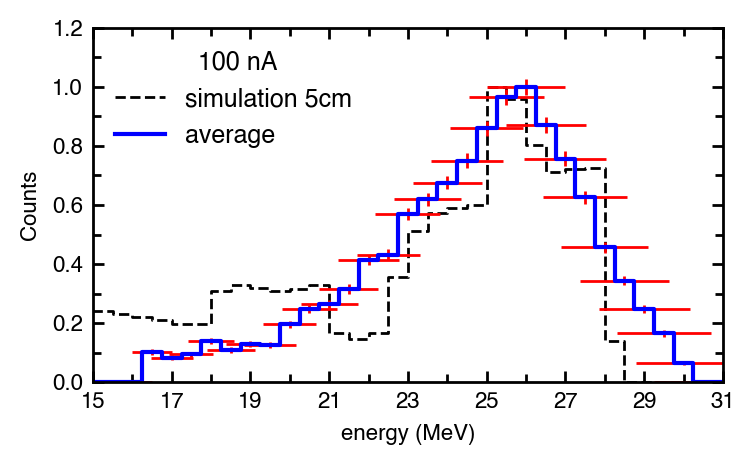

In [232]:

accumulate_x_energy = Time_to_energy(bin_center_merge[LLD-1:ULD+1+1])
print(len(accumulate_x_energy))
E_sub = np.append(hist_merge_sub[LLD:ULD+1],0)
E_sub = np.append(0,E_sub)
print(len(E_sub))
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

INER_QMN_bar_x,INER_QMN_bar_y = bar_plot(INER_QMN[:,0], INER_QMN[:,1] ,0.5)
plt.plot(0.25+INER_QMN_bar_x,INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',linewidth=1,label = 'simulation 5cm')



x_axis = np.arange(0,35,0.5)
bin_center_merge_interp = interpolation_function(accumulate_x_energy[:],E_sub,x_axis)

nor_factor = 1/bin_center_merge_interp.max()
err_bar = bin_center_merge_interp**0.5


bar_x,bar_y = bar_plot(x_axis, nor_factor*bin_center_merge_interp,0.5)



# vertical uncertainty
ax.errorbar(x_axis, nor_factor*bin_center_merge_interp,yerr = nor_factor*err_bar,fmt='None',ecolor= 'r',linewidth=1,alpha = 1)

# horizontal uncertainty
E_resolution_axis = E_resolution_gTOF_modified(x_axis, 1.02,294,3.86)/2
ax.errorbar(x_axis, nor_factor*bin_center_merge_interp,xerr = E_resolution_axis,fmt='None',ecolor= 'r',linewidth=1,alpha = 1)

# data
plt.plot(bar_x,bar_y,color='blue', label='average')

#plt.plot(accumulate_x_energy,hist_tri_g_rec_n_pro_sub[LLD:ULD+1],label ='neutron')
fig_post_def(xlim =(15,31),xticks=(2,1),
             ylim = (0,1.2),yticks=(0.2,0.1),
             lg_fs=9,xlabel = 'energy (MeV)',ylabel = 'Counts',title = ' 100 nA')
ax.set_xticks(np.arange(15,33,2))

In [ ]:
tri_g_rec_n_data['TOF']

41.0235


In [172]:
print(39.4445-3*13.6745)
print(39.4445+1.579)

-1.5790000000000006
41.0235


In [65]:
threshold =30
peaks, _ = find_peaks(hist_tri_g_rec_g_pro, height=threshold, distance =20)
print(peaks)
print(bin_center_pro[peaks])

[ 602  627  655  682  709  737  764  791  819  846  874  901  928  955
  983 1010 1038 1065 1092 1120 1147 1175 1202 1229 1257 1284 1311 1338
 1366 1392 1420]
[-98.75 -86.25 -72.25 -58.75 -45.25 -31.25 -17.75  -4.25   9.75  23.25
  37.25  50.75  64.25  77.75  91.75 105.25 119.25 132.75 146.25 160.25
 173.75 187.75 201.25 214.75 228.75 242.25 255.75 269.25 283.25 296.25
 310.25]


4


ValueError: x and y must have same first dimension, but have shapes (27,) and (25,)

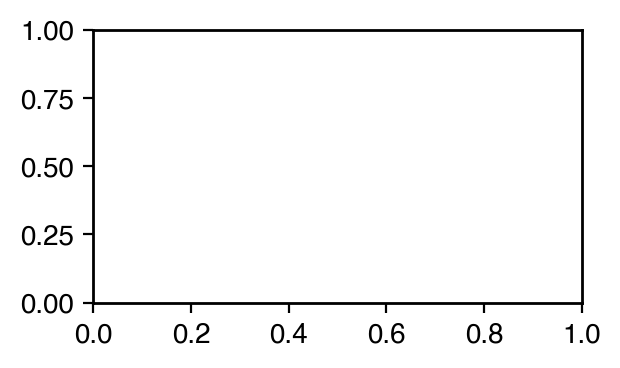

In [115]:
shift = int((39.5-37.45)/window)
print(shift)

accumulate_g_n=np.zeros(ULD-LLD)
for i in np.arange(0,len(peaks)-2,1):
    accumulate_g_n += hist_tri_g_rec_n_pro_sub[shift+peaks[i]:shift+peaks[i]+ULD-LLD]

accumulate_x = np.arange(0,13.2,window)+39.45


fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(accumulate_x,accumulate_g_n,'-')

fig_post_def(xlim =(38,55),xticks=(2,1)
             ,ylim = (0,1200),yticks=(200,100)
             ,lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts'
             ,title='accumulate data')


In [ ]:
print(accumulate_x)
print(accumulate_x_energy_sum)

[39.45 39.95 40.45 40.95 41.45 41.95 42.45 42.95 43.45 43.95 44.45 44.95
 45.45 45.95 46.45 46.95 47.45 47.95 48.45 48.95 49.45 49.95 50.45 50.95
 51.45 51.95 52.45]


NameError: name 'accumulate_x_energy_sum' is not defined

ValueError: x and y must have same first dimension, but have shapes (27,) and (25,)

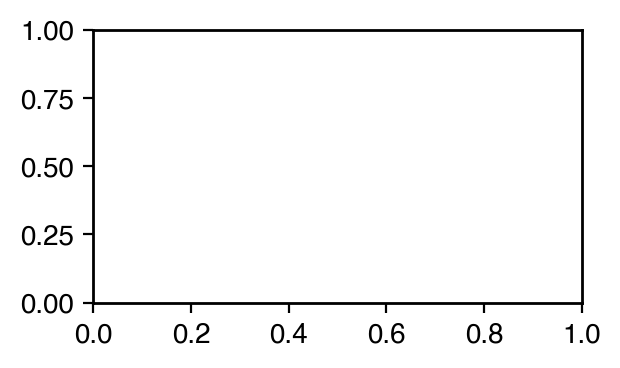

In [ ]:



accumulate_x_energy_sum = Time_to_energy(accumulate_x)


fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
#plt.bar(accumulate_x_energy_sum,accumulate_g_n,width=0.1,label ='neutron')
plt.plot(accumulate_x_energy_sum,accumulate_g_n-100,'.-b',label ='neutron')
fig_post_def(xlim =(17,30),xticks=(2,1),
             ylim = (0,1100),yticks=(200,100),
             lg_fs=8,xlabel = 'energy (MeV)',ylabel = 'Counts',title = ' 100 nA Merged data')

In [ ]:
print(tri_g_rec_n_LO_data.head())

    time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD   Tri_LO         TOF  \
2     192.340  0.460648   0.99916      6.0  0.302831  3.80045  185.896784   
4      75.051  0.396496  17.09770      4.0  0.306701  0.62350   68.607784   
7     287.040  0.400336   5.14414      4.0  0.306376  1.92560  280.596784   
8      90.958  0.459610   0.84367      6.0  0.291294  1.84295   84.514784   
10    -34.543  0.473348   1.07797      4.0  0.321452  2.29825  -40.986216   

        Rec_E  Tri_p  Rec_p  
2    1.290432    1.0    2.0  
4    9.601434    1.0    2.0  
7    0.565721    1.0    2.0  
8    6.293948    1.0    2.0  
10  27.685484    1.0    2.0  


     time_diff   Rec_PSD   Rec_LO  Tri_Det   Tri_PSD   Tri_LO        TOF  \
48      54.684  0.403232  5.35075      4.0  0.278393  1.10780  48.240784   
145     50.254  0.427911  2.84161      6.0  0.324461  1.20495  43.810784   
170     49.518  0.522667  0.87775      4.0  0.309009  2.94205  43.074784   
343     56.194  0.474194  0.73930      4.0  0.367137  1.19045  49.750784   
383     52.884  0.444695  1.02259      4.0  0.340777  1.55440  46.440784   

         Rec_E  Tri_p  Rec_p  
48   19.736765    1.0    2.0  
145  24.095138    1.0    2.0  
170  24.959487    1.0    2.0  
343  18.521191    1.0    2.0  
383  21.350771    1.0    2.0  


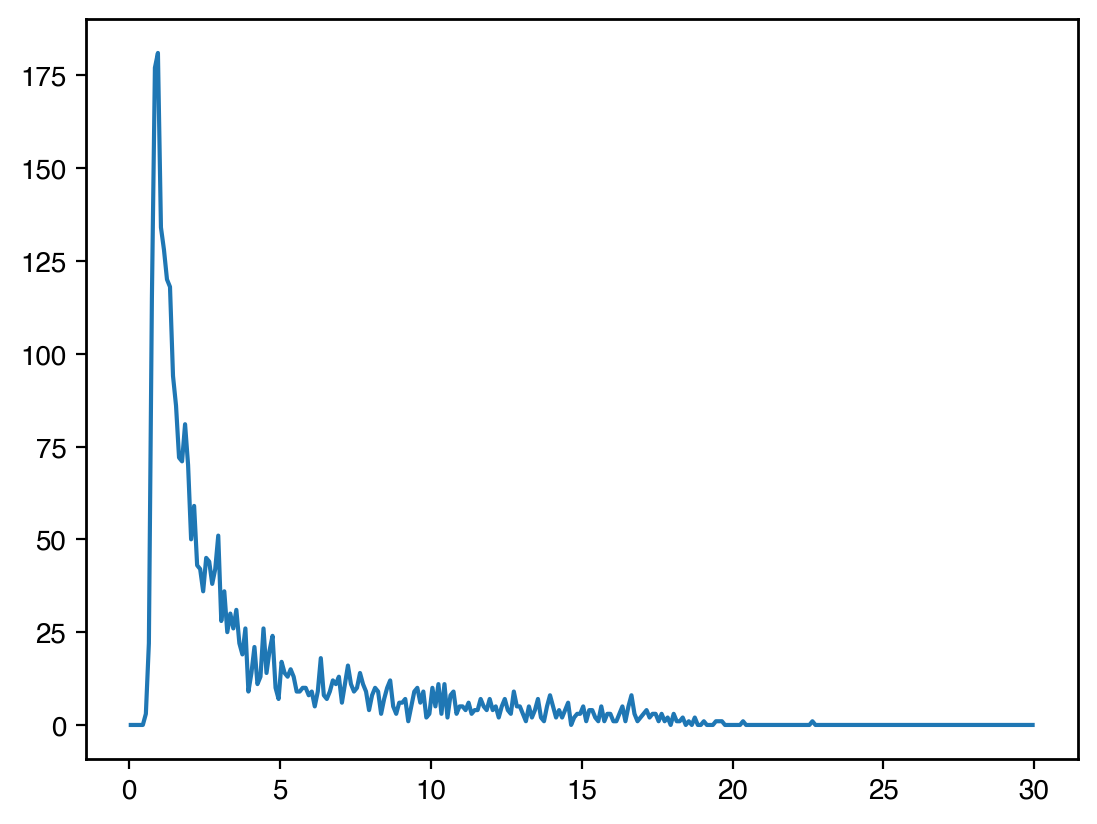

In [ ]:
mask_time_lower = tri_g_rec_n_LO_data['TOF']>39.45
mask_time_upper = tri_g_rec_n_LO_data['TOF']<52
#mask_LO_limit = tri_g_rec_n_LO_data['Rec_LO']>5
tri_g_rec_n_data_ROI = tri_g_rec_n_LO_data[(mask_time_lower & mask_time_upper)]
response_x,response_y = sorting(tri_g_rec_n_data_ROI['Rec_LO'],300,0,30)
print(tri_g_rec_n_data_ROI.head())
plt.plot(response_x,response_y )

In [75]:
response_x,response_y = sorting(tri_g_rec_n_data_ROI['Rec_E'],60,0,30)
plt.plot(response_x,response_y )

NameError: name 'tri_g_rec_n_data_ROI' is not defined

In [76]:
def bar_plot(input_x,input_y,binning):
    xs = [input_x[0] - binning/2]
    ys = [0]
    for i in range(len(input_x)):
        xs.append(input_x[i] - binning/2)
        xs.append(input_x[i] + binning/2)
        ys.append(input_y[i])
        ys.append(input_y[i])
    xs.append(input_x[-1] + binning/2)
    ys.append(0)
    return np.array(xs),np.array(ys)

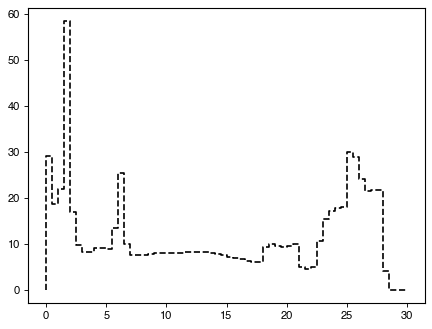

In [112]:
INER_QMN = np.loadtxt("INER_QMN_30MeV.txt")
INER_QMN_bar_x,INER_QMN_bar_y = bar_plot(INER_QMN[:,0], INER_QMN[:,1] ,0.5)
plt.plot(0.25+INER_QMN_bar_x,30*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5cm')

In [113]:


Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 50 # 10 MeV
Binning = 100 # cut to 100 pieces
Neutron_E_axis, Neutron_E_y = sorting(
    tri_g_rec_n_data_ROI['Rec_E'], Binning , Neutron_energy_lower, Neutron_energy_upper)

NameError: name 'tri_g_rec_n_data_ROI' is not defined

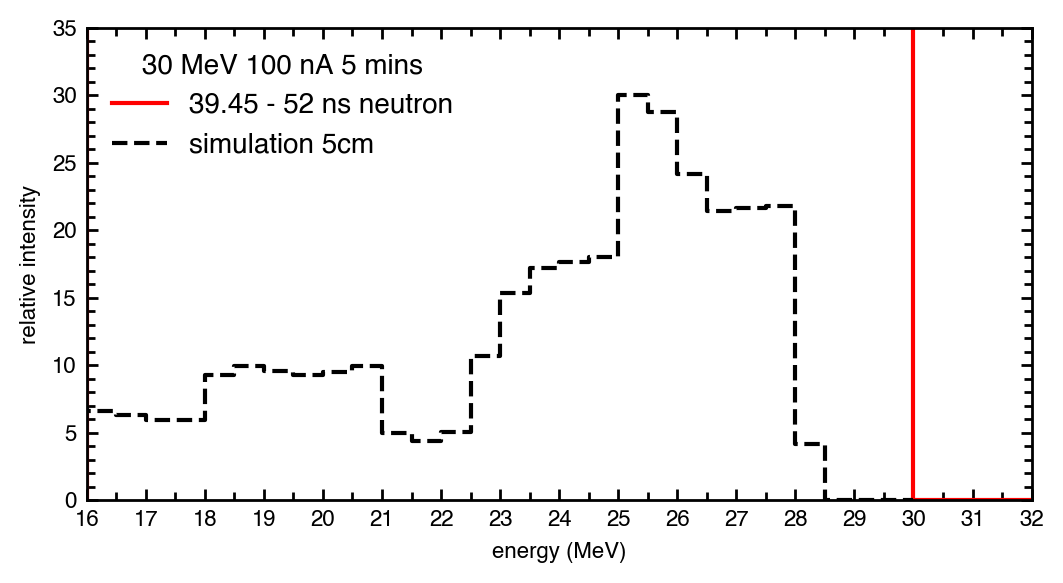

In [114]:

fig = fig_pre_def(12,6) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


bar_x,bar_y = bar_plot(Neutron_E_axis, Neutron_E_y ,0.5)
plt.plot(bar_x,bar_y/10,'r' ,label ='39.45 - 52 ns neutron')
INER_QMN_bar_x,INER_QMN_bar_y = bar_plot(INER_QMN[:,0], INER_QMN[:,1] ,0.5)
plt.plot(0.25+INER_QMN_bar_x,30*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5cm')

#plt.bar(Neutron_E_axis, Neutron_E_y,width=0.5)
ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(16,32),ylim=(0,35),xticks=(1,0.5),yticks=(5,1),title='30 MeV 100 nA 5 mins',lg_fs = 10,xlabel='energy (MeV)',ylabel='relative intensity')
#plt.legend(fontsize=18)


In [80]:
reference_t = np.arange(-2*13.764, 16*13.764,13.764)+energy_to_time(30)
print(reference_t)



[ 11.9165442  25.6805442  39.4445442  53.2085442  66.9725442  80.7365442
  94.5005442 108.2645442 122.0285442 135.7925442 149.5565442 163.3205442
 177.0845442 190.8485442 204.6125442 218.3765442 232.1405442 245.9045442]


In [81]:
proE_GN_T_data = proE_GN_data.copy()
proE_GN_T_data2 = proE_GN_data.copy()
RF_T=10**9/(73.129*10**6)
print(RF_T)

mask_T_start = proE_GN_T_data['TOF'] > energy_to_time(30)-RF_T*5 #9
mask_T_end   = proE_GN_T_data['TOF'] < energy_to_time(30)+RF_T*18 #18
proE_GN_T_data = proE_GN_T_data[(maks_LO_limit & mask_Tri_g & mask_Rec_n&mask_T_start & mask_T_end)]

mask_T_start_single = proE_GN_T_data2['TOF'] > energy_to_time(30) #9
mask_T_end_single   = proE_GN_T_data2['TOF'] < energy_to_time(16.6) #18
proE_GN_T_data_single =proE_GN_T_data2[(maks_LO_limit & mask_Tri_g & mask_Rec_n&mask_T_start_single & mask_T_end_single)]

proE_GN_T_data['merge_TOF'] = proE_GN_T_data['TOF'].apply(lambda x:energy_to_time(30)+(RF_T*8+(x-energy_to_time(30)))%RF_T)
proE_GN_T_data['Rec_mergeT_E'] = Time_to_energy(np.round(proE_GN_T_data['merge_TOF']/resolution_time)*resolution_time  )

proE_GN_T_data_single['Rec_E2'] = Time_to_energy(np.round(proE_GN_T_data_single['TOF']/resolution_time)*resolution_time  )


13.674465670253936


/var/folders/qd/hhwc9gc95fv6tx8vycl4f3bm0000gn/T/ipykernel_22115/1930103226.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proE_GN_T_data_single['Rec_E2'] = Time_to_energy(np.round(proE_GN_T_data_single['TOF']/resolution_time)*resolution_time  )


In [82]:
bin_center, hist_tri_g_rec_g_m_TOF   = sorting(proE_GN_T_data['merge_TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_g_rec_g_m_TOF_single   = sorting(proE_GN_T_data_single['TOF'],hist_bin,hist_lower,hist_upper)


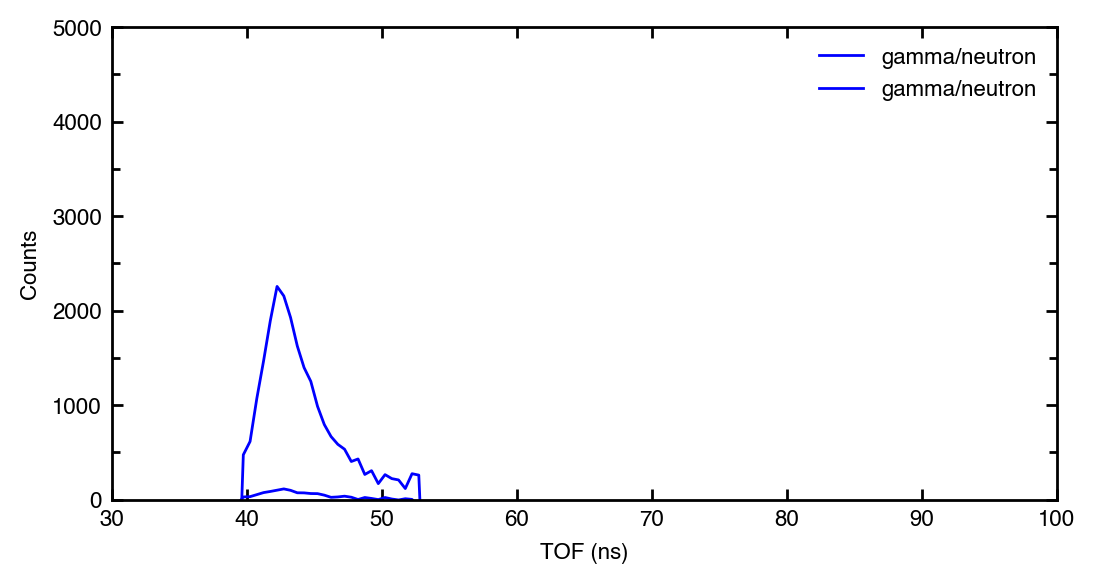

In [83]:
fig = fig_pre_def(12,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center, hist_tri_g_rec_g_m_TOF-23*80,'b' ,linewidth=1,label ='gamma/neutron')

plt.plot(bin_center, hist_tri_g_rec_g_m_TOF_single-80,'b' ,linewidth=1,label ='gamma/neutron')

fig_post_def(xlim =(30,100)
             #,xticks=(10,5)
             ,ylim = (0,5000),yticks=(1000,500),lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts')

In [84]:
def bar_plot_dynamic_w(input_x,input_y):
    xs = [0]
    ys = [0]
    for i in range(len(input_x)-1):
        xs.append(input_x[i] - (input_x[i+1]-input_x[i])/2)
        xs.append(input_x[i] + (input_x[i+1]-input_x[i])/2)
        ys.append(input_y[i])
        ys.append(input_y[i])
    xs.append(input_x[-1] + (input_x[i+1]-input_x[i])/2)
    ys.append(0)
    return np.array(xs),np.array(ys)

/var/folders/qd/hhwc9gc95fv6tx8vycl4f3bm0000gn/T/ipykernel_22115/1973598100.py:19: RuntimeWarning: invalid value encountered in power
  neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)


(0.0, 3000.0)

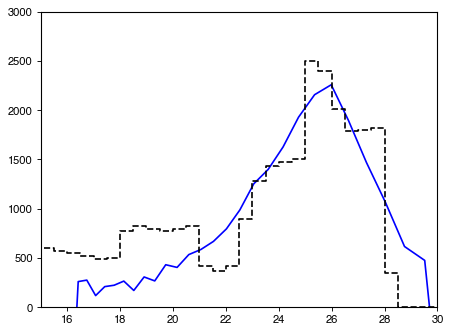

In [85]:
bin_center_x = Time_to_energy(bin_center)

plt.plot(bin_center_x,hist_tri_g_rec_g_m_TOF-23*80,'-b')
plt.plot(0.25+INER_QMN_bar_x,2500*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5 cm')
plt.xlim(15,30)
plt.ylim(0,3000)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_E_spectrum.svg'

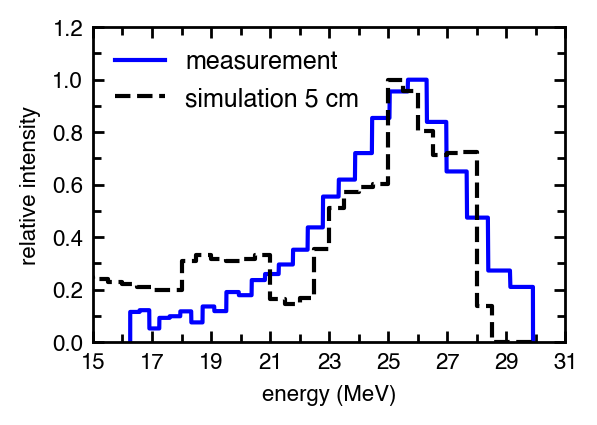

In [86]:
fig = fig_pre_def(6,4) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


bar_x, bar_y = bar_plot_dynamic_w(bin_center_x,hist_tri_g_rec_g_m_TOF-23*80)
ax.plot(bar_x, bar_y/bar_y.max() ,'-b',label = 'measurement')
ax.plot(0.25+INER_QMN_bar_x,INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5 cm')

#bar_x_single ,bar_y_single =  bar_plot_dynamic_w(accumulate_x_energy[:],hist_tri_g_rec_n_pro_sub[LLD:ULD])
#ax.plot(bar_x_single, bar_y_single/bar_y_single.max() ,'-g',label = 'measurement')


fig_post_def(xlim=(15,31),ylim=(0,1.2)
             ,xticks=(2,1),yticks=(0.2,0.1)#,title='30 MeV 100 nA 5 mins'
             ,lg_fs = 9,xlabel='energy (MeV)',ylabel='relative intensity')
ax.set_xticks(np.arange(15,33,2))
#plt.savefig('/Users/thlin/Dropbox/PhD_thesis_博士論文/Figure/INER_E_spectrum.svg', format="svg")

NameError: name 'INER_QMN_bar_x' is not defined

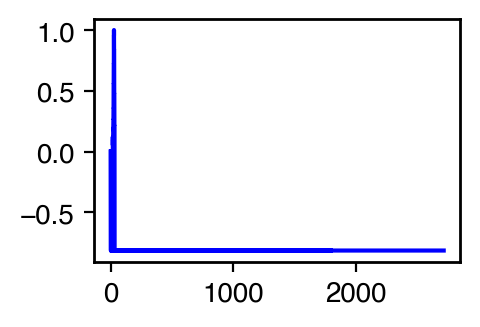

In [ ]:
fig = fig_pre_def(6,4) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


bar_x, bar_y = bar_plot_dynamic_w(bin_center_x,hist_tri_g_rec_g_m_TOF-23*80)
ax.plot(bar_x, bar_y/bar_y.max() ,'-b',label = 'measurement')
ax.plot(0.25+INER_QMN_bar_x,INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5 cm')

#bar_x_single ,bar_y_single =  bar_plot_dynamic_w(accumulate_x_energy[:],hist_tri_g_rec_n_pro_sub[LLD:ULD])
#ax.plot(bar_x_single, bar_y_single/bar_y_single.max() ,'-g',label = 'measurement')


fig_post_def(xlim=(15,31),ylim=(0,1.2)
             ,xticks=(2,1),yticks=(0.2,0.1)#,title='30 MeV 100 nA 5 mins'
             ,lg_fs = 9,xlabel='energy (MeV)',ylabel='relative intensity')
ax.set_xticks(np.arange(15,33,2))
#plt.savefig('/Users/thlin/Dropbox/INER_E_spectrum.svg', format="svg")

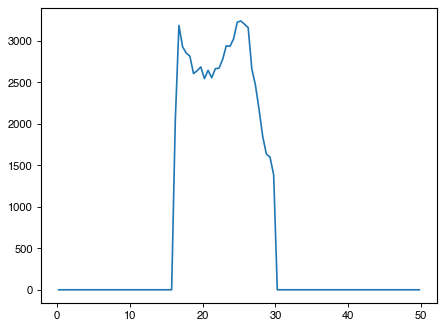

In [87]:
mask_time_lower = proE_GN_T_data['merge_TOF']>39.45
mask_time_upper = proE_GN_T_data['merge_TOF']<52
#mask_LO_limit = tri_g_rec_n_LO_data['Rec_LO']>5
tri_g_rec_n_data_merge_T_ROI = proE_GN_T_data[(mask_time_lower & mask_time_upper)]

Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 50 # 10 MeV
Binning = 100 # cut to 100 pieces
Neutron_E_axis, Neutron_E_y = sorting(
    proE_GN_T_data['Rec_mergeT_E'], Binning , Neutron_energy_lower, Neutron_energy_upper)
plt.plot(Neutron_E_axis, Neutron_E_y )

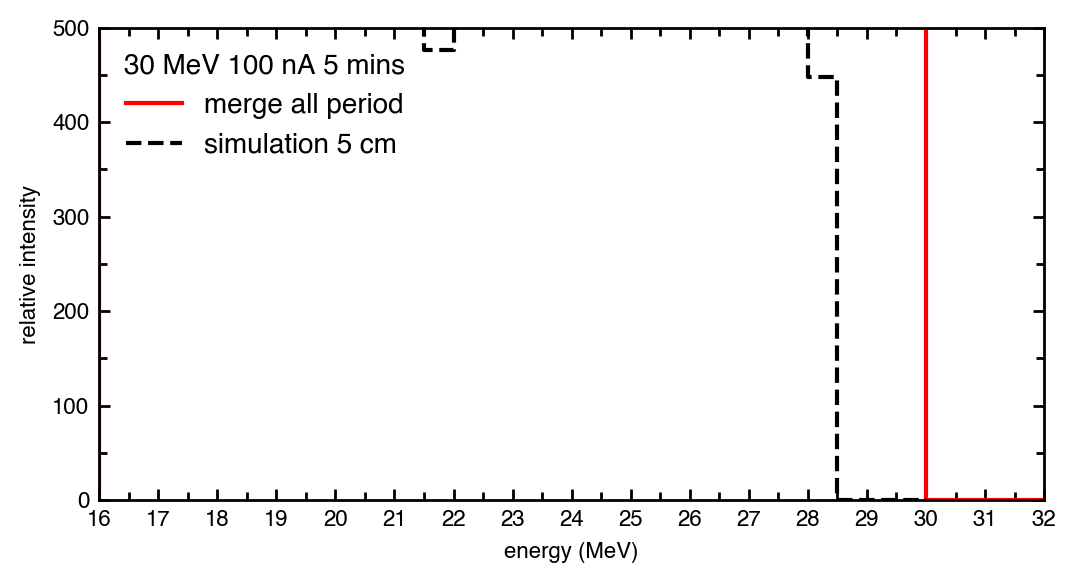

In [88]:

fig = fig_pre_def(12,6) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


bar_x,bar_y = bar_plot(Neutron_E_axis, Neutron_E_y ,0.5)
plt.plot(bar_x,bar_y,'r' ,label ='merge all period')

plt.plot(0.25+INER_QMN_bar_x,Neutron_E_y.max()*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5 cm')
#plt.bar(Neutron_E_axis, Neutron_E_y,width=0.5)
ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(16,32),ylim=(0,500),xticks=(1,0.5),yticks=(100,50),title='30 MeV 100 nA 5 mins',lg_fs = 10,xlabel='energy (MeV)',ylabel='relative intensity')
#plt.legend(fontsize=18)


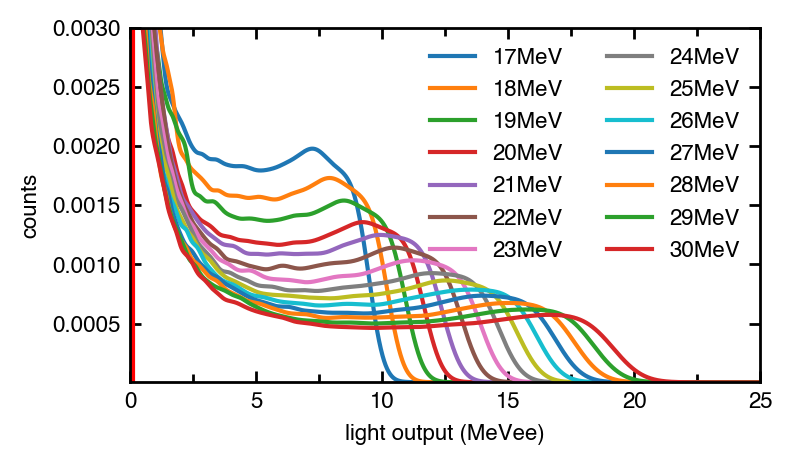

In [89]:
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

response_x, response_y = sorting(tri_g_rec_n_LO_data['Rec_LO'],300,0,30)
#plt.plot(response_x, response_y,'b',label='measurement')
plt.axvline(0.125,color=r'r')
for i in np.arange(1,len(neutron_response[0,:]),1):
    plt.plot(neutron_response[:,0],neutron_response[:,i],label= str(int(16+i))+ 'MeV')
#plt.yscale('log')

fig_post_def(xlim =(0,25),xticks=(5,2.5),ylim = (0.000004,0.003)
             ,lg_fs = 8
             ,xlabel = 'light output (MeVee)',ylabel = 'counts')
plt.legend(fontsize=8,ncol=2,frameon= False)

In [90]:
def interpolation_function(data_x,data_y,new_x):
    new_y = interp1d(data_x, data_y,fill_value="extrapolate")(new_x)
    return new_y

In [91]:
print(neutron_response[:,0])

[0.000e+00 1.000e-02 2.000e-02 ... 2.998e+01 2.999e+01 3.000e+01]


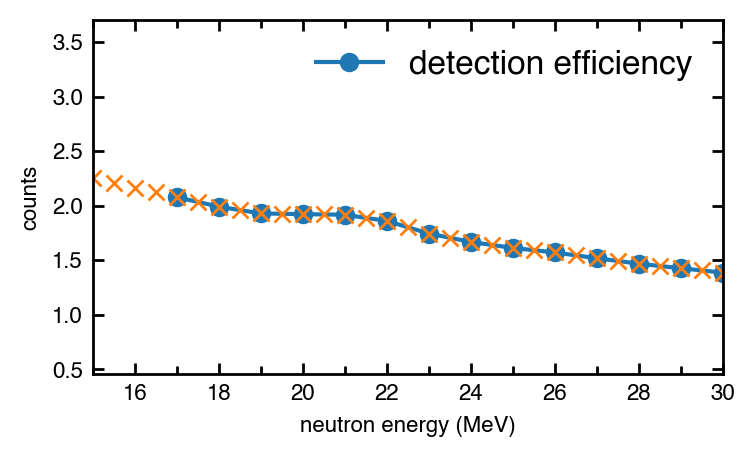

In [92]:
response_eff = [] 
for i in np.arange(1,len(neutron_response[0,:]),1):
    response_eff = np.append(response_eff,sum(neutron_response[15:,i]))
response_eff_x= np.arange(17,31,1)

fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 


plt.plot(response_eff_x,response_eff,'-o',label = 'detection efficiency')
response_eff_x_interp = np.arange(0,50,0.5)
response_eff_interp   = interpolation_function(response_eff_x,response_eff,response_eff_x_interp)
#response_eff_interp[:34]=0
#response_eff_interp[61:]=0
plt.plot(response_eff_x_interp,response_eff_interp,'x')

fig_post_def(xlim =(15,30),xticks=(2,1)#,ylim = (0,0.4)
             ,lg_fs = 12
             ,xlabel = 'neutron energy (MeV)',ylabel = 'counts')

#plt.plot(Neutron_E_axis, Neutron_E_y/25,'x')

NameError: name 'accumulate_x_energy_sum' is not defined

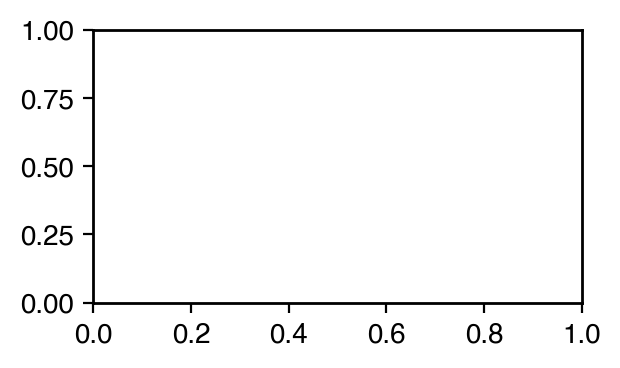

In [93]:
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 


calibrated_n_spectrum =[]
for i in np.arange(0,len(accumulate_g_n),1):
    if response_eff_interp[i]<=0.001:
        calibrated_n_spectrum = np.append(calibrated_n_spectrum,0)
    else :
        calibrated_n_spectrum = np.append(calibrated_n_spectrum,(accumulate_g_n[i]-100)/ response_eff_interp[i])

plt.plot(accumulate_x_energy_sum,calibrated_n_spectrum,'.-b',label='calibrated spectrum')
plt.plot(0.25+INER_QMN_bar_x,0.3*accumulate_g_n.max()*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5 cm')
#plt.plot(bar_x,2.8*bar_y,'r' ,label ='merge all period')
#plt.plot(0.25+INER_QMN_bar_x,2.8*Neutron_E_y.max()*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5 cm')
fig_post_def(xlim =(17,30),xticks=(2,1),ylim = (0,400),yticks=(100,50)
             ,lg_fs = 8
             ,xlabel = 'neutron energy (MeV)',ylabel = 'counts')

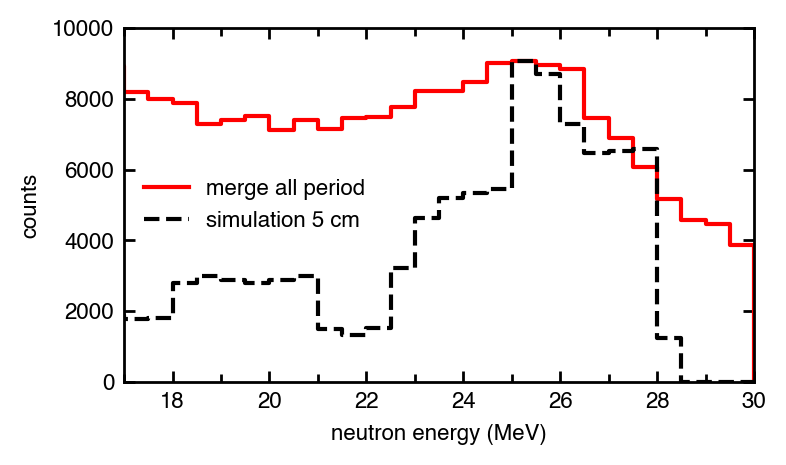

In [94]:
fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 


calibrated_n_spectrum =[]
for i in np.arange(0,len(Neutron_E_y),1):
    if response_eff_interp[i]<=0.001:
        calibrated_n_spectrum = np.append(calibrated_n_spectrum,0)
    else :
        calibrated_n_spectrum = np.append(calibrated_n_spectrum,Neutron_E_y[i]/ response_eff_interp[i])

#plt.plot(response_eff_x_interp,calibrated_n_spectrum,'-o',label='calibrated spectrum')
plt.plot(bar_x,2.8*bar_y,'r' ,label ='merge all period')
plt.plot(0.25+INER_QMN_bar_x,2.8*Neutron_E_y.max()*INER_QMN_bar_y/INER_QMN_bar_y[30:].max(),'--k',label = 'simulation 5 cm')
fig_post_def(xlim =(17,30),xticks=(2,1),ylim = (0,10000)
             ,lg_fs = 8
             ,xlabel = 'neutron energy (MeV)',ylabel = 'counts')

In [95]:
threshold =200
peaks, _ = find_peaks(hist_tri_g_rec_g, height=threshold, distance =20)
print(peaks/2)

[313.5 327.5 341.  354.5 368.5 382.  395.5 409.5 423.  437.  450.5 464.
 477.5 491.5 505.  519.  532.5 546.  560.  573.5 587.5 601.  614.5 628.5
 642.  655.5 669.  683.  696. ]


In [96]:
demo_hist_tri_g_rec_g = hist_tri_g_rec_g.copy()
demo_hist_tri_g_rec_g[30:] = demo_hist_tri_g_rec_g[39]
demo_hist_tri_g_rec_n= hist_tri_g_rec_n.copy()
demo_hist_tri_g_rec_n = demo_hist_tri_g_rec_n+demo_hist_tri_g_rec_n

demo_hist_tri_g_rec_n_x = np.array([38,38.5,40,43,46,50,60,70,80,90,120,130])
demo_hist_tri_g_rec_n   = np.array([0, 50,100,200,210,220,180,160,150,90,80,50])
def interpolation_function(data_x,data_y,new_x):
    new_y = interp1d(data_x, data_y,fill_value="extrapolate")(new_x)
    return new_y
from scipy.signal import savgol_filter
demo_hist_tri_g_rec_n_2 = interpolation_function(demo_hist_tri_g_rec_n_x,demo_hist_tri_g_rec_n,bin_center)
demo_hist_tri_g_rec_n_2_smoothed= savgol_filter(demo_hist_tri_g_rec_n_2, 101, 3) 

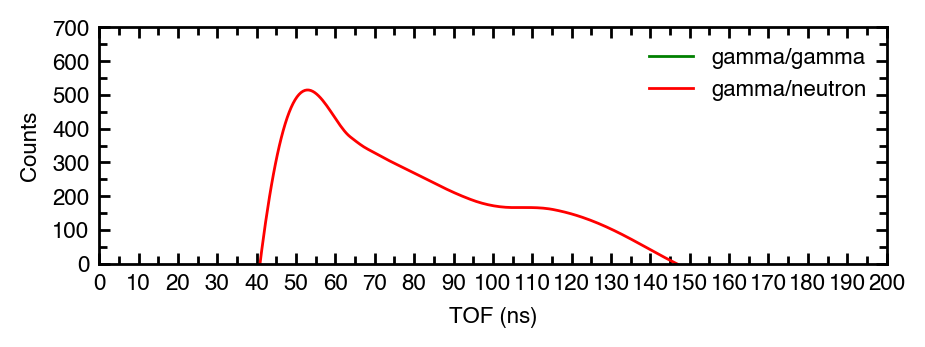

In [97]:
fig = fig_pre_def(10,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
#plt.plot(bin_center+time_calibration,hist_all,'k',linewidth=1,label ='All signals')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'c' ,linewidth=1,label ='neutron/neutron')
plt.plot(bin_center,demo_hist_tri_g_rec_g-50,'g' ,linewidth=1,label ='gamma/gamma')
plt.plot(bin_center,2*demo_hist_tri_g_rec_n_2_smoothed,'r' ,linewidth=1,label ='gamma/neutron')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma/high-energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron/gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(0,200),xticks=(10,5)
             ,ylim = (0,700),yticks=(100,50),lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

In [98]:
mask_Rec_n_PSD_upper  = proE_data['Rec_PSD'] < 0.6
mask_Rec_n_PSD_lower  = proE_data['Rec_PSD'] > 0.36
mask_Rec_g_PSD_upper  = proE_data['Rec_PSD'] < 0.36
mask_Rec_g_PSD_lower  = proE_data['Rec_PSD'] > 0.2

mask_Tri_n_PSD_upper  = proE_data['Tri_PSD'] < 0.6
mask_Tri_n_PSD_lower  = proE_data['Tri_PSD'] > 0.4
mask_Tri_g_PSD_upper  = proE_data['Tri_PSD'] < 0.36
mask_Tri_g_PSD_lower  = proE_data['Tri_PSD'] > 0.2

mask_LO_limit = proE_data['Rec_LO']>12.5

In [99]:
tri_n_rec_n_data   = proE_data[(mask_Tri_n_PSD_upper&mask_Tri_n_PSD_lower&mask_Rec_PSD_upper&mask_Rec_PSD_lower)]
tri_g_rec_g_data   = proE_data[( mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower&mask_Rec_g_PSD_upper&mask_Rec_g_PSD_lower)]
tri_g_rec_n_data   = proE_data[(mask_LO_limit& 
                                mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower&mask_Rec_PSD_upper&mask_Rec_PSD_lower)]
tri_n_rec_g_data   = proE_data[(mask_Rec_LO&mask_Tri_n_PSD_upper&mask_Tri_n_PSD_lower&mask_Rec_g_PSD_upper&mask_Rec_g_PSD_lower)]
tri_g_rec_All_data = proE_data[(mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower)]
tri_n_rec_All_data = proE_data[(mask_Rec_LO&mask_Tri_n_PSD_upper&mask_Tri_n_PSD_lower)]

tri_g_rec_n_LO_data   = proE_data[(mask_LO_limit& 
                                mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower&mask_Rec_PSD_upper&mask_Rec_PSD_lower)]

hist_bin   = 800
hist_lower = 0
hist_upper = 400

bin_center, hist_all           = sorting(proE_data['TOF'],hist_bin,hist_lower,hist_upper)
#bin_center, hist_tri_All_rec_n       = sorting(pro_data['time_diff'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_n       = sorting(tri_n_rec_n_data['TOF'],hist_bin,hist_lower,hist_upper)

bin_center, hist_tri_g_rec_g   = sorting(tri_g_rec_g_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_g_rec_n   = sorting(tri_g_rec_n_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_g   = sorting(tri_n_rec_g_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_g_rec_all = sorting(tri_g_rec_All_data['TOF'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_all = sorting(tri_n_rec_All_data['TOF'],hist_bin,hist_lower,hist_upper)


bin_center, hist_tri_g_rec_n_LO = sorting(tri_g_rec_n_LO_data['TOF'],hist_bin,hist_lower,hist_upper)

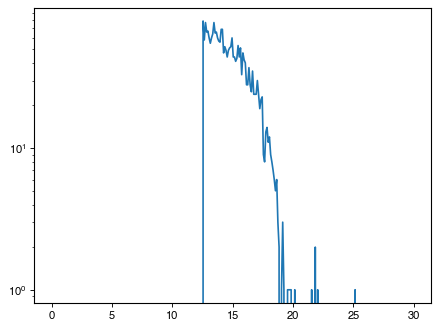

In [100]:
response_x, response_y = sorting(tri_g_rec_n_LO_data['Rec_LO'],300,0,30)
plt.plot(response_x, response_y)
plt.yscale('log')

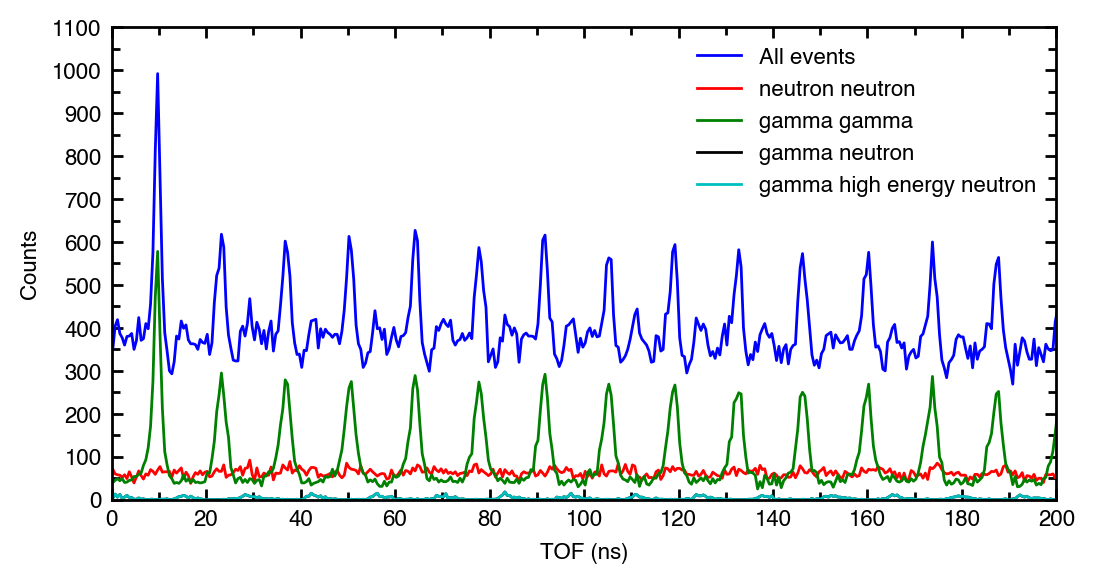

In [101]:
fig = fig_pre_def(12,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
plt.plot(bin_center+time_calibration,hist_all,'b',linewidth=1,label ='All events')
plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'r' ,linewidth=1,label ='neutron neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'k' ,linewidth=1,label ='gamma neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n_LO,'c' ,linewidth=1,label ='gamma high energy neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(0,200),xticks=(20,10)
             ,ylim = (0,1100),yticks=(100,50),lg_fs=8,xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

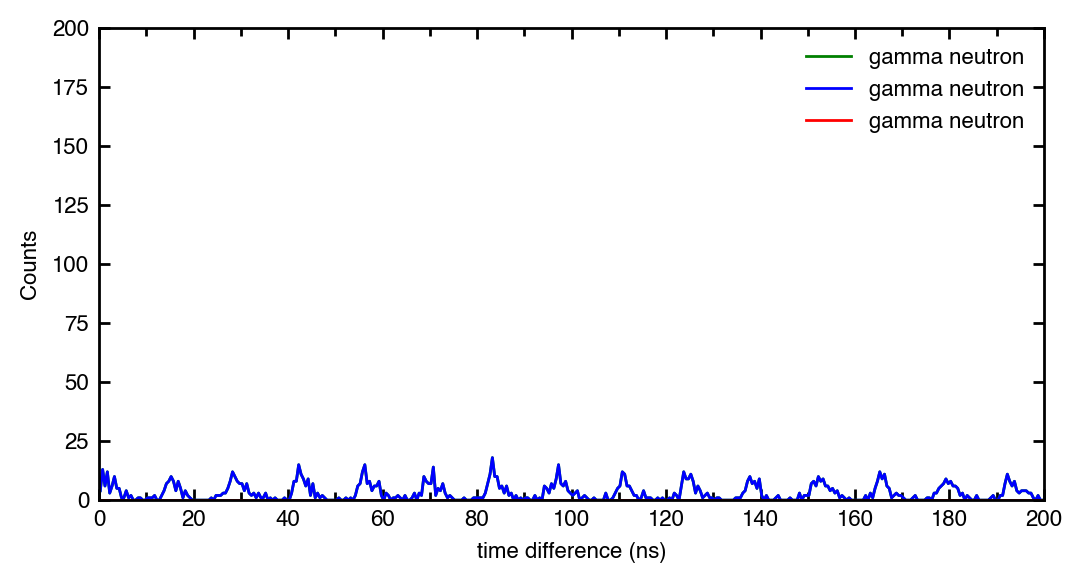

In [102]:
fig = fig_pre_def(12,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = 0
plt.plot(bin_center,hist_tri_g_rec_n,'g' ,linewidth=1,label ='gamma neutron')
plt.plot(bin_center,hist_tri_g_rec_n_LO,'b' ,linewidth=1,label ='gamma neutron')
plt.plot(bin_center,hist_tri_g_rec_n-hist_tri_g_rec_n_LO,'r' ,linewidth=1,label ='gamma neutron')


fig_post_def(xlim =(0,200),xticks=(20,10)
             ,ylim = (0,200),lg_fs=8,xlabel = 'time difference (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

(0.0, 100.0)

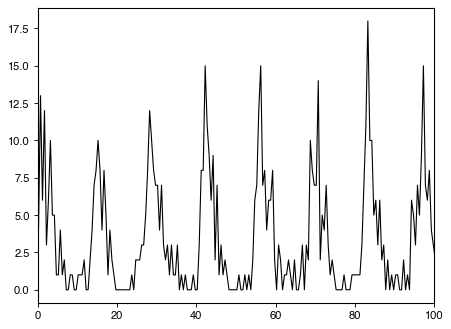

In [103]:
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'k' ,linewidth=1,label ='gamma neutron')
plt.xlim(0,100)

In [104]:
threshold =200
peaks, _ = find_peaks(hist_tri_g_rec_g, height=threshold, distance =20)
print(peaks/2)

[  9.5  23.   36.5  50.5  64.   77.5  91.5 105.  119.  132.5 146.  160.
 173.5 187.5 201.  214.5 228.5 242.  255.5 269.  283.  296. ]


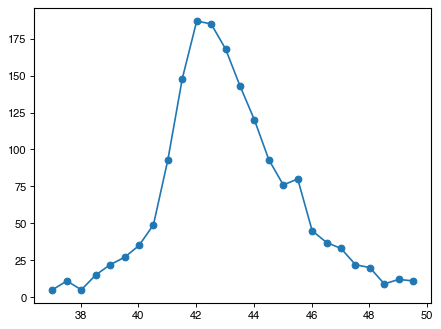

In [105]:
accumulate_g_n=np.zeros(26)
for i in np.arange(0,len(peaks)-2,1):
    accumulate_g_n += hist_tri_g_rec_n[peaks[i]:peaks[i]+26]

accumulate_x = np.arange(0,13,0.5)+9.5+13.76*2
plt.plot(accumulate_x,accumulate_g_n,'o-')

In [106]:
accumulate_x_energy = g_Time_to_energy(accumulate_x)


fig = fig_pre_def(8,4.5)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
plt.bar(accumulate_x_energy,accumulate_g_n,width=0.2,label ='neutron')
fig_post_def(xlim =(15,35),xticks=(5,1)
             ,ylim = (0,400),yticks=(100,50),lg_fs=8,xlabel = 'energy (MeV)',ylabel = 'Counts',title = ' 100 nA\naccumulate data')

NameError: name 'g_Time_to_energy' is not defined

In [107]:

tri_g_rec_n_data_RF = tri_g_rec_n_data.copy(deep=True)
tri_g_rec_n_data_RF["RF_TOF"] = tri_g_rec_n_data["TOF"].apply(lambda x:((x-9.5)%13.67)+9.5+13.76*2)
tri_g_rec_n_data_RF["RF_TOF_E"] = g_Time_to_energy(np.round(tri_g_rec_n_data_RF['RF_TOF']/resolution_time)*resolution_time  )

bin_center, hist_tri_g_rec_n_data_RF = sorting(tri_g_rec_n_data_RF['RF_TOF'],hist_bin,hist_lower,hist_upper)
plt.plot(bin_center, hist_tri_g_rec_n_data_RF)
plt.xlim(0,100)

NameError: name 'g_Time_to_energy' is not defined

In [108]:
response_x,response_y = sorting(tri_g_rec_n_data_RF["RF_TOF_E"],80,0,40)
plt.bar(response_x,response_y,width=0.2)

KeyError: 'RF_TOF_E'

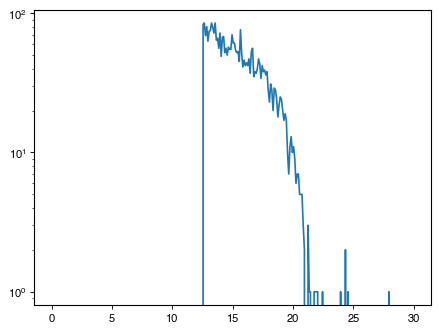

In [ ]:
response_x,response_y = sorting(tri_g_rec_n_data_RF["Rec_LO"],300,0,30)
plt.plot(response_x,response_y)
plt.yscale('log')

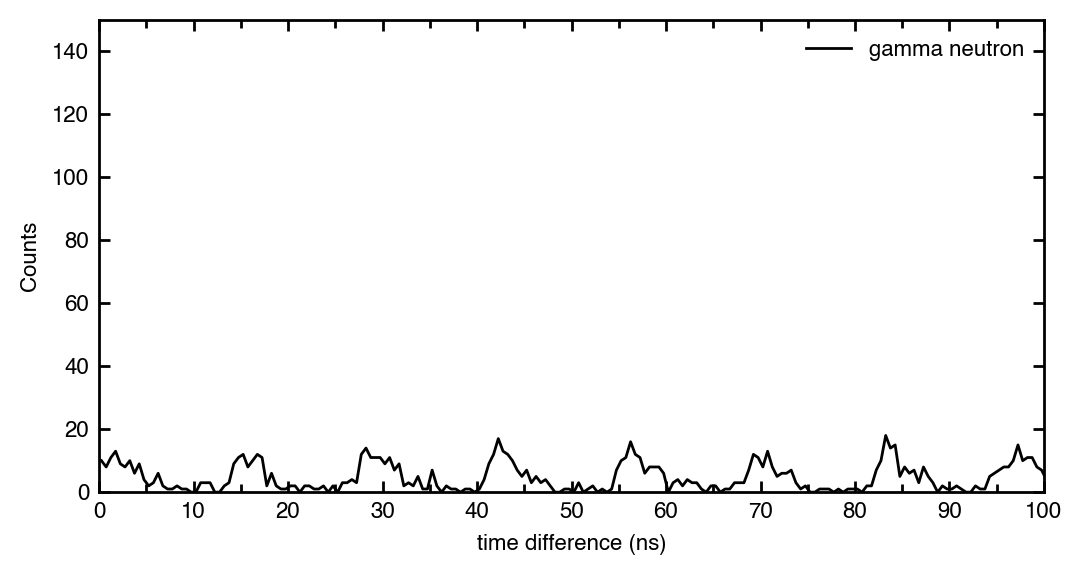

In [ ]:
fig = fig_pre_def(12,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
hist_tri_g_rec_n_subtracted = hist_tri_g_rec_n- hist_tri_g_rec_n[100]
plt.plot(bin_center,hist_tri_g_rec_n_subtracted,'k' ,linewidth=1,label ='gamma neutron')
fig_post_def(xlim =(0,100),xticks=(10,5)
             ,ylim = (0,150),lg_fs=8,xlabel = 'time difference (ns)',ylabel = 'Counts')

In [109]:
hist_tri_g_rec_n_subtracted[:2*38]=0
hist_tri_g_rec_n_subtracted[106:]=0
hist_tri_g_rec_n_subtracted[hist_tri_g_rec_n_subtracted<0]=0
plt.plot(bin_center,hist_tri_g_rec_n_subtracted,'k' ,linewidth=1,label ='gamma neutron')
plt.xlim(30,50)

NameError: name 'hist_tri_g_rec_n_subtracted' is not defined

In [110]:
bin_energy = g_Time_to_energy(bin_center[2*30:])
#plt.plot(bin_energy,hist_tri_g_rec_n_subtracted[2*30:],'k' ,linewidth=1,label ='gamma neutron')


fig = fig_pre_def(8,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
plt.bar(bin_energy,hist_tri_g_rec_n_subtracted[2*30:],label='neutron',width =0.2)
fig_post_def(xlim =(15,35),xticks=(5,1)
             ,ylim = (0,25),lg_fs=8,xlabel = 'energy (MeV)',ylabel = 'Counts',title = '100 nA')

NameError: name 'g_Time_to_energy' is not defined

In [111]:
bin_energy = g_Time_to_energy(bin_center[2*30:])

fig = fig_pre_def(8,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 





#plt.plot(bin_energy,hist_tri_g_rec_n_subtracted,'k' ,linewidth=1,label ='gamma neutron')
fig_post_def(xlim =(15,35),xticks=(5,2.5)
             ,ylim = (0,25)
             ,lg_fs=8,xlabel = 'time difference (ns)',ylabel = 'Counts')

NameError: name 'g_Time_to_energy' is not defined

       time_diff   Rec_PSD    Rec_LO  Tri_Det   Tri_PSD   Tri_LO        TOF  \
1109      49.242  0.380538  12.57116      4.0  0.341982  3.46985  42.925872   
2993      48.189  0.405004  14.74410      4.0  0.301587  2.16195  41.872872   
9667      49.573  0.380694  15.36052      4.0  0.200617  0.53070  43.256872   
10982     50.608  0.494609  17.43826      4.0  0.355201  1.60805  44.291872   
12651     52.481  0.389839  13.91348      6.0  0.334433  2.69700  46.164872   

           Rec_E  
1109   25.822466  
2993   27.197415  
9667   25.413653  
10982  24.192210  
12651  22.200203  


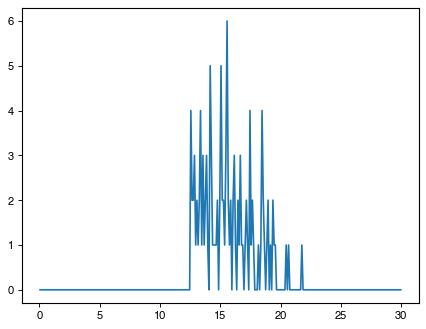

In [1024]:
mask_time_lower = tri_g_rec_n_data['TOF']>38.5
mask_time_upper = tri_g_rec_n_data['TOF']<50
mask_LO_limit = tri_g_rec_n_data['Rec_LO']>5
tri_g_rec_n_data_ROI = tri_g_rec_n_data[(mask_time_lower & mask_time_upper&mask_LO_limit)]
response_x,response_y = sorting(tri_g_rec_n_data_ROI['Rec_LO'],300,0,30)
print(tri_g_rec_n_data_ROI.head())
plt.plot(response_x,response_y )

In [1025]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 50 # 10 MeV
Binning = 100 # cut to 100 pieces
Neutron_E_axis, Neutron_E_y = sorting(
    tri_g_rec_n_data_ROI['Rec_E'], Binning , Neutron_energy_lower, Neutron_energy_upper)

In [1026]:
def bar_plot(input_x,input_y,binning):
    xs = [input_x[0] - binning/2]
    ys = [0]
    for i in range(len(input_x)):
        xs.append(input_x[i] - binning/2)
        xs.append(input_x[i] + binning/2)
        ys.append(input_y[i])
        ys.append(input_y[i])
    xs.append(input_x[-1] + binning/2)
    ys.append(0)
    return np.array(xs),np.array(ys)

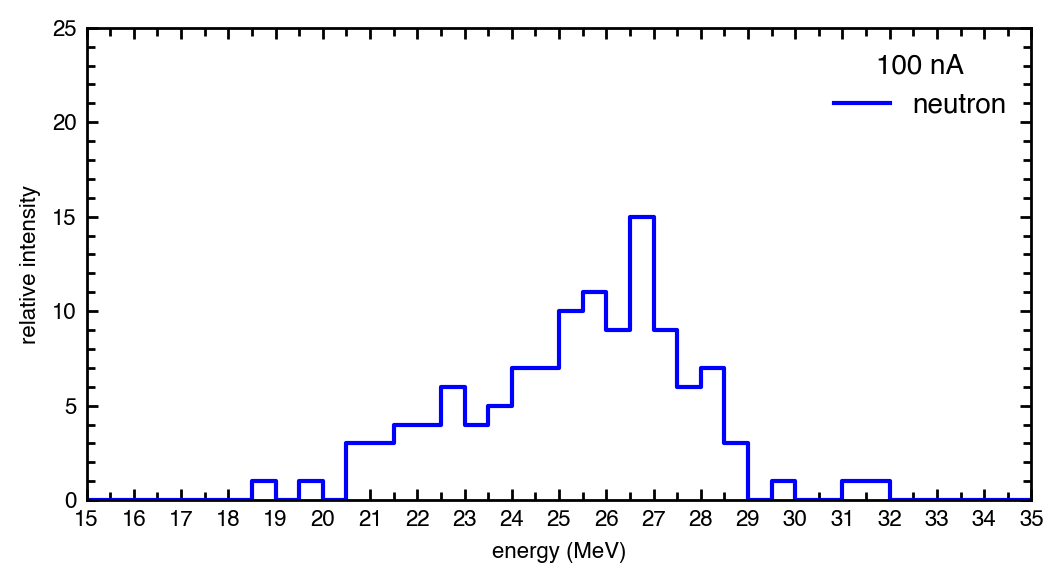

In [1027]:

fig = fig_pre_def(12,6) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


bar_x,bar_y = bar_plot(Neutron_E_axis, Neutron_E_y ,0.5)
plt.plot(bar_x,bar_y,'b' ,label ='neutron')

ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(15,35),ylim=(0,25),xticks=(1,0.5),yticks=(5,1),title='100 nA',lg_fs = 10,xlabel='energy (MeV)',ylabel='relative intensity')
#plt.legend(fontsize=18)


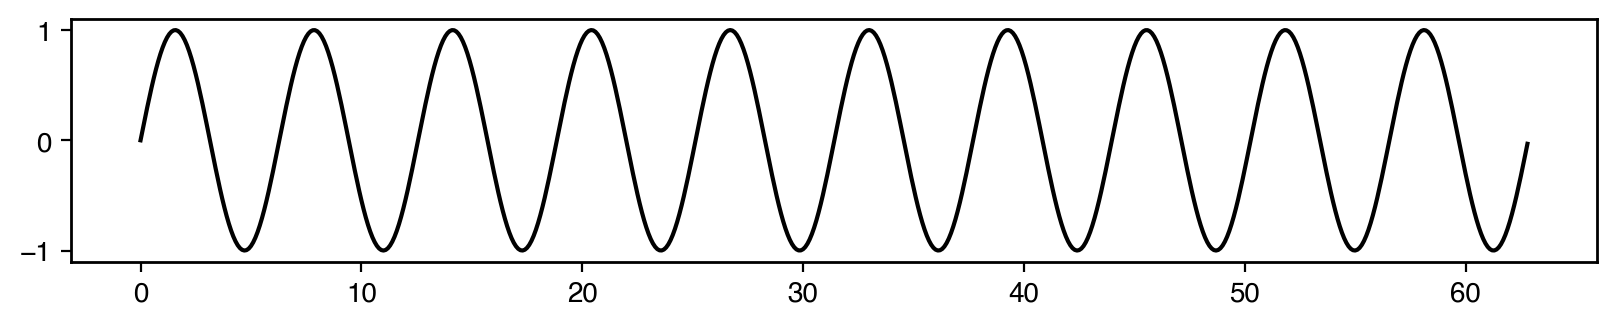

In [1039]:

fig = fig_pre_def(25,4) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

# Generate data
x = np.arange(0, 20*np.pi, 0.1)
y = np.sin(x)

# Plot the sine wave
ax.plot(x, y,'k')

# Set the x and y axis labels
#plt.xlabel('x-axis')
#plt.ylabel('y-axis')

# Set the plot title
#plt.title('Sine Wave')

# Display the plot
plt.savefig('sine_wave.svg', format="svg")


In [1040]:
1/73.129

0.013674465670253934

In [329]:
mask_Rec_n_PSD_upper  = proE_data['Rec_PSD'] < 0.6
mask_Rec_n_PSD_lower  = proE_data['Rec_PSD'] > 0.36
response_rec = proE_data[(mask_Rec_n_PSD_upper&mask_Rec_n_PSD_lower)]
response_x,response_y = sorting(response_rec['Rec_LO'],300,0,30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/qd/hhwc9gc95fv6tx8vycl4f3bm0000gn/T/ipykernel_30833/3126395115.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,100000)


(1.0, 100000)

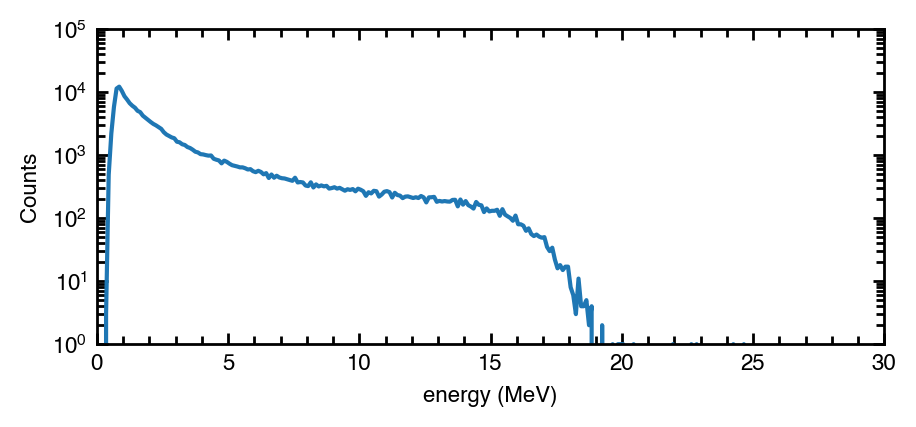

In [330]:



fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
plt.plot(response_x,response_y )
fig_post_def(xlim =(0,30)
             #,ylim = (10,300)
             ,xticks=(5,1)#,yticks=(100,50)
             ,xlabel = 'energy (MeV)',ylabel = 'Counts')
plt.yscale('log')
plt.ylim(0,100000)

In [287]:
pro_T_data = pro_data_all[(mask_Rec_LO 
                        #&mask_Rec_PSD_upper
                        #&mask_Rec_PSD_lower
                        &mask_Tri_g_PSD_upper
                        &mask_Tri_g_PSD_lower)]
print(pro_T_data.head())

   time_diff   Rec_PSD   Rec_LO  Tri_Det   Tri_PSD   Tri_LO
2    278.165  0.365314   0.7588      4.0  0.372197  0.38425
3    192.340  0.460648   0.6048      6.0  0.302831  3.80045
5     75.051  0.396496  11.1860      4.0  0.306701  0.62350
7    248.001  0.342925   2.9680      6.0  0.329215  2.05610
8    287.040  0.400336   3.3292      4.0  0.306376  1.92560


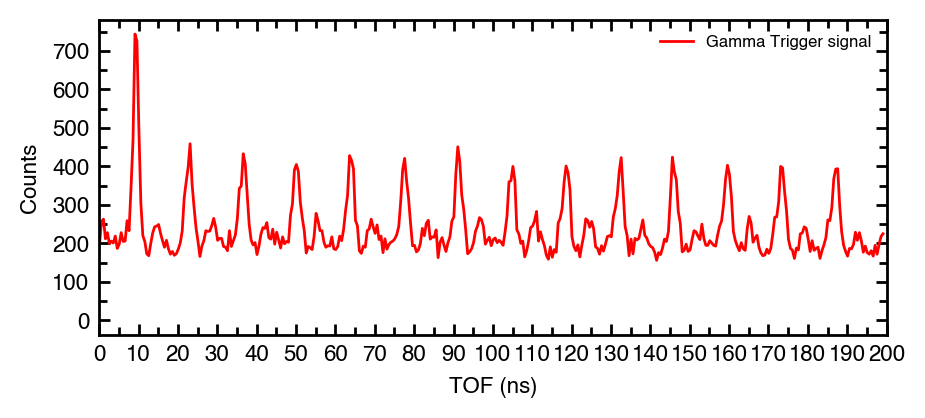

In [289]:
bin_center_g,hist_gamma_g = sorting(pro_gT_data['g_TOF'],800,-200,200)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

#plt.plot(bin_center,hist_gamma,'b' ,linewidth=1,label ='All')
plt.plot(bin_center_g-gamma_to_trigger,hist_gamma_g,'r' ,linewidth=1,label ='Gamma Trigger signal')
fig_post_def(xlim =(0,200)
             #,ylim = (10,300)
             ,xticks=(10,5),yticks=(100,50),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,5500)
#plt.yscale('log')

[201 227 255 283 310 337 364 392 419 447 474 501 528 556 583 611 638 666
 692 720 747 776]
[-99.91712817 -86.91712817 -72.91712817 -58.91712817 -45.41712817
 -31.91712817 -18.41712817  -4.41712817   9.08287183  23.08287183
  36.58287183  50.08287183  63.58287183  77.58287183  91.08287183
 105.08287183 118.58287183 132.58287183 145.58287183 159.58287183
 173.08287183 187.58287183]
[13.0, 14.0, 14.0, 13.5, 13.500000000000004, 13.5, 14.0, 13.5, 14.0, 13.499999999999996, 13.5, 13.5, 14.0, 13.5, 14.0, 13.5, 14.0, 13.0, 14.0, 13.5, 14.5]


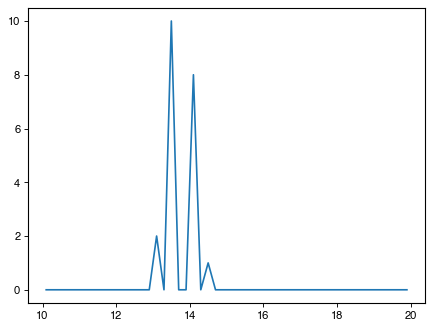

In [290]:

# Set the threshold
threshold = 100

# Find the peaks
peaks, _ = find_peaks(hist_gamma_g, height=threshold, distance =20)
# Print the peak indices
print(peaks)
peaks_time = bin_center_g[peaks]-gamma_to_trigger
print(peaks_time)
peaks_time_difference=[]
for i in np.arange(0,len(peaks_time)-1,1):
    peaks_time_difference.append(peaks_time[i+1]-peaks_time[i])
print(peaks_time_difference)
bin_center_peak_t_diff,hist_peak_t_diff = sorting(peaks_time_difference,50,10,20)
plt.plot(bin_center_peak_t_diff,hist_peak_t_diff)

In [291]:
source_to_main_detector=3
def g_Time_to_energy(TOF):
    distance = source_to_main_detector+1.5*0.0254 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    if type(TOF).__module__ == np.__name__:
        #print(type(TOF))
        if TOF.any()==0:
            return 0
        else:
            beta= distance/(light_speed*TOF*10**-9)
            neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
            return neutron_energy
    else:
        beta= distance/(light_speed*TOF*10**-9)
        neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
        return neutron_energy
def energy_to_time_3m(E):
    distance = 3 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    TOF = distance/((2*E*(1.6*10**-19)*(10**6)/neutron_mass)**0.5)*10**9 #ns
    return TOF
def energy_to_speed(E):
    neutron_mass = 1.64749*10**-27 #kg
    speed = ((2*E*(1.6*10**-19)*(10**6)/neutron_mass)**0.5)/10**9 #ns
    return speed #m

In [292]:
energy_to_time_3m(2)

152.20981612563625

In [293]:
print(energy_to_speed(80)*100)
print(energy_to_speed(5)*100)


12.46546802562926
3.116367006407315


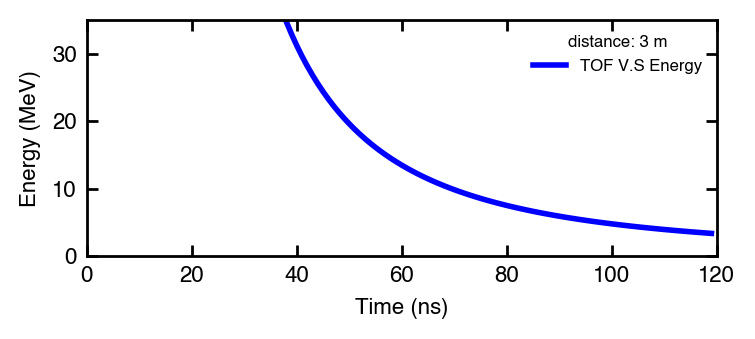

In [295]:
time_along= np.arange(20,120,1)
E_along = g_Time_to_energy(time_along)

fig = fig_pre_def(8,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111

#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(time_along,E_along,'b',linewidth =2,label = 'TOF V.S Energy')

fig_post_def(xlim=(0,120),ylim=(0,35), xlabel ='Time (ns)',ylabel = 'Energy (MeV)',title="distance: 3 m")


In [296]:
resolution_time=0.002

mask_pro_gT_time_lower = pro_gT_data["time_diff"]>20
mask_pro_gT_time_upper = pro_gT_data["time_diff"]<110
mask_pro_gT_Threshold_Rec = pro_gT_data["Rec_LO"]>0.0
mask_pro_gT_Threshold_Tri = pro_gT_data["Tri_LO"]>0.0
pro_g_T2_data = pro_gT_data[(mask_pro_gT_time_lower&mask_pro_gT_time_upper&mask_pro_gT_Threshold_Rec&mask_pro_gT_Threshold_Tri)]
pro_g_TE_data = pro_g_T2_data.copy()
pro_g_TE_data['g_E'] = g_Time_to_energy(np.round(pro_g_TE_data['g_TOF']/resolution_time)*resolution_time  )
print(pro_g_TE_data.head())

    time_diff   Rec_PSD   Rec_LO  Tri_Det   Tri_PSD   Tri_LO     g_TOF  \
5      75.051  0.396496  11.1860      4.0  0.306701  0.62350  68.93501   
9      90.958  0.459610   0.5026      6.0  0.291294  1.84295  84.84201   
19     87.892  0.464373   0.5698      4.0  0.317105  1.16290  81.77601   
25     83.820  0.421368   1.6380      4.0  0.317747  3.99910  77.70401   
36     98.547  0.350427   3.2760      6.0  0.292428  2.28230  92.43101   

          g_E  
5   10.164700  
9    6.673182  
19   7.188908  
25   7.972123  
36   5.612667  


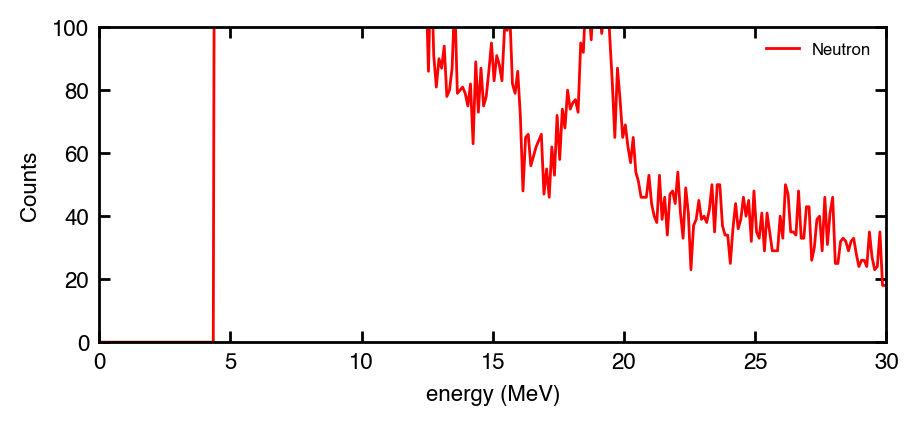

In [297]:
bin_center,hist_g_E = sorting(pro_g_TE_data['g_E'],300,0,30)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_g_E,'r' ,linewidth=1,label ='Neutron')
fig_post_def(xlim =(0,30),ylim = (0,100),xlabel = 'energy (MeV)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.yscale('log')

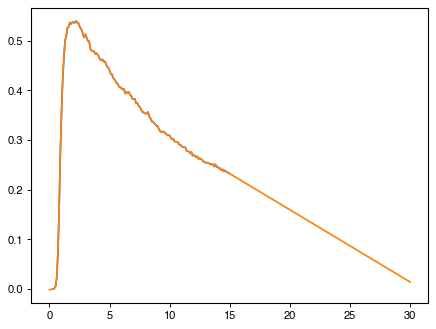

In [298]:
rec_eff = np.loadtxt('20220211_efficiency.txt')
plt.plot(rec_eff[:,0],rec_eff[:,1])
Neutron_E_x_axis = np.arange(0,30,0.01)
efficiency_y = interpolation_function(rec_eff[:,0],rec_eff[:,1],Neutron_E_x_axis)
plt.plot(Neutron_E_x_axis,efficiency_y)

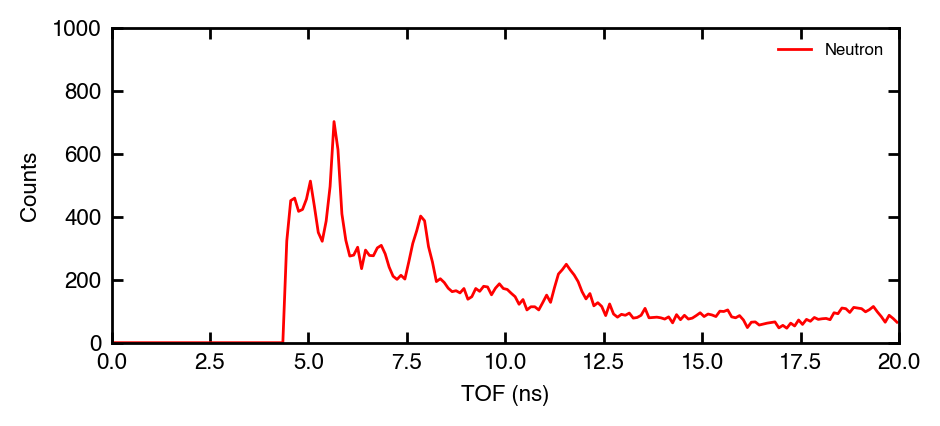

In [299]:
bin_center,hist_g_E = sorting(pro_g_TE_data['g_E'],200,0,20)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_g_E,'r' ,linewidth=1,label ='Neutron')
fig_post_def(xlim =(0,20),ylim = (0,1000),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.yscale('log')

In [300]:
#Signal processing
print(raw_data.shape)
mask_Tri_Ch4        = raw_data['Tri_Det']==4
mask_Rec_LO         = raw_data['Rec_LO']<16000*Rec_Ch_To_LO
mask_Rec_PSD_upper  = raw_data['Rec_PSD'] < 0.6
mask_Rec_PSD_lower  = raw_data['Rec_PSD'] > 0.38
mask_Tri_n_PSD_upper  = raw_data['Tri_PSD'] < 0.6
mask_Tri_n_PSD_lower  = raw_data['Tri_PSD'] > 0.38
mask_Tri_g_PSD_upper  = raw_data['Tri_PSD'] < 0.36
mask_Tri_g_PSD_lower  = raw_data['Tri_PSD'] > 0.2

#filter neutron in recording detector
pro_data = raw_data[(
                    #mask_Tri_Ch4 
                    mask_Rec_LO
                    & mask_Rec_PSD_upper
                    & mask_Rec_PSD_lower 
                    )] 

print(pro_data.shape)
print(pro_data.head())
#not filter neutron in recording detector
# just for time delay correction
pro_data_all = raw_data[(#mask_Tri_Ch4 
                        mask_Rec_LO)]



(313931, 6)
(158777, 6)
    time_diff   Rec_PSD   Rec_LO  Tri_Det   Tri_PSD   Tri_LO
3     192.340  0.460648   0.6048      6.0  0.302831  3.80045
5      75.051  0.396496  11.1860      4.0  0.306701  0.62350
8     287.040  0.400336   3.3292      4.0  0.306376  1.92560
9      90.958  0.459610   0.5026      6.0  0.291294  1.84295
10    166.547  0.446194   1.0668      4.0  0.478673  0.67280


## System delay correction

In [301]:
mask_Rec_g_PSD_upper = raw_data['Rec_PSD'] < 0.38
mask_Rec_g_PSD_lower = raw_data['Rec_PSD'] > 0.0
tri_n_rec_n_data = raw_data[(mask_Tri_n_PSD_upper&mask_Tri_n_PSD_lower&mask_Rec_PSD_upper&mask_Rec_PSD_lower)]
tri_g_rec_g_data = raw_data[( mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower&mask_Rec_g_PSD_upper&mask_Rec_g_PSD_lower)]
tri_g_rec_n_data = raw_data[( mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower&mask_Rec_PSD_upper&mask_Rec_PSD_lower)]
tri_n_rec_g_data = raw_data[(mask_Rec_LO&mask_Tri_n_PSD_upper&mask_Tri_n_PSD_lower&mask_Rec_g_PSD_upper&mask_Rec_g_PSD_lower)]
tri_g_rec_All_data = raw_data[(mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower)]
tri_n_rec_All_data = raw_data[(mask_Rec_LO&mask_Tri_n_PSD_upper&mask_Tri_n_PSD_lower)]

hist_bin   = 1600
hist_lower = -400
hist_upper = 400

bin_center, hist_all           = sorting(pro_data_all['time_diff'],hist_bin,hist_lower,hist_upper)
#bin_center, hist_tri_All_rec_n       = sorting(pro_data['time_diff'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_n       = sorting(tri_n_rec_n_data['time_diff'],hist_bin,hist_lower,hist_upper)

bin_center, hist_tri_g_rec_g   = sorting(tri_g_rec_g_data['time_diff'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_g_rec_n   = sorting(tri_g_rec_n_data['time_diff'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_g   = sorting(tri_n_rec_g_data['time_diff'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_g_rec_all = sorting(tri_g_rec_All_data['time_diff'],hist_bin,hist_lower,hist_upper)
bin_center, hist_tri_n_rec_all = sorting(tri_n_rec_All_data['time_diff'],hist_bin,hist_lower,hist_upper)

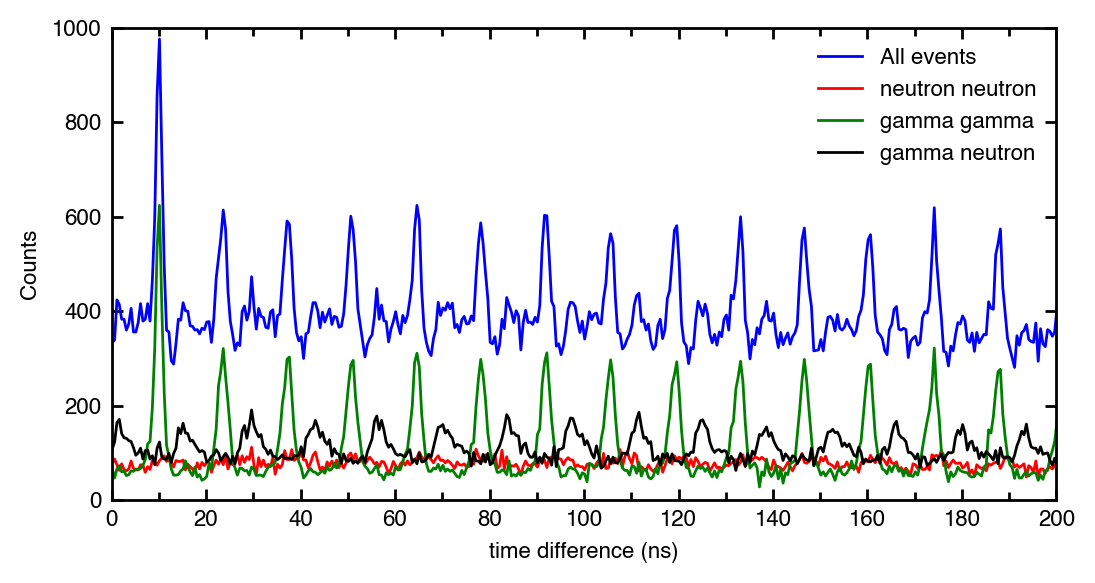

In [302]:
fig = fig_pre_def(12,6)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
time_calibration = -g_system_delay+gamma_to_trigger
plt.plot(bin_center+time_calibration,hist_all,'b',linewidth=1,label ='All events')
plt.plot(bin_center+time_calibration,hist_tri_n_rec_n,'r' ,linewidth=1,label ='neutron neutron')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_g,'g' ,linewidth=1,label ='gamma gamma')
plt.plot(bin_center+time_calibration,hist_tri_g_rec_n,'k' ,linewidth=1,label ='gamma neutron')
#plt.plot(bin_center+time_calibration,hist_tri_n_rec_g,color='orange' ,linewidth=1,label ='neutron gamma')
#plt.plot(bin_center+time_calibration,hist_tri_g_rec_all ,linewidth=1,label ='gamma all')
#plt.plot(bin_center,hist_tri_n_rec_all ,'c',linewidth=1,label ='neutron all')
fig_post_def(xlim =(0,200),xticks=(20,10)
             ,ylim = (0,1000),lg_fs=8,xlabel = 'time difference (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,2000)
#plt.yscale('log')

In [305]:
mask_time_lower = tri_g_rec_n_data['time_diff']>40
mask_time_upper = tri_g_rec_n_data['time_diff']<50

tri_g_rec_n_data_ROI = tri_g_rec_n_data[(mask_time_lower & mask_time_upper)]
print(tri_g_rec_n_data_ROI.head())

     time_diff   Rec_PSD  Rec_LO  Tri_Det   Tri_PSD   Tri_LO
50      42.185  0.432911  1.1060      6.0  0.314260  3.25380
66      42.126  0.432247  0.8162      4.0  0.272727  1.16145
163     43.799  0.382769  2.2750      6.0  0.330317  2.62450
171     49.518  0.522667  0.5250      4.0  0.309009  2.94205
387     43.657  0.422890  3.1682      4.0  0.285164  1.56600


In [ ]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 30 # 10 MeV
Binning = 300 # cut to 100 pieces
Neutron_E_axis, Neutron_E_y = sorting(
    proEEWeffTh_data['Total_E'], Binning , Neutron_energy_lower, Neutron_energy_upper)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


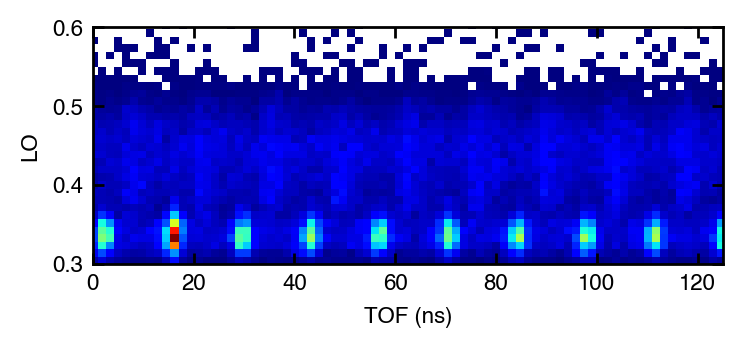

In [306]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(tri_g_rec_All_data['time_diff'],tri_g_rec_All_data['Rec_PSD'], bins=(400, 100),cmin=1, cmap=plt.cm.jet)

fig_post_def(xlim =(0,125),ylim = (0.3,0.6),xlabel = 'TOF (ns)',ylabel = 'LO')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


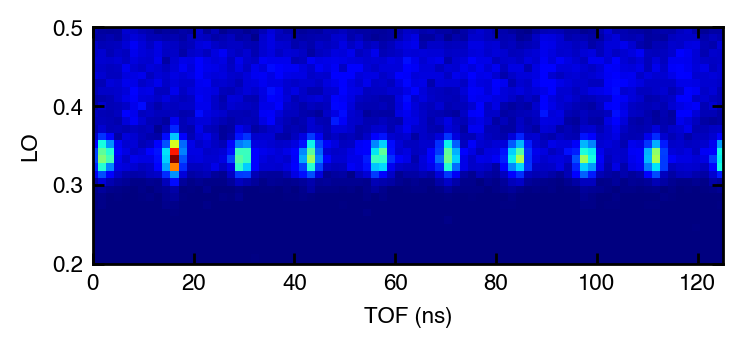

In [307]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(tri_g_rec_All_data['time_diff'],tri_g_rec_All_data['Rec_PSD'], bins=(400, 100),cmin=0, cmap=plt.cm.jet)

fig_post_def(xlim =(0,125),ylim = (0.2,0.5),xlabel = 'TOF (ns)',ylabel = 'LO')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


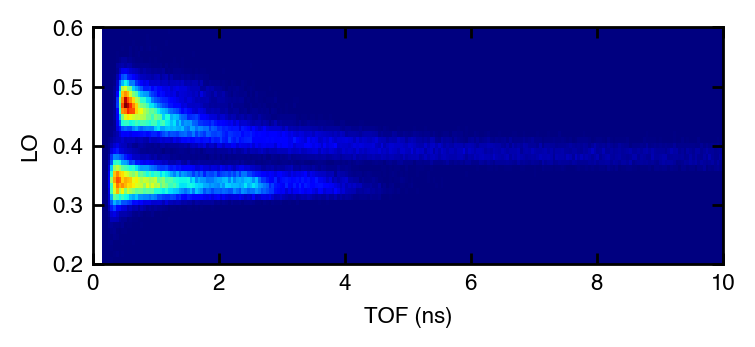

In [308]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(tri_g_rec_All_data['Rec_LO'],tri_g_rec_All_data['Rec_PSD'], bins=(400, 100),cmin=0, cmap=plt.cm.jet)

fig_post_def(xlim =(0,10),ylim = (0.2,0.6),xlabel = 'TOF (ns)',ylabel = 'LO')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


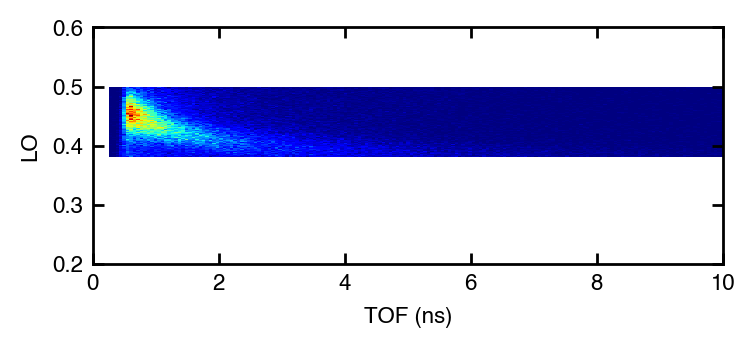

In [309]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(tri_n_rec_All_data['Tri_LO'],tri_n_rec_All_data['Tri_PSD'], bins=(400, 100),cmin=0, cmap=plt.cm.jet)

fig_post_def(xlim =(0,10),ylim = (0.2,0.6),xlabel = 'TOF (ns)',ylabel = 'LO')


In [310]:
start_point = 800
max_position = np.argmax(hist_tri_g_rec_g[start_point:])
measured_gamma_time_diff= bin_center[start_point+max_position]
print('measured gamma different time: ',measured_gamma_time_diff,' ns')

measured gamma different time:  16.25  ns


In [311]:
a=4
b=150+1.5*2.54
c=(a**2+b**2-b*a*(-0.5))**0.5
print(c)


154.85843890469772


In [312]:
start_point = 800
max_position = np.argmax(hist_tri_g_rec_g[start_point:])
measured_gamma_time_diff= bin_center[start_point+max_position]
print('measured gamma different time: ',measured_gamma_time_diff,' ns')

measured gamma different time:  16.25  ns


In [313]:
light_speed = 299792468 #m/s
nano_second = 10**(-9)  #s
experimental_gamma_different= ((source_to_main_detector+0.0254*1.5-source_to_trigger_detector)/light_speed)/nano_second#+0.0254*1.5-0.0254
print(experimental_gamma_different)

9.466882270037551


In [314]:
system_delay = measured_gamma_time_diff - experimental_gamma_different
print('system_delay  ',system_delay, '  ns')

system_delay   6.7831177299624485   ns


In [315]:
"""proT_data = pro_data.copy(deep=True)
proT_data['time_diff']-=system_delay
print(proT_data.head())"""

"proT_data = pro_data.copy(deep=True)\nproT_data['time_diff']-=system_delay\nprint(proT_data.head())"

In [316]:
proT_data = pro_data.copy(deep=True)
proT_data["TOF"] = proT_data["time_diff"].apply(lambda x:x-system_delay)
print(proT_data.head())

    time_diff   Rec_PSD   Rec_LO  Tri_Det   Tri_PSD   Tri_LO         TOF
3     192.340  0.460648   0.6048      6.0  0.302831  3.80045  185.556882
5      75.051  0.396496  11.1860      4.0  0.306701  0.62350   68.267882
8     287.040  0.400336   3.3292      4.0  0.306376  1.92560  280.256882
9      90.958  0.459610   0.5026      6.0  0.291294  1.84295   84.174882
10    166.547  0.446194   1.0668      4.0  0.478673  0.67280  159.763882


In [317]:
proT_data_all = pro_data_all.copy(deep=True)
proT_data_all["TOF"] = proT_data_all["time_diff"].apply(lambda x:x-system_delay)
print(proT_data_all.head())

   time_diff   Rec_PSD  Rec_LO  Tri_Det   Tri_PSD    Tri_LO         TOF
0      0.000  0.000000  0.0000      0.0  0.000000   0.06090   -6.783118
1    288.741  0.357513  0.5404      6.0  0.022444   0.64235  281.957882
2    278.165  0.365314  0.7588      4.0  0.372197   0.38425  271.381882
3    192.340  0.460648  0.6048      6.0  0.302831   3.80045  185.556882
4     67.556  0.338262  2.2722      4.0  0.404312  10.48640   60.772882


# Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


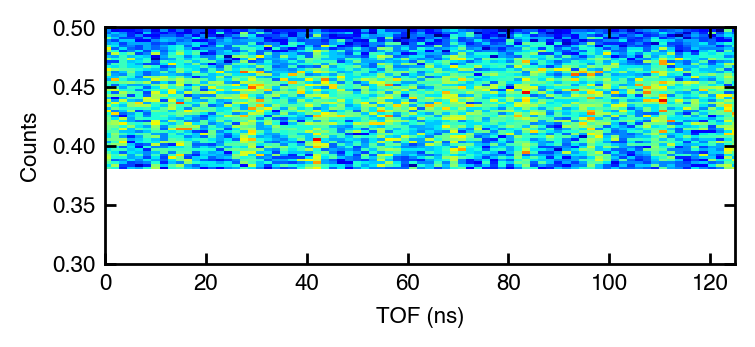

In [318]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(proT_data['TOF'],proT_data['Rec_PSD'], bins=(400, 100),cmin=0, cmap=plt.cm.jet)

fig_post_def(xlim =(0,125),ylim = (0.3,0.5),xlabel = 'TOF (ns)',ylabel = 'Counts')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


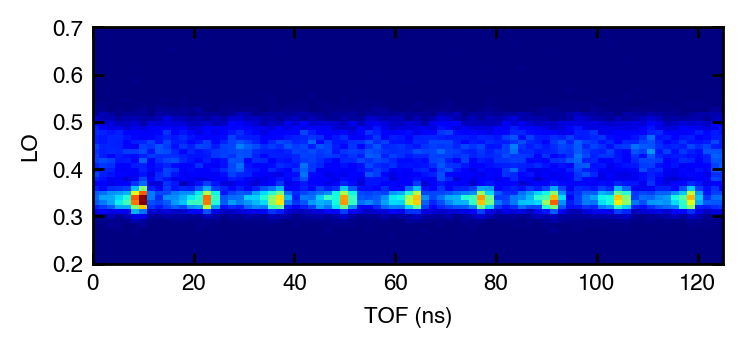

In [320]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(proT_data_all['TOF'],proT_data_all['Rec_PSD'], bins=(400, 100),cmin=0, cmap=plt.cm.jet)

fig_post_def(xlim =(0,125),ylim = (0.2,0.7),xlabel = 'TOF (ns)',ylabel = 'LO')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


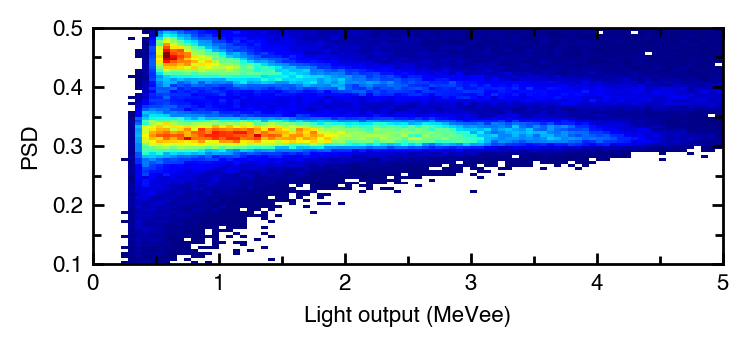

In [321]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(proT_data_all['Tri_LO'],proT_data_all['Tri_PSD'], bins=(400, 100),cmin=2, cmap=plt.cm.jet)

fig_post_def(xlim =(0,5),ylim = (0.1,0.5),xticks=(1,0.5),yticks=(0.1,0.05),xlabel = 'Light output (MeVee)',ylabel = 'PSD')


In [322]:
mask_Rec_g_PSD_upper = raw_data['Rec_PSD'] < 0.38
mask_Rec_g_PSD_lower = raw_data['Rec_PSD'] > 0
#rec_g_data = raw_data[(mask_Tri_Ch4 & mask_Rec_LO&mask_Tri_g_PSD_upper&mask_Tri_g_PSD_lower&mask_Rec_g_PSD_upper&mask_Rec_g_PSD_lower)]
bin_center, hist  = sorting(proT_data_all['time_diff'],1600,-400,400)
bin_center, hist_neutron = sorting(proT_data['time_diff'],1600,-400,400)
#bin_center, hist_gamma = sorting(rec_g_data['time_diff'],1600,-400,400)

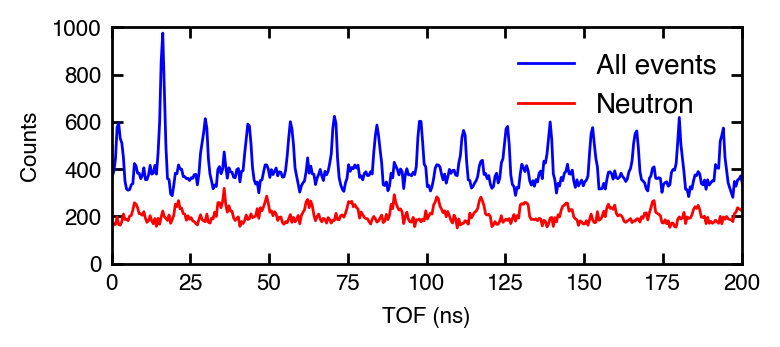

In [325]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist,'b',linewidth=1,label ='All events')
plt.plot(bin_center,hist_neutron,'r' ,linewidth=1,label ='Neutron')
#plt.plot(bin_center,hist_gamma,'g' ,linewidth=1,label ='gamma')
fig_post_def(xlim =(0,200),ylim = (0,1000),xlabel = 'TOF (ns)',ylabel = 'Counts',lg_fs=10)
#plt.xlim(-20,200)
#plt.ylim(1,)
#lt.yscale('log')

# Time to energy

In [ ]:
# Time to energy
def Time_to_energy(TOF):
    distance = source_to_main_detector+0.0254*1.5 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    if type(TOF).__module__ == np.__name__:
        #print(type(TOF))
        if TOF.any()==0:
            return 0
        else:
            beta= distance/(light_speed*TOF*10**-9)
            neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
            return neutron_energy
    else:
        beta= distance/(light_speed*TOF*10**-9)
        neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
        return neutron_energy


In [ ]:
time_along= np.arange(20,120,1)
E_along = Time_to_energy(time_along)

fig = fig_pre_def(8,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111

#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(time_along,E_along,'b',linewidth =2,label = 'TOF V.S Energy')

fig_post_def(xlim=(0,120),ylim=(0,35), xlabel ='Time (ns)',ylabel = 'Energy (MeV)',title="distance: 1.5 m")


In [ ]:
# Time to energy
def Time_to_energy_300(TOF):
    distance = 3 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    if type(TOF).__module__ == np.__name__:
        #print(type(TOF))
        if TOF.any()==0:
            return 0
        else:
            beta= distance/(light_speed*TOF*10**-9)
            neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
            return neutron_energy
    else:
        beta= distance/(light_speed*TOF*10**-9)
        neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
        return neutron_energy
def energy_to_time_300(E):
    distance = 3 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    TOF = distance/((2*E*(1.6*10**-19)*(10**6)/neutron_mass)**0.5)*10**9 #ns
    return TOF


In [ ]:
energy_to_time_300(30)

In [ ]:
time_along= np.arange(20,120,1)
E_along = Time_to_energy_300(time_along)

fig = fig_pre_def(8,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111

#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(time_along,E_along,'b',linewidth =2,label = 'TOF V.S Energy')

fig_post_def(xlim=(0,120),ylim=(0,35), xlabel ='Time (ns)',ylabel = 'Energy (MeV)',title="distance: 3 m")


In [ ]:
def E_resolution_fun(E):
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    gamma = 1+(E*(1.6*10**-19)*(10**6)/(neutron_mass*light_speed**2))
    #print(gamma)
    delta_T = 1 # ns
    TOF = energy_to_time_300(E)
    delta_E = E*gamma*(gamma+1)*(delta_T/TOF)
    return delta_E
    

In [ ]:
E_resolution_fun(30)

In [ ]:
E_along= np.arange(0,31,1)
delta_E_along = E_resolution_fun(E_along)

fig = fig_pre_def(8,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111

#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(E_along,delta_E_along,'b',linewidth =2,label = 'energy resolution')

fig_post_def(xlim=(0,30),ylim=(0,2), xlabel ='energy (MeV)',ylabel = 'Energy resolution (MeV)'
             ,title="distance: 3 m\ntime resolution: 1 ns",lg_fs=8)


In [ ]:
resolution_time =0.002 #ns

proE_data = proT_data.copy()
proE_data['Rec_E'] = Time_to_energy(np.round(proE_data['TOF']/resolution_time)*resolution_time  )

print(proE_data.head())

# Trigger LO to proton energy 
apply for all but only suitable for Trigger PSD:0.3-0.5

In [ ]:
def Light_output_exponential_method(E):
    A=0.62  #0.817
    B=1.3   #2.63
    C=0.39  #0.297
    D=0.97  #1
    LO =A*E-B*(1-np.exp(-1*C*E**D))
    return LO


In [ ]:
enegy_range= np.arange(0,30,0.0001)
lightoutput_2inches= Light_output_exponential_method(enegy_range)
print(lightoutput_2inches)

In [ ]:
LO_range= np.arange(0,30,0.00001)
P_Energy_inter = interpolation_function(lightoutput_2inches,enegy_range,LO_range)
plt.plot(LO_range,P_Energy_inter)

In [ ]:
fig = fig_pre_def(16,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 2, 1) 
ax.plot(enegy_range,lightoutput_2inches,label ='Exponential')
#ax.plot(P_Energy_inter,LO_range)
fig_post_def(xticks=(2,1),yticks=(2,1),ylabel ='Lightouput (MeVee)',xlabel = 'Recoil proton energy (MeV)',onefig=False)


#ax2 =fig.add_subplot(1, 2, 2) 
#ax2.plot(LO_range,P_Energy_inter)
#fig_post_def(xticks=(1,0.5),yticks=(1,0.5),xlabel ='Lightouput (MeVee)',ylabel = 'Recoil proton energy (MeV)',onefig=False)




In [ ]:
print(proE_data.head())

In [ ]:
proEE_data = proE_data.copy()
proEE_data["Recoil_p_E"] = proEE_data["Tri_LO"].apply(lambda x:P_Energy_inter[int(x*100000)])
proEE_data["Total_E"] = proEE_data["Rec_E"]+proEE_data["Recoil_p_E"]

print(proEE_data.head())

In [ ]:
rec_eff = np.loadtxt('20220211_efficiency.txt')
scatter_eff=np.loadtxt("Deg60_TOF_effciency_threshold.txt")
#scatter_eff=np.loadtxt("../Neutron_scatter_exp_simulation/TOF_effciency_threshold.txt")



In [ ]:
fig_pre_def()

fig = fig_pre_def(8,3) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

interpoplation_axis= np.arange(0,20,0.001) # unit 0.0001 # times 10000

interpolation_func  = interp1d(rec_eff[:,0],rec_eff[:,1],fill_value="extrapolate") 
rec_eff_inter = interpolation_func(interpoplation_axis)

interpolation_func  = interp1d(scatter_eff[:,0],scatter_eff[:,1]/10000,fill_value="extrapolate") 
scatter_eff_inter = interpolation_func(interpoplation_axis)
plt.plot(interpoplation_axis,rec_eff_inter,'-',label = 'recording detection efficiency')
plt.plot(interpoplation_axis,scatter_eff_inter,'-',label = 'scatter detection efficiency')

fig_post_def(xlim=(0,12),ylim=(0,0.6),xlabel='neutron energy (MeV)',ylabel='efficiency')

# Neutron scatter: set time window and trigger PSD 

In [ ]:
fig = fig_pre_def(8,3)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.hist2d(proT_data_all['Tri_LO'],proT_data_all['Tri_PSD'], bins=(400, 100),cmin=1, cmap=plt.cm.jet)

fig_post_def(xlim =(0,10),ylim = (0.1,0.5),xlabel = 'LO',ylabel = 'PSD')


In [ ]:
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_neutron,'r' ,linewidth=1,label ='Neutron')
fig_post_def(xlim =(0,180),ylim = (1,2000),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
plt.ylim(1,)
plt.yscale('log')

In [ ]:
mask_TOF_upper  = proEE_data['TOF'] < 140
mask_TOF_lower  = proEE_data['TOF'] > 38
mask_Tri_n_PSD_upper  = proEE_data['Tri_PSD'] < 0.5
mask_Tri_n_PSD_lower  = proEE_data['Tri_PSD'] > 0.30
mask_TotalE_upper  = proEE_data['Total_E'] < 13
proEEW_data = proEE_data[(mask_TOF_upper 
                        & mask_TOF_lower 
                        & mask_TotalE_upper
                        & mask_Tri_n_PSD_lower
                        & mask_Tri_n_PSD_upper)]
print(proEEW_data.head())

In [ ]:
proEEWeff_data = proEEW_data.copy()

proEEWeff_data["Rec_eff"]     = proEEW_data["Rec_E"].apply(lambda x:rec_eff_inter[int(x*1000)])
proEEWeff_data["scatter_eff"] = proEEW_data["Total_E"].apply(lambda x:scatter_eff_inter[int(x*1000)])
proEEWeff_data["angle"] = np.rad2deg(np.arctan((proEE_data["Recoil_p_E"]/proEE_data["Rec_E"])**0.5))
print(proEEWeff_data.head())

In [ ]:
ISO_spectrum = np.loadtxt('../../../../data/AmBe_Neutron_spectrum/ISO8529-2.txt')
Lorch_1973 = np.loadtxt('../../../../data/AmBe_Neutron_spectrum/Lorch_1973.txt')
Scherzinger_2017 = np.loadtxt('../../../../data/AmBe_Neutron_spectrum/Scherzinger_2017.txt')
Scherzinger_2015 = np.loadtxt('../../../../data/AmBe_Neutron_spectrum/Scherzinger_2015.txt')

In [ ]:
fig = fig_pre_def(8,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

y_tri = plt.hist(proEEWeff_data['Tri_LO'],1000,range=(0,10),color="gray",alpha=0.1,edgecolor = "k",label='L.O. in trigger detector')
y_rec = plt.hist(proEEWeff_data['Rec_LO'],1000,range=(0,10),color="blue",alpha=0.1,edgecolor = "k",label='L.O. in Recording detector')

#plt.xlim(0.0,0.4)

fig_post_def(xlim=(0,0.4),ylim=(0,3500)
            #,xticks=(1,0.5),yticks=(0.2,0.1)
            ,lg_fs=8
            ,lb_fs=8
            ,xlabel='light output (MeVee)'
            ,ylabel='relative intensity (normalized)'
            #,title='without effeciency calibration'
            )

In [ ]:
mask_rec_threshold = proEEWeff_data["Rec_LO"]>0.2
mask_tri_threshold = proEEWeff_data["Tri_LO"]>0.4

mask_angle_lower = proEEWeff_data["angle"]>45
mask_angle_upper = proEEWeff_data["angle"]<75
proEEWeffTh_data = proEEWeff_data[(mask_rec_threshold
                                    & mask_tri_threshold
                                    #& mask_angle_lower
                                    #& mask_angle_upper
                                    )]


In [ ]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 12 # 10 MeV
Binning = 60 # cut to 100 pieces
Neutron_E_axis, Neutron_E_y = sorting(
    proEEWeffTh_data['Total_E'], Binning , Neutron_energy_lower, Neutron_energy_upper)

In [ ]:

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


ax.bar(Neutron_E_axis, 0.85*Neutron_E_y/Neutron_E_y.max(),width=0.2,edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-r',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-g',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')


ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(0,12),ylim=(0,1.1),xticks=(1,0.5),yticks=(0.2,0.1),xlabel='energy (MeV)',ylabel='relative intensity (normalized)'
            ,title='without effeciency calibration')
#plt.legend(fontsize=18)


In [ ]:

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


ax.bar(Neutron_E_axis, Neutron_E_y,width=0.2,edgecolor = "k",label= 'spectrum')
#plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-r',label='ISO 8529-2 (2000)')
#plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-g',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')


ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(0,12),xticks=(1,0.5)
             #,ylim=(0,1.1),yticks=(0.2,0.1)
             ,xlabel='energy (MeV)',ylabel='relative intensity (normalized)'
            ,title='without effeciency calibration')
#plt.legend(fontsize=18)




In [ ]:
#flat_efficiency = np.loadtxt('../Neutron_scatter_exp_simulation/flat_specturm_efficiency.txt')
Deg60_efficiency = np.loadtxt('../Neutron_scatter_exp_simulation/Deg60_TOF_effciency_threshold.txt')



In [ ]:
Deg60_efficiency_y = interpolation_function(Deg60_efficiency[:,0],Deg60_efficiency[:,1],Neutron_E_axis)
plt.plot(Neutron_E_axis,Deg60_efficiency_y,'.')


In [ ]:
eff_corrected_spectrum =np.zeros(len(Neutron_E_axis))
for i in np.arange(0, len(eff_corrected_spectrum),1):
    if ((Deg60_efficiency_y[i] ==0) or (Neutron_E_axis[i] <=4.5)):
        eff_corrected_spectrum[i]=0
    else:
        eff_corrected_spectrum[i] = Neutron_E_y[i]/Deg60_efficiency_y[i]
plt.plot(Neutron_E_axis,eff_corrected_spectrum)

In [ ]:
calibrated_spectrum = Neutron_E_y[0:50]/flat_efficiency[0:50]

In [ ]:

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


#ax.bar(Neutron_E_axis[0:50], 0.85*(calibrated_spectrum)/np.max(calibrated_spectrum),width=0.2,edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-r',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-g',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

ax.bar(Neutron_E_axis,eff_corrected_spectrum/eff_corrected_spectrum.max(),width=0.2,edgecolor = "k")
ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(0,12),ylim=(0,1.1),xticks=(1,0.5),yticks=(0.2,0.1),xlabel='energy (MeV)',ylabel='relative intensity (normalized)'
            ,title='with effeciency calibration')
#plt.legend(fontsize=18)




In [ ]:
output_N_scatter = Neutron_E_axis[:,np.newaxis]
output_N_scatter = np.column_stack((output_N_scatter,Neutron_E_y[:,np.newaxis]))
np.savetxt("Deg60_N_scatter_20221113.txt",output_N_scatter)

# consider the angle 

In [ ]:
mask_rec_threshold2 = proEEWeff_data["Rec_LO"]>0.2
mask_tri_threshold2 = proEEWeff_data["Tri_LO"]>0.4
mask_angle_lower = proEEWeff_data["angle"]>0
mask_angle_upper = proEEWeff_data["angle"]<90
proEEWeffTh_data2 = proEEWeff_data[(mask_rec_threshold2
                                    & mask_tri_threshold2
                                    & mask_angle_lower
                                    & mask_angle_upper
                                    )]
proEEWeffTh2_data = proEEWeff_data[(mask_rec_threshold2&mask_tri_threshold2)]

In [ ]:
#print(proEEWeffTh2_data)

In [ ]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 12 # 10 MeV
Binning = 60 # cut to 100 pieces
Neutron_E_axis, Neutron_E_y = sorting(
    proEEWeffTh_data2['Total_E'], Binning , Neutron_energy_lower, Neutron_energy_upper)

In [ ]:

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


ax.bar(Neutron_E_axis, 0.85*Neutron_E_y/Neutron_E_y.max(),width=0.2,edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-r',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-g',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')


ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(0,12),ylim=(0,1.1),xticks=(1,0.5),yticks=(0.2,0.1),xlabel='energy (MeV)',ylabel='relative intensity (normalized)'
            ,title='without effeciency calibration')
#plt.legend(fontsize=18)




In [ ]:
bin_width=0.2
spectrum_x_s = np.arange(0,20,bin_width)
spectrum_hist_s = np.zeros(len(spectrum_x_s))
for i in np.arange(0,len(proEEWeffTh2_data['Total_E']),1):
    if ((proEEWeffTh2_data.iloc[[i],[11]].values > 0)&(proEEWeffTh2_data.iloc[[i],[10]].values>0)):
        spectrum_hist_s[int(np.round((proEEWeffTh2_data.iloc[[i],[9]].values*(bin_width**-1)),0))] += ((proEEWeffTh2_data.iloc[[i],[11]].values)**-1)*(proEEWeffTh2_data.iloc[[i],[10]].values**-1)


In [ ]:

fig_pre_def()

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


ax.bar(0+spectrum_x_s, 0.9*spectrum_hist_s/spectrum_hist_s[20:].max(),width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')

fig_post_def(xlim=(0,12),ylim=(0,1.1),lg_fs=10,xticks=(1,0.5),yticks=(0.1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:
proEEWeff_data_high_E_LLD_mask = proEEWeff_data['Total_E']>4.8
proEEWeff_data_high_E_ULD_mask = proEEWeff_data['Total_E']<5.2
proEEWeff_data_high_E = proEEWeff_data[(proEEWeff_data_high_E_LLD_mask&proEEWeff_data_high_E_ULD_mask)]

In [ ]:
fig = fig_pre_def(8,8,1)# 圖片大小
ax = fig.add_subplot(1, 1, 1)  

plt.hist2d(proEEWeff_data_high_E['Recoil_p_E'],proEEWeff_data_high_E['Rec_E'], bins=(200, 200),cmin=1, cmap=plt.cm.jet)


In [ ]:

fig_pre_def()

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


bin_high_E, hist_high_E_Recoil_p_E  = sorting(proEEWeff_data_high_E['Recoil_p_E'],100,0,10)

plt.plot(bin_high_E, hist_high_E_Recoil_p_E,'.-',label='Recoil proton energy\nin trigger detector')

bin_high_E, hist_high_E_Rec_E  = sorting(proEEWeff_data_high_E['Rec_E'],50,0,10)

plt.plot(bin_high_E, hist_high_E_Rec_E,'.-',label='Recorded energy from TOF')


fig_post_def(xlim=(0,10)
            #,ylim=(0,225)
            ,lg_fs=8
            ,title='Total energy: 4-6 MeV'
            #,xticks=(1,0.5),yticks=(0.1,0.5)
            ,xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 




fig_post_def(xlim=(0,10)
            #,ylim=(0,225)
            ,lg_fs=10
            ,title='Total energy: 7-9 MeV'
            #,xticks=(1,0.5),yticks=(0.1,0.5)
            ,xlabel='L.O. (MeVee)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)

In [ ]:
bin_width=0.2
spectrum_x = np.arange(0,20,bin_width)
spectrum_hist = np.zeros(len(spectrum_x))

In [ ]:
spectrum_hist = np.zeros(len(spectrum_x))
for i in np.arange(0,len(proEEWeffTh2_data['Total_E']),1):
    if ((proEEWeffTh2_data.iloc[[i],[10]].values > 0) and (proEEWeffTh2_data.iloc[[i],[11]].values >0)):
        spectrum_hist[int(np.round((proEEWeffTh2_data.iloc[[i],[9]].values*(bin_width**-1)),0))] += (proEEWeffTh2_data.iloc[[i],[10]].values*proEEWeffTh2_data.iloc[[i],[11]].values)**-1


In [ ]:

fig_pre_def()

fig = fig_pre_def(8,6) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

#plt.plot(spectrum_x,1*spectrum_hist/spectrum_hist.max(),'o-')
ax.bar(0+spectrum_x, 0.9*spectrum_hist/spectrum_hist.max(),width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[20:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[15:,1].max(),'o-',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

fig_post_def(xlim=(0,12),ylim=(0,1.1),lg_fs=14,xticks=(1,0.5),yticks=(0.1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:
proEEWeffTh3_data = proEEWeffTh2_data.copy()
proEEWeffTh3_data["angle"] = np.rad2deg(np.arctan((proEEWeffTh3_data["Recoil_p_E"]/proEEWeffTh3_data["Rec_E"])**0.5))
#proEEWeffTh3_data["angle2"] = np.rad2deg(np.arcsin((proEEWeffTh3_data["Recoil_p_E"]/proEEWeffTh3_data["Total_E"])**0.5))
print(proEEWeffTh3_data.head())


# gamma trigger

In [ ]:
print(pro_data_all.head())

mask_Rec_LO           = pro_data_all['Rec_LO']<16000*Rec_Ch_To_LO
mask_Rec_PSD_upper    = pro_data_all['Rec_PSD'] < 0.5
mask_Rec_PSD_lower    = pro_data_all['Rec_PSD'] > 0.3
mask_Tri_g_PSD_upper  = pro_data_all['Tri_PSD'] < 0.3
mask_Tri_g_PSD_lower  = pro_data_all['Tri_PSD'] > 0


# trigger by the gamma at the trigger detector
pro_g_data_delay = pro_data_all[(mask_Rec_LO 
                        &mask_Tri_g_PSD_upper
                        &mask_Tri_g_PSD_lower)]


In [ ]:
bin_center,hist_gamma = sorting(pro_g_data_delay['time_diff'],200,0,200)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_gamma,'r' ,linewidth=1,label ='Neutron')
fig_post_def(xlim =(0,120),ylim = (0,10000),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(0,5500)
#plt.yscale('log')

In [ ]:
g_max_position = np.argmax(hist_gamma[0:1000])
g_measured_gamma_time_diff= bin_center[g_max_position]
print('measured gamma different time: ',g_measured_gamma_time_diff,' ns')

In [ ]:
light_speed = 299792468 #m/s
nano_second = 10**(-9)  #s
g_experimental_gamma_different= ((+1.5*0.0254-0.04)/light_speed)/nano_second
print(g_experimental_gamma_different)

In [ ]:
g_system_delay = g_measured_gamma_time_diff - g_experimental_gamma_different
print('system_delay  ',g_system_delay, '  ns')

#g_system_delay = 4.74653

In [ ]:
light_speed = 299792468 #m/s
nano_second = 10**(-9)  #s
gamma_to_trigger= ((0.04)/light_speed)/nano_second
print(gamma_to_trigger)

In [ ]:
pro_g_data = pro_data_all[(mask_Rec_LO 
                        &mask_Rec_PSD_upper
                        &mask_Rec_PSD_lower
                        &mask_Tri_g_PSD_upper
                        &mask_Tri_g_PSD_lower)]
print(pro_g_data.head())

In [ ]:
pro_gT_data = pro_g_data.copy(deep=True)
pro_gT_data["g_TOF"] = pro_gT_data["time_diff"].apply(lambda x:x-g_system_delay+gamma_to_trigger)
print(pro_gT_data.head())

In [ ]:
bin_center_g,hist_gamma_g = sorting(pro_gT_data['time_diff'],200,0,200)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_gamma,'b' ,linewidth=1,label ='All')
plt.plot(bin_center_g,hist_gamma_g,'r' ,linewidth=1,label ='Gamma Trigger signal')
fig_post_def(xlim =(0,150),ylim = (10,10000),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,5500)
plt.yscale('log')

In [ ]:
def g_Time_to_energy(TOF):
    distance = 1.5485+1.5*0.0254 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    if type(TOF).__module__ == np.__name__:
        #print(type(TOF))
        if TOF.any()==0:
            return 0
        else:
            beta= distance/(light_speed*TOF*10**-9)
            neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
            return neutron_energy
    else:
        beta= distance/(light_speed*TOF*10**-9)
        neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
        return neutron_energy


In [ ]:
resolution_time=0.002

mask_pro_gT_time_lower = pro_gT_data["time_diff"]>35
mask_pro_gT_time_upper = pro_gT_data["time_diff"]<110
mask_pro_gT_Threshold_Rec = pro_gT_data["Rec_LO"]>0.125
mask_pro_gT_Threshold_Tri = pro_gT_data["Tri_LO"]>0.125
pro_g_T2_data = pro_gT_data[(mask_pro_gT_time_lower&mask_pro_gT_time_upper&mask_pro_gT_Threshold_Rec&mask_pro_gT_Threshold_Tri)]
pro_g_TE_data = pro_g_T2_data.copy()
pro_g_TE_data['g_E'] = g_Time_to_energy(np.round(pro_g_TE_data['g_TOF']/resolution_time)*resolution_time  )
print(pro_g_TE_data.head())

In [ ]:
bin_center,hist_g_E = sorting(pro_g_TE_data['g_E'],200,0,20)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_g_E,'r' ,linewidth=1,label ='Neutron')
fig_post_def(xlim =(0,10),ylim = (0,1000),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.yscale('log')

In [ ]:
pro_gEeff_data = pro_g_TE_data.copy()

pro_gEeff_data["Rec_eff"]     = pro_g_TE_data["g_E"].apply(lambda x:rec_eff_inter[int(x*1000)])

print(pro_gEeff_data.head())

In [ ]:
bin_width=0.2
g_spectrum_x = 0.1+np.arange(0,30,bin_width)
g_spectrum_hist = np.zeros(len(g_spectrum_x))

In [ ]:
print(g_spectrum_x)

In [ ]:
g_spectrum_hist = np.zeros(len(g_spectrum_x))
for i in np.arange(0,len(pro_gEeff_data['g_E']),1):
    if ((pro_gEeff_data.iloc[[i],[7]].values > 0) and (pro_gEeff_data.iloc[[i],[8]].values >0)):
        g_spectrum_hist[int(np.round(((-0.1+pro_gEeff_data.iloc[[i],[7]].values)*(bin_width**-1)),0))] += (pro_gEeff_data.iloc[[i],[8]].values)**-1


In [ ]:
print([int(+np.round(((-0.1+0.21)*(0.2**-1)),0))])

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

#plt.plot(spectrum_x,1*spectrum_hist/spectrum_hist.max(),'o-')
#ax.bar(0+spectrum_x, 0.9*spectrum_hist/spectrum_hist.max(),width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')
ax.bar(g_spectrum_x, g_spectrum_hist/g_spectrum_hist.max(),width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')

#plt.plot(bin_center,hist_g_E/hist_g_E.max())

plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

fig_post_def(xlim=(0,12),ylim=(0,1.2),lg_fs=14,xticks=(1,0.5),yticks=(0.1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

ax.bar(g_spectrum_x, g_spectrum_hist,width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')


fig_post_def(xlim=(0,12)
             #,ylim=(0,1.2),yticks=(0.1,0.5)
             ,lg_fs=14
             ,xticks=(1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


ax.bar(Neutron_E_axis, Neutron_E_y,width=0.2,edgecolor = "k",label= 'spectrum')

ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(0,12),xticks=(1,0.5)
             #,ylim=(0,1.1),yticks=(0.2,0.1)
             ,xlabel='energy (MeV)',ylabel='relative intensity (normalized)'
            ,title='without effeciency calibration')
#plt.legend(fontsize=18)




In [ ]:
bin_center_g,hist_gamma_g = sorting(pro_gEeff_data['time_diff'],200,0,200)
fig = fig_pre_def(10,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(bin_center,hist_gamma,'b' ,linewidth=1,label ='All')
plt.plot(bin_center_g,hist_gamma_g,'r' ,linewidth=1,label ='Gamma Trigger signal')
fig_post_def(xlim =(0,150),ylim = (10,10000),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(1,5500)
plt.yscale('log')

In [ ]:

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

ax.bar(g_spectrum_x, g_spectrum_hist,width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')
ax.bar(Neutron_E_axis, Neutron_E_y,width=0.2,edgecolor = "k",label= 'spectrum')


fig_post_def(xlim=(0,12)
             #,ylim=(0,1.2),yticks=(0.1,0.5)
             ,lg_fs=14
             ,xticks=(1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:
output_g_trigger = g_spectrum_x[:,np.newaxis]
output_g_trigger = np.column_stack((output_g_trigger,g_spectrum_hist[:,np.newaxis]))
np.savetxt("g_trigger_20221113.txt",output_g_trigger)

In [ ]:
print(g_spectrum_x)

In [ ]:
print(g_spectrum_hist[int(4/0.2):int(5/0.2)])
print(Neutron_E_y[int(4/0.2):int(5/0.2)])

In [ ]:
print(g_spectrum_x[int(4.5/0.2):int(5.2/0.2)])
print(Neutron_E_axis[int(4.5/0.2):int(5.2/0.2)])

In [ ]:
g_normal_factor = 1/max(g_spectrum_hist)
g_spectrum_hist_average=np.average(g_spectrum_hist[int(4.5/0.2):int(5.2/0.2)])
Neutron_E_y_average=np.average(Neutron_E_y[int(4.5/0.2):int(5.2/0.2)])
conversion_factor = g_spectrum_hist_average/Neutron_E_y_average
print(conversion_factor)


In [ ]:
print(g_spectrum_x)
print(Neutron_E_axis)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 


ax.bar(g_spectrum_x, g_spectrum_hist*g_normal_factor,width=bin_width,color="None",edgecolor = "k",label= 'gamma trigger')
ax.bar(Neutron_E_axis, 1.05*Neutron_E_y*g_normal_factor*conversion_factor,width=bin_width,color="None",edgecolor = "r",label= 'neutron scatter')

ax.vlines(4.4,0,5,color="green",label='reference region')
ax.vlines(5.2,0,5,color="green")



plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
#plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

fig_post_def(xlim=(0,12),ylim=(0,1.2),lg_fs=12,xticks=(1,0.5),yticks=(0.1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 12 # 10 MeV
Binning = 60 # cut to 100 pieces
Neutron_E_axis, Neutron_E_y = sorting(
    pro_geff_data['Rec_E'], Binning , Neutron_energy_lower, Neutron_energy_upper)

In [ ]:


fig_pre_def()

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 


ax.bar(Neutron_E_axis, Neutron_E_y/Neutron_E_y.max(),width=0.2,edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-r',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-g',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')


ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(0,12),ylim=(0,1.1),xticks=(1,0.5),yticks=(0.2,0.1),xlabel='energy (MeV)',ylabel='relative intensity (normalized)'
            ,title='without effeciency calibration')
#plt.legend(fontsize=18)




In [ ]:
print(pro_geff_data.head())

In [ ]:
print(rec_eff)

In [ ]:
bin_width=0.2
spectrum_x_g = np.arange(0,20,bin_width)
spectrum_hist_g = np.zeros(len(spectrum_x_g))

In [ ]:
spectrum_hist_g = np.zeros(len(spectrum_x_g))
for i in np.arange(0,len(pro_geff_data['g_E']),1):
    #print(proEEWeffTh_data.iloc[[i],[9]])
    #print(proEEWeffTh_data.iloc[[i],[10]])
    #print(proEEWeffTh_data.iloc[[i],[11]])
    spectrum_hist_g[int(np.round((pro_geff_data.iloc[[i],[11]].values*(bin_width**-1)),0))] += (pro_geff_data.iloc[[i],[12]].values)**-1


In [ ]:

fig = fig_pre_def(12,8) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

#plt.plot(spectrum_x,1*spectrum_hist/spectrum_hist.max(),'o-')
ax.bar(0+spectrum_x_g, 1.0*spectrum_hist_g/spectrum_hist_g.max(),width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')
ax.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[0:,1].max(),'o-',label='ISO 8529-2 (2000)')
ax.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')
fig_post_def(xlim=(0,12),ylim=(0,1.1),lg_fs=14,xticks=(1,0.5),yticks=(0.1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
#ax.set_xlabel("Energy (MeV)",fontsize=12)
#ax.set_ylabel("Counts",fontsize=12)



In [ ]:
output_g_trigger = spectrum_x_g[:,np.newaxis]
output_g_trigger = np.column_stack((output_g_trigger,spectrum_hist_g[:,np.newaxis]))
np.savetxt("g_trigger_20221113.txt",output_g_trigger)

In [ ]:
recoil_proton_E = []
N_Eth_PE=[]
for i in np.arange(0,len(neutron_E_threshold_selected[:,4]),1):
    index = int(neutron_E_threshold_selected[i,4]*100000)
    #print(neutron_E_threshold_selected[i,4],' ',index,' ',lightoutput_2inches_inter[index])
    N_Eth_PE_temp = np.append(neutron_E_threshold_selected[i,:],P_Energy_inter[index])
    
    if i ==0:
        N_Eth_PE = N_Eth_PE_temp.copy()
    else:
        N_Eth_PE = np.vstack((N_Eth_PE,N_Eth_PE_temp))
print('Energy/      PSD/       LO/        Channel/   LO@Trigger/porton deposited in trigger detector')
print(N_Eth_PE)

## Time difference V.S. PSD

In [ ]:
fig_pre_def()

plt.hist2d(singal_processed[:,0],singal_processed[:,1], bins=(400, 100),cmin=0, cmap=plt.cm.jet)
#ax.set_xlabel('TOF (ns)',fontsize=18) # labelpad=10 與座標軸間的距離
#ax.set_ylabel('PSD ',fontsize=18)
#fig_post_def( xlim = (-50,150),ylim=(0,0.45),xlabel='Time diff(ns)', ylabel = 'PSD')
#fig_post_def()
plt.ylim(0.0,0.45)
plt.xlim(-20,200)


In [ ]:
fig_pre_def()
fig = plt.figure(figsize=(8,4))        # 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格

ax.hist2d(singal_processed[:,0], singal_processed[:,1], bins=(400, 100),cmin=0, cmap=plt.cm.jet)

ax.set_xlabel('TOF (ns)',fontsize=18) # labelpad=10 與座標軸間的距離
ax.set_ylabel('PSD ',fontsize=18)

plt.ylim(0.2,0.45)
plt.xlim(-20,200)

plt.show()

In [ ]:

fig = fig_pre_def(6,3,1)# 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格


ax.hist2d(singal_processed[:,0], singal_processed[:,1], bins=(400, 100),cmin=2, cmap=plt.cm.jet)
fig_post_def(xlim=(-10,125),ylim=(0,0.5),lb_fs=7,xlabel='Time diff(ns)', ylabel = 'PSD')
#ax.set_xlabel('TOF (ns)',fontsize=18) # labelpad=10 與座標軸間的距離
#ax.set_ylabel('PSD ',fontsize=18)

#plt.ylim(0.2,0.45)
#plt.xlim(-20,200)

plt.show()

## Time V.S Channel

In [ ]:


fig = plt.figure(figsize=(9,6))        # 圖片大小
ax = fig.add_subplot(2, 1, 1)          # 產生1x1格圖片、在第一格

plt.hist2d(singal_processed[:,0],singal_processed[:,2], bins=(1000, 100),cmin=0,cmax=30, cmap=plt.cm.jet)

ax.set_ylabel('Channel',fontsize=6) # labelpad=10 與座標軸間的距離
ax.set_xlabel('Time (ns)',fontsize=6)
plt.ylim(0,6000)
plt.xlim(-10,110)

ax2 = fig.add_subplot(2, 1, 2)          # 產生1x1格圖片、在第一格

ax2.hist2d(singal_processed[:,0],singal_processed[:,4], bins=(1000, 100),cmin=0,cmax=30, cmap=plt.cm.jet)
ax2.set_ylabel('Channel',fontsize=6) # labelpad=10 與座標軸間的距離
ax2.set_xlabel('Time (ns)',fontsize=6)
plt.ylim(0,6000)
plt.xlim(-10,110)



In [ ]:
fig = fig_pre_def(8,4,1)# 圖片大小
ax = fig.add_subplot(1, 1, 1)   

plt.hist2d(singal_processed[:,0],singal_processed[:,2], bins=(1000, 100),cmin=1,cmax=30, cmap=plt.cm.jet)

#ax.set_ylabel('Channel',fontsize=12) # labelpad=10 與座標軸間的距離
#ax.set_xlabel('Time (ns)',fontsize=12)
#plt.ylim(0,6000)
#plt.xlim(0,110)
#plt.show()
fig_post_def(xlim =(0,120),ylim = (0,6000),xlabel = 'TOF (ns)',ylabel = 'Light output')

## Channel V.S PSD

In [ ]:
plt.rc('font', family='Helvetica')         # 自型
plt.rc('xtick', labelsize=14)          # X軸數字的文字大小
plt.rc('ytick', labelsize=14)          # Y軸數字的文字大小
plt.rcParams['axes.linewidth'] = 2     # 設置外框的寬度

fig = plt.figure(figsize=(8,6))        # 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格

plt.hist2d(singal_processed[:,2],singal_processed[:,1], bins=(200, 200),cmin=0, cmap=plt.cm.jet)

ax.set_ylabel('PSD',fontsize=18) # labelpad=10 與座標軸間的距離
ax.set_xlabel('Channel',fontsize=18)
plt.ylim(0.,0.6)
plt.xlim(100,4000)
plt.show()

In [ ]:
plt.rc('font', family='Helvetica')         # 自型
plt.rc('xtick', labelsize=14)          # X軸數字的文字大小
plt.rc('ytick', labelsize=14)          # Y軸數字的文字大小
plt.rcParams['axes.linewidth'] = 2     # 設置外框的寬度

fig = plt.figure(figsize=(8,6))        # 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格

h=plt.hist2d(singal_processed[:,0],singal_processed[:,2], bins=(200, 100),cmin=1, cmap=plt.cm.jet)

ax.set_ylabel('Channel',fontsize=18) # labelpad=10 與座標軸間的距離
ax.set_xlabel('TOF (ns)',fontsize=18)
plt.ylim(0,)
plt.xlim(-20,200)
plt.show()

h= plt.hist2d(x_2D, y_2D, bins=(200, 50),cmin=1, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.rc('font', family='Helvetica')         # 自型
plt.rc('xtick', labelsize=14)          # X軸數字的文字大小
plt.rc('ytick', labelsize=14)          # Y軸數字的文字大小
plt.rcParams['axes.linewidth'] = 2     # 設置外框的寬度

fig = plt.figure(figsize=(8,6))        # 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格

for i in np.arange(125,140,2):
    ax.plot(h[0][int(i)],label = str(i*4-400)+'ns' )

    
ax.set_ylabel('Counts',fontsize=18) # labelpad=10 與座標軸間的距離
ax.set_xlabel('Channel',fontsize=18)
plt.ylim(0,100)
plt.xlim(0,50)
plt.legend(fontsize = 18) 
plt.show()
 

In [ ]:
def sorting(input_data, bin_number , lower_range, upper_range):
    hist, edges = np.histogram( #hist 每格裡面統計的數量 edges:每一格的邊界
    input_data, #要分析的矩陣
    bins=bin_number, 
    range=(lower_range, upper_range), #範圍
    density=False) #是否Normalized成百分比
    Bin_center = []
    for i in range(len(edges)-1):
        Bin_center_single = round((edges[i]+edges[i+1])/2,2)
        Bin_center = np.append(Bin_center,Bin_center_single)
    
    return Bin_center, hist

In [ ]:
hist, edges = np.histogram(test_data,bins=10,range=(0,10))
print(edges)
print(hist)
plt.plot(edges, hist,'x')

In [ ]:
test_data=[0,1,1.2,1.6,2.2,2.6]
bin_center, hist  = sorting(test_data,10,0,10)
print(bin_center)
print(hist)
plt.plot(bin_center, hist,'x')

In [ ]:
bin_center, hist  = sorting(singal_processed[:,0],800,-400,400)
bin_center, hist_neutron = sorting(neutron_PSD[:,0],800,-400,400)

In [ ]:
fig_pre_def()

fig = plt.figure(figsize=(8,3))        # 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格

ax.plot(bin_center,hist,'b',linewidth=2,label ='All events')
ax.plot(bin_center,hist_neutron,'r' ,linewidth=2,label ='Neutron')

fig_post_def(xlim =(0,200),ylim = (0,200),xlabel = 'TOF (ns)',ylabel = 'Counts')
#plt.xlim(-20,200)
#plt.ylim(0,)

# Time delay calibration

## Find the measure coincidence time 

In [ ]:
max_position = np.argmax(hist)
measured_gamma_time_diff= bin_center[max_position]
print('measured gamma different time: ',measured_gamma_time_diff,' ns')

In [ ]:
light_speed = 299792468 #m/s
nano_second = 10**(-9)  #s
experimental_gamma_different= ((1.5+0.0254*1.5-0.0254)/light_speed)/nano_second
print(experimental_gamma_different)

In [ ]:
system_delay = measured_gamma_time_diff - experimental_gamma_different
print('system_delay  ',system_delay, '  ns')

In [ ]:
"""gamma_to_150cm_enutron_detector = (1.47 / 299792458 )*10**9
print(gamma_to_150cm_enutron_detector,' ns')
ideal_gamma_coincidence = gamma_to_150cm_enutron_detector - gamma_to_3_cm_gamma_detector
system_delay = measured_gamma_coincidence - ideal_gamma_coincidence
print('system_delay  ',system_delay)
"""

In [ ]:
#system_delay =2.66


## Time Correction

In [ ]:
Signal_processed_corrected = singal_processed.copy()
Signal_processed_corrected[:,0] = Signal_processed_corrected[:,0]-system_delay#+gamma_to_3_cm_gamma_detector

neutron_PSD_Tdelay_corrected = neutron_PSD.copy()
neutron_PSD_Tdelay_corrected[:,0] = neutron_PSD_Tdelay_corrected[:,0]-system_delay#+gamma_to_3_cm_gamma_detector

In [ ]:
print('Time    |      PSD      |   channal  | source detector source detectot channel |  Channel at trigger ')
print(neutron_PSD_Tdelay_corrected)


#time resolution


## TOF distribution (Just for display)

In [ ]:
#axis, hist_corr  = sorting(singal_processed[:,0]-system_delay+gamma_to_3_cm_gamma_detector,400,-400,400)
#axis, hist_neutron_corr = sorting(neutron_PSD[:,0]-system_delay+gamma_to_3_cm_gamma_detector,400,-400,400)
axis, hist_corr  = sorting(Signal_processed_corrected[:,0],800,-400,400)
axis, hist_neutron_corr = sorting(neutron_PSD_Tdelay_corrected[:,0],800,-400,400)

In [ ]:
fig = fig_pre_def(10,4) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111

#ax.plot([],[],' ',label='1 ns')
ax.plot(axis, hist_corr  ,'b',linewidth=2,label ='All events')
ax.plot(axis, hist_neutron_corr,'r' ,linewidth=2,label ='Neutron')


#fig_post_def(xlim=(-20,150),ylim=(0,700),x_ma =20 ,x_mi = 10, ylabel ='counts' ,xlabel='TOF (ns)')
fig_post_def(ylabel ='counts' ,xlabel='TOF (ns)',title='resolution 1 ns')
plt.xlim(-20,200)
plt.ylim(1,)
plt.yscale('log')

# correction: Channel to MeVee 

In [ ]:
print(neutron_PSD_Tdelay_corrected[0,:])

In [ ]:
ChannelToLightoutput = 0.000619
ChannelToLightoutput_trigger = 0.000580
neutron_PSD_Tdelay_LO_corrected = neutron_PSD_Tdelay_corrected.copy()
neutron_PSD_Tdelay_LO_corrected[:,2] = neutron_PSD_Tdelay_LO_corrected[:,2]*ChannelToLightoutput
neutron_PSD_Tdelay_LO_corrected[:,4] = neutron_PSD_Tdelay_LO_corrected[:,4]*ChannelToLightoutput_trigger



In [ ]:
print(neutron_PSD_Tdelay_LO_corrected)


# Spectrum calculation

## Choose the time region and threshold

In [ ]:
neutron_time_threshold_selected = [0,0,0,0,0]
selected_time_region = [30,130]
threshold = 0 #MeVee

for i in np.arange(0,len(neutron_PSD_Tdelay_corrected[:,0]),1):
    if (    neutron_PSD_Tdelay_LO_corrected[i,0] > selected_time_region[0] 
        and neutron_PSD_Tdelay_LO_corrected[i,0] < selected_time_region[1] 
        and neutron_PSD_Tdelay_LO_corrected[i,2] > threshold):
        neutron_time_threshold_selected = np.vstack((neutron_time_threshold_selected,neutron_PSD_Tdelay_LO_corrected[i,:]))
        
neutron_time_threshold_selected =neutron_time_threshold_selected[1:]
    

In [ ]:
print(neutron_time_threshold_selected)
print(len(neutron_time_threshold_selected[:,0]))

## correction: time to energy

In [ ]:
# Time to energy
def Time_to_energy(TOF):
    distance = 1.5+0.0254*1.5 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    if type(TOF).__module__ == np.__name__:
        #print(type(TOF))
        if TOF.any()==0:
            return 0
        else:
            beta= distance/(light_speed*TOF*10**-9)
            neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
            return neutron_energy
    else:
        beta= distance/(light_speed*TOF*10**-9)
        neutron_energy = neutron_mass* light_speed**2*((1-beta**2)**-0.5-1)*(1.6*10**-19)**-1*(10**-6)
        return neutron_energy


In [ ]:
# Time to energy
def Time_to_energy_wo_realitistic(TOF):
    distance = 1.5 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    if type(TOF).__module__ == np.__name__:
        #print(type(TOF))
        if TOF.any()==0:
            return 0
        else:
            neutron_energy = 0.5*neutron_mass*(distance/TOF*(10**9))**2*(1.6*10**-19)**-1*(10**-6)

            return neutron_energy
    else:
        neutron_energy = 0.5*neutron_mass*(distance/TOF*(10**9))**2*(1.6*10**-19)**-1*(10**-6)
        return neutron_energy



In [ ]:
def TimeCost_with_D_E(d,E):
    # Unit of d is m (meter), Unit of E is MeV 
    neutron_mass = 1.64749*10**-27 #kg
    v=(2*E*(1.6*10**-19)*(10**6)/neutron_mass)**0.5
    flight_time = (d/v)*10**9
    return flight_time


In [ ]:
time_along= np.arange(20,120,1)
E_along = Time_to_energy(time_along)

fig = fig_pre_def() # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111

#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(time_along,E_along,'b',linewidth =2,label = 'TOF V.S Energy')

fig_post_def(xlim=(0,120),ylim=(0,35), xlabel ='Time (ns)',ylabel = 'Energy (MeV)')


In [ ]:
Time_to_energy(110)

In [ ]:
E_width_along =[]
for i in np.arange(1,len(E_along),1):
    E_width_along = np.append(E_width_along,E_along[i-1]-E_along[i])
print(E_width_along)

In [ ]:
time_along= np.arange(20,120,1)
E_along = Time_to_energy(time_along)

fig = fig_pre_def() # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111
#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(time_along[:-1],E_width_along,'.b',linewidth =2,label = 'TOF V.S Energy width')

fig_post_def(xlim=(20,120),ylim=(0,3), xlabel ='Time (ns)',ylabel = '$\Delta$Energy (MeV)')



In [ ]:
time_along= np.arange(20,120,2)
E_along = Time_to_energy(time_along)
E_width_along =[]
for i in np.arange(1,len(E_along),1):
    E_width_along = np.append(E_width_along,E_along[i-1]-E_along[i])
print(E_width_along)
fig = fig_pre_def() # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111
#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(time_along[:-1],E_width_along,'.b',linewidth =2,label = 'TOF V.S Energy width')

fig_post_def(xlim=(20,120),ylim=(0,1), xlabel ='time (Mns)',ylabel = '$\Delta$Energy (MeV)')



In [ ]:
time_along= np.arange(20,120,2)
E_along = Time_to_energy(time_along)
E_width_along =[]
for i in np.arange(1,len(E_along),1):
    E_width_along = np.append(E_width_along,E_along[i-1]-E_along[i])
print(E_width_along)
fig = fig_pre_def(5,5) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111
#for i in time_along:
#    E_along = np.append(E_along,Time_to_energy(timealong))
ax.plot(E_along[:-1],E_width_along,'.b',linewidth =2,label = 'TOF V.S Energy width')

fig_post_def(xlim=(0,10),ylim=(0,1), xlabel ='energy (MeV)',ylabel = '$\Delta$Energy (MeV)')



In [ ]:
print(Time_to_energy(50))
print(Time_to_energy_wo_realitistic(50))
print(Time_to_energy(50)/Time_to_energy_wo_realitistic(50))

In [ ]:
def Energy_to_time_wo_realitistic(E):
    distance = 1.5 # m
    light_speed = 299792458 # m/s
    neutron_mass = 1.64749*10**-27 #kg
    if type(E).__module__ == np.__name__:
        #print(type(TOF))
        if E.any()==0:
            return 0
        else:
            E_J = E*(1.6*10**-19)*(10**6)
            neutron_TOF = (distance*(neutron_mass/(2*E_J))**0.5)*10**9
            return neutron_TOF
    else:
        E_J = E*(1.6*10**-19)*(10**6)
        neutron_TOF = (distance*(neutron_mass/(2*E_J))**0.5)*10**9
        return neutron_TOF

In [ ]:
print(Energy_to_time_wo_realitistic(8))
print(Time_to_energy_wo_realitistic(100))

In [ ]:
print(np.round(neutron_E_threshold_selected[:,0],2))

In [ ]:
resolution_time =0.01 #ns

neutron_E_threshold_selected = neutron_time_threshold_selected.copy()
neutron_E_threshold_selected[:,0] = Time_to_energy(np.round(neutron_E_threshold_selected[:,0]/resolution_time)*resolution_time  )

print(neutron_E_threshold_selected)

## plot spectrum without efficiency correction

In [ ]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 12 # 10 MeV
Binning = 120 # cut to 100 pieces
Neutron_E_axis, Neutron_energy_counts = sorting(
    neutron_E_threshold_selected[:,0]*(4/3), Binning , Neutron_energy_lower, Neutron_energy_upper)

In [ ]:

fig_pre_def()

fig = fig_pre_def() # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin = 0.1 MeV')
#ax.bar(Neutron_E_axis, Neutron_energy_counts, label= 'non-corrected efficiency')
ax.hist(neutron_E_threshold_selected[:,0],bins=100,edgecolor='black',range=(0,10), label= 'non-corrected efficiency')

#plt.plot(Neutron_E_axis*(4/3), Neutron_energy_counts)
fig_post_def(xticks=(1,0.5),yticks=(100,20),xlabel ='Energy (MeV)',ylabel = 'counts')

plt.xlim(0,10)
plt.ylim(0,)

In [ ]:
plt.plot(Neutron_E_axis, Neutron_energy_counts)

In [ ]:
# confrim the LO in trigger detector

In [ ]:
neutron_E_LO = neutron_E_threshold_selected.copy()

In [ ]:
energy_selected = [0,0,0,0,0] 

ROI_E = 9

for i in np.arange(0,len(neutron_E_LO[:,0]),1):
    if neutron_E_LO[i,0] <ROI_E+0.5 and neutron_E_LO[i, 0]>ROI_E-0.5 :
        energy_selected=np.vstack((energy_selected,neutron_E_LO[i,:]))
    
energy_selected = energy_selected[1:,:]
print(energy_selected)

In [ ]:
fig_pre_def()

fig = fig_pre_def(8,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 




for ROI_E in np.arange(1,10,1):
    energy_selected = [0,0,0,0,0] 



    for j in np.arange(0,len(neutron_E_LO[:,0]),1):
        if neutron_E_LO[j,0] <ROI_E+0.5 and neutron_E_LO[j, 0]>ROI_E-0.5 :
            energy_selected=np.vstack((energy_selected,neutron_E_LO[j,:]))
    #print(energy_selected)
    energy_selected = energy_selected[1:,:]
    axis_LO, hist_LO = sorting(energy_selected[:,4],100,0,5)
    ax.plot(axis_LO, hist_LO,label=str(ROI_E)+' MeV')

fig_post_def(xlim=(0,5),ylim=(0,100),xlabel='lihgtoutput(MeVee)',ylabel='counts')    
#plt.legend(fontsize = 18, title_fontsize=18,title = '$E_n\'$')

# print(energy_selected)

# Include the recoil proton energy 

In [ ]:
def Light_output_exponential_method(E):
    A=0.62  #0.817
    B=1.3   #2.63
    C=0.39  #0.297
    D=0.97  #1
    LO =A*E-B*(1-np.exp(-1*C*E**D))
    return LO

In [ ]:
enegy_range= np.arange(0,10,0.0001)
lightoutput_2inches= Light_output_exponential_method(enegy_range)
print(lightoutput_2inches)

In [ ]:
def interpolation_function(data_x,data_y,new_x):
    new_y = interp1d(data_x, data_y,fill_value="extrapolate")(new_x)
    return new_y

In [ ]:
LO_range= np.arange(0,10,0.00001)
P_Energy_inter = interpolation_function(lightoutput_2inches,enegy_range,LO_range)
plt.plot(LO_range,P_Energy_inter)

In [ ]:
print(P_Energy_inter[int(0.15*100000)])

In [ ]:
fig_pre_def()

fig = fig_pre_def(6,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 2, 1) 
ax.plot(enegy_range,lightoutput_2inches,label ='Exponential')
#ax.plot(P_Energy_inter,LO_range)
fig_post_def(xticks=(1,0.5),yticks=(1,0.5),xlabel ='Lightouput (MeVee)',ylabel = 'Recoil proton energy (MeV)')
#plt.yscale('log')
#ax2 =fig.add_subplot(1, 2, 2) 
#ax2.plot(LO_range,P_Energy_inter,label ='Exponential')




In [ ]:
print('Energy/      PSD/       LO/        Channel/   LO at trigger detector')
print(neutron_E_threshold_selected)

In [ ]:
recoil_proton_E = []
N_Eth_PE=[]
for i in np.arange(0,len(neutron_E_threshold_selected[:,4]),1):
    index = int(neutron_E_threshold_selected[i,4]*100000)
    #print(neutron_E_threshold_selected[i,4],' ',index,' ',lightoutput_2inches_inter[index])
    N_Eth_PE_temp = np.append(neutron_E_threshold_selected[i,:],P_Energy_inter[index])
    
    if i ==0:
        N_Eth_PE = N_Eth_PE_temp.copy()
    else:
        N_Eth_PE = np.vstack((N_Eth_PE,N_Eth_PE_temp))
print('Energy/      PSD/       LO/        Channel/   LO@Trigger/porton deposited in trigger detector')
print(N_Eth_PE)

In [ ]:
sum_by_LO = N_Eth_PE[:,0]+N_Eth_PE[:,5]
plt.hist(sum_by_LO,bins=75,edgecolor='black',range=(0,15), label= 'non-corrected efficiency')
plt.plot(Neutron_E_axis, Neutron_energy_counts)
plt.xlim(0,12)

In [ ]:
def sorting(input_data, bin_number , lower_range, upper_range):
    hist, edges = np.histogram( #hist 每格裡面統計的數量 edges:每一格的邊界
    input_data, #要分析的矩陣
    bins=bin_number, 
    range=(lower_range, upper_range), #範圍
    density=False) #是否Normalized成百分比
    Bin_center = []
    for i in range(len(edges)-1):
        Bin_center_single = round((edges[i]+edges[i+1])/2,3)
        Bin_center = np.append(Bin_center,Bin_center_single)
    
    return Bin_center, hist

In [ ]:

Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 10 # 10 MeV
Binning = 1000 # cut to 100 pieces
Neutron_E_axis, Neutron_energy_counts_LO_add = sorting(
    N_Eth_PE[:,4], Binning , Neutron_energy_lower, Neutron_energy_upper)

In [ ]:
plt.plot(Neutron_E_axis, Neutron_energy_counts_LO_add)
plt.xlim(0,0.2)

In [ ]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 12 # 10 MeV
Binning = 60 # cut to 100 pieces
Neutron_E_axis, Neutron_energy_counts_LO_add = sorting(
    N_Eth_PE[:,0]+N_Eth_PE[:,5], Binning , Neutron_energy_lower, Neutron_energy_upper)

In [ ]:
ISO_spectrum = np.loadtxt('Neutron_spectrum/ISO8529-2.txt')
Lorch_1973 = np.loadtxt('Neutron_spectrum/Lorch_1973.txt')
Scherzinger_2017 = np.loadtxt('Neutron_spectrum/Scherzinger_2017.txt')
Scherzinger_2015 = np.loadtxt('Neutron_spectrum/Scherzinger_2015.txt')

sumed_energy = []

for i in np.arange(0,len(neutron_E_threshold_selected[:,0]),1):
    sumed_energy = np.append(sumed_energy,neutron_E_threshold_selected[i,0]+recoil_proton_E[i])
    

axis_sumed_E_noncor, hist_sumed_E_noncor = sorting(sumed_energy[:],150,0,15)

In [ ]:


fig_pre_def()

fig = fig_pre_def(12,5) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 


ax.bar(Neutron_E_axis, Neutron_energy_counts_LO_add/Neutron_energy_counts_LO_add.max(),width=0.2,edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-r',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-g',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')


ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(xlim=(0,12),ylim=(0,1.1),xticks=(1,0.5),yticks=(0.2,0.1),xlabel='energy (MeV)',ylabel='relative intensity (normalized)'
            ,title='without effeciency calibration')
#plt.legend(fontsize=18)




684.55105105  690.56906907  893.93743744 1219.11561562 2119.48998999 2471.57257257 2939.73473473 2826.32532533

In [ ]:
output_N_scatter = Neutron_E_axis[:,np.newaxis]
output_N_scatter = np.column_stack((output_N_scatter,Neutron_energy_counts_LO_add[:,np.newaxis]))
#print(output_N_scatter)
#np.savetxt("N_scatter_20220923.txt",output_N_scatter)

#  efficiency weighting

In [ ]:
efficiency = np.loadtxt('20220211_efficiency.txt')

In [ ]:
axis_neutron_noncor, hist_neutron_noncor = sorting(neutron_E_threshold_selected[:,0],100,0,10)

In [ ]:
fig_pre_def()

fig = fig_pre_def(8,3) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

interpoplation_axis= np.arange(0,12,0.001) # unit 0.0001 # times 10000

interpolation_func  = interp1d(efficiency[:,0],efficiency[:,1],fill_value="extrapolate") 
efficiency_corrected_yaxis = interpolation_func(interpoplation_axis)
#efficiency_corrected_yaxis = np.round(efficiency_corrected_yaxis,3)
plt.plot(interpoplation_axis,efficiency_corrected_yaxis,'-',label = 'detection efficiency')

fig_post_def(xlim=(0,12),ylim=(0,0.6),xlabel='neutron energy (MeV)',ylabel='efficiency')

In [ ]:
for i in np.arange(0,len(N_Eth_PE[:,0]),1):
    if N_Eth_PE[i,0]>10:
        print(N_Eth_PE[i,0])

In [ ]:
# selecte the energy lower than 12

In [ ]:
print(N_Eth_PE)
N_Eth_PE_test=N_Eth_PE.copy()
N_Eth_PE_test= np.vstack((N_Eth_PE_test,[0,0,0,0,0,0]))
print(N_Eth_PE_test)

In [ ]:
"""N_Eth_PE_eff=np.array([0,0,0,0,0,0,0])
for i in np.arange(0,len(N_Eth_PE[:,0]),1):
    if N_Eth_PE[i,0]>12:
        continue
    N_Eth_PE_eff_temp=N_Eth_PE[i,:].copy()
    #print(N_Eth_PE_eff_temp)
    for ii in np.arange(0,len(interpoplation_axis),1):
        if ((N_Eth_PE[i,0]>interpoplation_axis[ii-1])and (N_Eth_PE[i,0]<interpoplation_axis[ii])):
            N_Eth_PE_eff_temp=np.append(N_Eth_PE_eff_temp,efficiency_corrected_yaxis[ii])
            N_Eth_PE_eff = np.vstack((N_Eth_PE_eff,N_Eth_PE_eff_temp))
N_Eth_PE_eff= N_Eth_PE_eff[1:,:]
"""

In [ ]:
N_Eth_PE_eff=[]
for i in np.arange(0,len(N_Eth_PE[:,0]),1):
    if N_Eth_PE[i,0]>12:
        continue
    index = int(N_Eth_PE[i,0]*1000)
    
    #print(neutron_E_threshold_selected[i,4],' ',index,' ',lightoutput_2inches_inter[index])
    
    N_Eth_PE_eff_temp = np.append(N_Eth_PE[i,:],efficiency_corrected_yaxis[index])

    if i ==0:
        N_Eth_PE_eff = N_Eth_PE_eff_temp.copy()
    else:
        N_Eth_PE_eff = np.vstack((N_Eth_PE_eff,N_Eth_PE_eff_temp))
print('Energy/      PSD/       LO/        Channel/   LO@tri. det./ Pdep tri det/ eff')
print(N_Eth_PE_eff)

In [ ]:
print('Energy/      PSD/       LO/        Channel/   LO@tri. det./ Pdep tri det/ \n eff')
print(N_Eth_PE_eff[0,:])

In [ ]:
#scatter_eff_ip=np.loadtxt("../N_scattering_3in_30degree_2in_trigger_simulation/scatter_eff.txt")

#isotropic source
#scatter_eff_ip=np.loadtxt("../N_scattering_3in_30degree_2in_trigger_simulation/scatter_eff_iso_source.txt")

#scatter_eff_ip=np.loadtxt("../N_scattering_3in_30degree_2in_trigger_simulation/TOF_effciency.txt")
# TOF simulation
scatter_eff_ip=np.loadtxt("../Neutron_scatter_exp_simulation/TOF_effciency.txt")


In [ ]:
#scatter_eff_ip[7,1]=0.00015*(5*10**7)
#scatter_eff_ip[7,1]=0.00012*(5*10**7)
fig = fig_pre_def(8,3,1)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 
interp_axis= np.arange(0,12,0.001) # unit 0.0001 # times 10000

interpolation_func  = interp1d(scatter_eff_ip[:,0],scatter_eff_ip[:,1],fill_value="extrapolate") 
scatter_eff = interpolation_func(interp_axis)

plt.plot(interp_axis,scatter_eff)
fig_post_def(xlabel='energy(MeV)', ylabel='efficiency',xlim=(0,12))
print(scatter_eff.shape)

In [ ]:
N_Eth_PE_eff_all=[]
for i in np.arange(0,len(N_Eth_PE_eff[:,0]),1):
    if N_Eth_PE_eff[i,0]>12:
        continue
    #index = int(N_Eth_PE_eff[i,0]*(4/3)*1000)
    index = int((N_Eth_PE[i,0]+N_Eth_PE[i,5])*1000)
    
    #print(neutron_E_threshold_selected[i,4],' ',index,' ',lightoutput_2inches_inter[index])
    if index>12000:
        continue
    N_Eth_PE_eff_temp = np.append(N_Eth_PE_eff[i,:],scatter_eff[index])

    if i == 0:
        N_Eth_PE_eff_all = N_Eth_PE_eff_temp.copy()
    else:
        N_Eth_PE_eff_all = np.vstack((N_Eth_PE_eff_all,N_Eth_PE_eff_temp))
print('Energy/      PSD/       LO/        Channel/   LO@tri. det./ Pdep tri det/ detector eff / trigger scatter eff')
print(N_Eth_PE_eff_all[0,:])
print(N_Eth_PE_eff_all.shape)

#  Set the lightoutput threshold

In [ ]:
y_tri = plt.hist(N_Eth_PE_eff_all[:,4],1000,range=(0,10),color="gray",alpha=0.1,edgecolor = "k")
y_rec = plt.hist(N_Eth_PE_eff_all[:,2],1000,range=(0,10),color="blue",alpha=0.1,edgecolor = "k")
plt.xlim(0.05,0.25)

In [ ]:
print(N_Eth_PE_eff_all.shape)
N_Eth_PE_eff_all =N_Eth_PE_eff_all[N_Eth_PE_eff_all[:,4]>0.1]
N_Eth_PE_eff_all =N_Eth_PE_eff_all[N_Eth_PE_eff_all[:,2]>0.3]
print(N_Eth_PE_eff_all.shape)

In [ ]:
Final_E_temp = (N_Eth_PE_eff_all[:,0]+N_Eth_PE_eff_all[:,5])
#Final_E_temp = (N_Eth_PE_eff_all[:,0]*(4/3))
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 12 # 10 MeV
Binning = 120 # cut to 100 pieces
Final_E_axis, Final_E = sorting(
    Final_E_temp, Binning , Neutron_energy_lower, Neutron_energy_upper)
plt.plot(Final_E_axis, Final_E )

In [ ]:
bin_width=0.2
spectrum_x = np.arange(0,20,bin_width)
spectrum_hist = np.zeros(len(spectrum_x))
print(spectrum_x)

In [ ]:
print(spectrum_x[int(np.round((2.11*(bin_width**-1)),0))])

In [ ]:
spectrum_hist = np.zeros(len(spectrum_x))
for i in np.arange(0,len(N_Eth_PE_eff_all[:,0]),1):
    E_tot = N_Eth_PE_eff_all[i,0]+N_Eth_PE_eff_all[i,5]
    #E_tot = N_Eth_PE_eff_all[i,0]*(4/3)
    spectrum_hist[int(np.round((E_tot*(bin_width**-1)),0))] += (N_Eth_PE_eff_all[i,6]*N_Eth_PE_eff_all[i,7])**-1
    #spectrum_hist[int(E_tot*(bin_width**-1))] += (N_Eth_PE_eff_all[i,6])**-1
#print(spectrum_hist)

In [ ]:
#spectrum_hist[:10]=0
plt.plot(spectrum_x,spectrum_hist/spectrum_hist.max())
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
plt.xlim(0,11)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,8) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

#plt.plot(spectrum_x,1*spectrum_hist/spectrum_hist.max(),'o-')
ax.bar(0+spectrum_x, 1.0*spectrum_hist/spectrum_hist.max(),width=bin_width,color="gray",edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[20:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[15:,1].max(),'o-',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')



fig_post_def(xlim=(0,12),ylim=(0,1.1),lg_fs=14,xticks=(1,0.5),yticks=(0.1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:
output_N_scatter = spectrum_x[:,np.newaxis]
output_N_scatter = np.column_stack((output_N_scatter,spectrum_hist[:,np.newaxis]))

In [ ]:
#np.savetxt("N_scatter_20221113.txt",output_N_scatter)

In [ ]:
# without consider efficiencty

In [ ]:
Neutron_energy_lower = 0 # 0 MeV
Neutron_energy_upper = 12 # 10 MeV
Binning = 60 # cut to 100 pieces
Neutron_E_axis, Neutron_energy_counts_LO_add = sorting(
    N_Eth_PE_eff_all[:,0]+N_Eth_PE_eff_all[:,5], Binning , Neutron_energy_lower, Neutron_energy_upper)
    

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,8) # 定義圖片大小 default 8*6
ax =fig.add_subplot(1, 1, 1) 

#plt.plot(spectrum_x,1*spectrum_hist/spectrum_hist.max(),'o-')
ax.bar(Neutron_E_axis, 0.9*Neutron_energy_counts_LO_add/Neutron_energy_counts_LO_add.max(),width=0.2,edgecolor = "k",label= 'spectrum')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
#plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
#plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')



fig_post_def(xlim=(0,12),ylim=(0,1.1),lg_fs=14,xticks=(1,0.5),yticks=(0.1,0.5),xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
#plt.legend(fontsize=18)
ax.set_xlabel("Energy (MeV)",fontsize=12)
ax.set_ylabel("Counts",fontsize=12)



In [ ]:
output_N_scatter = Neutron_E_axis[:,np.newaxis]
output_N_scatter = np.column_stack((output_N_scatter,Neutron_energy_counts_LO_add[:,np.newaxis]))

In [ ]:
np.savetxt("N_scatter_20221113.txt",output_N_scatter)

# extract 4 MeV data

In [ ]:
N_Eth_PE_eff_peak = []

print(len(N_Eth_PE_eff_peak))

In [ ]:
N_Eth_PE_eff_peak =  N_Eth_PE_eff_all[0,:]

for i in np.arange(0,len(N_Eth_PE_eff_all[:,0]),1):
    original_E = (N_Eth_PE_eff_all[i,0]+N_Eth_PE_eff_all[i,5])
    if (original_E>3.75) and (original_E<4.5):
        N_Eth_PE_eff_peak_temp = N_Eth_PE_eff_all[i,:]
        N_Eth_PE_eff_peak = np.vstack((N_Eth_PE_eff_peak,N_Eth_PE_eff_peak_temp))

N_Eth_PE_eff_peak=N_Eth_PE_eff_peak[1:,:]
print('Energy/      PSD/       LO/        Channel/   LO@tri. det./ Pdep tri det/ detector eff / trigger scatter eff')
print(N_Eth_PE_eff_peak)

In [ ]:
fig_pre_def()
fig = plt.figure(figsize=(8,4))        # 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格

#ax.hist2d(N_Eth_PE_eff_peak[:,0], N_Eth_PE_eff_peak[:,5], bins=(100, 100),cmin=1, cmap=plt.cm.jet)
ax.hist(N_Eth_PE_eff_peak[:,2], bins=(50))
ax.hist(N_Eth_PE_eff_peak[:,4], bins=(50))
#ax.set_xlabel('TOF (ns)',fontsize=18) # labelpad=10 與座標軸間的距離
#ax.set_ylabel('PSD ',fontsize=18)

#plt.ylim(0.2,0.5)
plt.xlim(0,1.5)

plt.show()

In [ ]:
fig_pre_def()
fig = plt.figure(figsize=(8,4))        # 圖片大小
ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格

#ax.hist2d(N_Eth_PE_eff_peak[:,0], N_Eth_PE_eff_peak[:,5], bins=(100, 100),cmin=1, cmap=plt.cm.jet)
for i in np.arange(0,10,1):
    ax.hist(N_Eth_PE_eff_peak[i,0], bins=(50))
for i in np.arange(0,10,1):
    ax.hist(N_Eth_PE_eff_peak[i,5], bins=(50))
#ax.set_xlabel('TOF (ns)',fontsize=18) # labelpad=10 與座標軸間的距離
#ax.set_ylabel('PSD ',fontsize=18)

#plt.ylim(0.2,0.5)
plt.xlim(1,4)

plt.show()

# spectrum 

In [ ]:
bin_width=0.2
spectrum_x = np.arange(0,16,bin_width)
spectrum_hist = np.zeros(len(spectrum_x))
#plt.plot(spectrum_x,spectrum_hist)

In [ ]:
for i in np.arange(0,len(N_Eth_PE_eff[:,0]),1):
    E_tot = N_Eth_PE_eff[i,0]+N_Eth_PE_eff[i,5]
    spectrum_hist[int(E_tot*(bin_width**-1))] += (N_Eth_PE_eff[i,6])**-1
print(spectrum_hist)

In [ ]:
plt.plot(spectrum_x,spectrum_hist)

In [ ]:
ISO_spectrum = np.loadtxt('Neutron_spectrum/ISO8529-2.txt')
Lorch_1973 = np.loadtxt('Neutron_spectrum/Lorch_1973.txt')
Scherzinger_2017 = np.loadtxt('Neutron_spectrum/Scherzinger_2017.txt')
Scherzinger_2015 = np.loadtxt('Neutron_spectrum/Scherzinger_2015.txt')

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,8,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin ='+str(bin_width)+ ' MeV')
plt.plot()
#ax.hist(neutron_E_threshold_selected[:,0],bins=100,edgecolor='black',range=(0,10), label= 'TOF measured')
plt.bar(spectrum_x,0.9*spectrum_hist/spectrum_hist[10:].max(),width=bin_width,edgecolor = "k",label = 'Measured')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

fig_post_def(x_ma=1,x_mi=0.5,y_ma=0.1,y_mi=0.05,xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
plt.legend(fontsize=18)
plt.xlim(0,12)
plt.ylim(0,1.2)

In [ ]:
fig_pre_def()

fig = fig_pre_def(8,6) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

E_total_range=np.arange(2,12,1)
for i in np.arange(0,len(E_total_range),1):
    E_total_selected =[0,0,0,0,0,0,0]
    
    for j in np.arange(0,len(N_Eth_PE_eff[:,0]),1):
        E_tot = N_Eth_PE_eff[j,0]+N_Eth_PE_eff[j,5]
        
        if E_tot<E_total_range[i]+0.5 and E_tot>E_total_range[i]-0.5:
            E_total_selected=np.vstack((E_total_selected,N_Eth_PE_eff[j,:]))
    #print(E_total_selected)
    E_total_selected = E_total_selected[1:,:]
    axis_LO, hist_LO = sorting(E_total_selected[:,0],120,0,12)
    total_counts = sum(hist_LO)
    ax.plot(axis_LO, hist_LO,label=str(E_total_range[i])+' MeV '+str(total_counts))

fig_post_def(xlim=(0,12),ylim=(0,250),
             xlabel = 'Neutron energy after scattering (MeV)',
             ylabel = 'counts')    
#plt.legend(fontsize = 18, title_fontsize=18,title = '$E_n\'$')



In [ ]:
fig_pre_def()

fig = fig_pre_def(8,6) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

E_total_range=np.arange(2,12,1)
for i in np.arange(0,len(E_total_range),1):
    E_total_selected =[0,0,0,0,0,0,0]
    
    for j in np.arange(0,len(N_Eth_PE_eff[:,0]),1):
        E_tot = N_Eth_PE_eff[j,0]+N_Eth_PE_eff[j,5]
        
        if E_tot<E_total_range[i]+0.5 and E_tot>E_total_range[i]-0.5:
            E_total_selected=np.vstack((E_total_selected,N_Eth_PE_eff[j,:]))
    #print(E_total_selected)
    E_total_selected = E_total_selected[1:,:]
    axis_LO, hist_LO = sorting(E_total_selected[:,5],120,0,12)
    total_counts = sum(hist_LO)
    ax.plot(axis_LO, hist_LO,label=str(E_total_range[i])+' MeV '+str(total_counts))

fig_post_def(xlim=(0,12),ylim=(0,300),
             xlabel = 'Neutron energy loss during scattering (MeV)',
             ylabel = 'counts')    
#plt.legend(fontsize = 18, title_fontsize=18,title = '$E_n\'$')




In [ ]:
fig_pre_def()

fig = fig_pre_def(8,6) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

E_total_range=np.arange(2,12,1)
for i in np.arange(0,len(E_total_range),1):
    E_total_selected =[0,0,0,0,0,0,0]
    angle=[]
    for j in np.arange(0,len(N_Eth_PE_eff[:,0]),1):
        E_tot = N_Eth_PE_eff[j,0]+N_Eth_PE_eff[j,5]
        E_n_s = N_Eth_PE_eff[j,0]
        if E_tot<E_total_range[i]+0.5 and E_tot>E_total_range[i]-0.5:
            #E_total_selected=np.vstack((E_total_selected,N_Eth_PE_eff[j,:]))
            #print(E_total_selected)
            #E_total_selected = E_total_selected[1:,:]
            angle_temp = math.degrees(math.acos((E_tot/E_n_s)**-0.5))
            angle = np.append(angle,angle_temp)
    axis_LO, hist_LO = sorting(angle,90,0,180)
    total_counts = sum(hist_LO)
    ax.plot(axis_LO, hist_LO,label=str(E_total_range[i])+' MeV ')

fig_post_def(xlim=(10,90),
             ylim=(0,400),
             xlabel = 'scattering angle (deg)',
             ylabel = 'counts')    
#plt.legend(fontsize = 18, title_fontsize=18,title = '$E_n\'$')





In [ ]:
N_Eth_PE_eff

In [ ]:
E_total_range=np.arange(2,12,1)
for i in np.arange(0,len(E_total_range),1):
    response
    for j in np.arange(0,len(N_Eth_PE_eff[:,0]),1):
        E_n_after_scatter = N_Eth_PE_eff[j,0]
        

In [ ]:
trigger_det_efficiency_x = np.arange(0,11,1)
trigger_det_efficiency_y = [1,1,1219.13513514, 1707.84384384, 1824.2967968,  2547.61761762, 4923.77527528,
 5084.35885886, 4949.85285285, 5080.50700701, 4688.41041041]

In [ ]:
plt.plot(trigger_det_efficiency_x,trigger_det_efficiency_y)

In [ ]:
fig_pre_def()

fig = fig_pre_def(8,6,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

interpoplation_axis= np.arange(0,12,0.0001) # unit 0.0001 # times 10000

interpolation_func  = interp1d(trigger_det_efficiency_x,trigger_det_efficiency_y,fill_value="extrapolate") 
tri_det_eff_corrected_yaxis = interpolation_func(interpoplation_axis)/10**9
#efficiency_corrected_yaxis = np.round(efficiency_corrected_yaxis,3)
plt.plot(interpoplation_axis,tri_det_eff_corrected_yaxis,'.',label = 'detection efficiency')

#fig_post_def(xlim=(0,12),ylim=(0,0.6),xlabel='neutron energy (MeV)',ylabel='efficiency')

In [ ]:
N_Eth_PE_eff_tri=[]
for i in np.arange(0,len(N_Eth_PE_eff[:,0]),1):
    if N_Eth_PE_eff[i,0]>12 or N_Eth_PE_eff[i,0]<2:
        continue
    index = int(N_Eth_PE_eff[i,0]*10000)
    #print(neutron_E_threshold_selected[i,4],' ',index,' ',lightoutput_2inches_inter[index])
    
    N_Eth_PE_eff_tri_temp = np.append(N_Eth_PE_eff[i,:],tri_det_eff_corrected_yaxis[index])

    if i ==0:
        N_Eth_PE_eff_tri = N_Eth_PE_eff_tri_temp.copy()
    else:
        N_Eth_PE_eff_tri = np.vstack((N_Eth_PE_eff_tri,N_Eth_PE_eff_tri_temp))
print('Energy/      PSD/       LO/        Channel/   LO@tri. det./ Pdep tri det/ eff')
print(N_Eth_PE_eff_tri)

In [ ]:
print(N_Eth_PE_eff_tri.shape)
print(N_Eth_PE_eff_tri[0,:])

In [ ]:
bin_width=0.2
spectrum_x = np.arange(0,20,bin_width)
spectrum_hist = np.zeros(len(spectrum_x))
#plt.plot(spectrum_x,spectrum_hist)

In [ ]:
for i in np.arange(0,len(N_Eth_PE_eff_tri[:,0]),1):
    E_tot = N_Eth_PE_eff_tri[i,0]+N_Eth_PE_eff_tri[i,5]
    spectrum_hist[int(E_tot*(bin_width**-1))] += (N_Eth_PE_eff_tri[i,6])**-1+(N_Eth_PE_eff_tri[i,7])**-1
print(spectrum_hist)

In [ ]:
plt.plot(spectrum_x,spectrum_hist)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,8,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin ='+str(bin_width)+ ' MeV')
plt.plot()
#ax.hist(neutron_E_threshold_selected[:,0],bins=100,edgecolor='black',range=(0,10), label= 'TOF measured')
plt.bar(spectrum_x,0.9*spectrum_hist/spectrum_hist[10:].max(),width=bin_width,edgecolor = "k",label = 'Measured')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

fig_post_def(x_ma=1,x_mi=0.5,y_ma=0.1,y_mi=0.05,xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
plt.legend(fontsize=18)
plt.xlim(0,12)
plt.ylim(0,1.2)

In [ ]:
print(angle)

In [ ]:
N_Eth_PE_eff[0,:]

In [ ]:
j=0
E_tot = N_Eth_PE_eff[j,0]+N_Eth_PE_eff[j,5]
print('E_tot ',E_tot)
E_n_s = N_Eth_PE_eff[j,0]
print('E_n_s ',E_n_s)
angle_temp = math.degrees(math.acos((E_tot/E_n_s)**-0.5))
print(angle_temp)

In [ ]:
math.acos(0.2)

In [ ]:
math.cos(math.radians(60)) 

In [ ]:
math.degrees(math.acos(0.2))

In [ ]:
print(math.cos(math.radians(60)))

In [ ]:
fig_pre_def()

fig = fig_pre_def(8,6) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

for ROI_E in np.arange(1,10,1):
    energy_selected = [0,0,0,0,0] 

    for j in np.arange(0,len(neutron_E_LO[:,0]),1):
        if neutron_E_LO[j,0] <ROI_E+0.5 and neutron_E_LO[j, 0]>ROI_E-0.5 :
            energy_selected=np.vstack((energy_selected,neutron_E_LO[j,:]))
    #print(energy_selected)
    energy_selected = energy_selected[1:,:]
    axis_LO, hist_LO = sorting(energy_selected[:,4],100,0,5)
    ax.plot(axis_LO, hist_LO,label=str(ROI_E)+' MeV')

fig_post_def(xlim=(0,5),ylim=(0,370))    
plt.legend(fontsize = 18, title_fontsize=18,title = '$E_n\'$')

# print(energy_selected)

## efficiency correction

In [ ]:
efficiency = np.loadtxt('../detection_efficiency/3"EJ309_150cm/output/20220211_efficiency.txt')

In [ ]:
plt.plot(efficiency[:,0],efficiency[:,1])

In [ ]:
axis_neutron_noncor, hist_neutron_noncor = sorting(neutron_E_threshold_selected[:,0],100,0,10)

In [ ]:
interpolation_func  = interp1d(efficiency[:,0],efficiency[:,1],fill_value="extrapolate") 
efficiency_corrected_yaxis = interpolation_func(axis_neutron_noncor)
efficiency_corrected_yaxis = np.round(efficiency_corrected_yaxis,3)
plt.plot(axis_neutron_noncor,efficiency_corrected_yaxis,'.')

In [ ]:
fig_pre_def()

fig = fig_pre_def() # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 


ax.bar(axis_neutron_noncor, hist_neutron_noncor,width=0.1,edgecolor = "k",label= 'spectrum')
ax.plot([],[],'r',label ='detection efficiency')
ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(x_ma=1,x_mi=0.5)
plt.legend(fontsize=18)
plt.xlim(0,)


ax2= ax.twinx()

ax2.plot(axis_neutron_noncor,efficiency_corrected_yaxis,'.r')
ax2.set_ylabel("efficiency",fontsize=18)
ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
#fig_post_def(y_ma=0.1,y_mi=0.05)
plt.ylim(0,0.6)
plt.xlim(0,10)


In [ ]:
print(axis_neutron_noncor)
print(efficiency_corrected_yaxis)

In [ ]:
efficiency_corrected_yaxis[:4]=0 

In [ ]:
#thresholo_at_axis = 

neutron_spectrum = hist_neutron_noncor/efficiency_corrected_yaxis

In [ ]:
neutron_spectrum=[]
for i in np.arange(0,len(hist_neutron_noncor),1):
    if i < 6:
        print(i,efficiency_corrected_yaxis[i])
        neutron_spectrum = np.append(neutron_spectrum,0)
    else:
        #print(i)
        neutron_spectrum = np.append(neutron_spectrum,hist_neutron_noncor[i]/efficiency_corrected_yaxis[i])

In [ ]:
plt.plot(axis_neutron_noncor,neutron_spectrum)
print(np.argmax(neutron_spectrum))

In [ ]:
fig_pre_def()

fig = fig_pre_def() # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin = 0.2 MeV')
#ax.bar(Neutron_E_axis, Neutron_energy_counts, label= 'non-corrected efficiency')
plt.bar(axis_neutron_noncor,neutron_spectrum/neutron_spectrum.max(),width=0.1,edgecolor = "k")


#plt.plot(Neutron_E_axis, Neutron_energy_counts/Neutron_energy_counts.max(),'-')
fig_post_def(x_ma=1,x_mi=0.5,y_ma=200,y_mi=100)

plt.xlim(0,10)
plt.ylim(0,)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,6,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin = 0.2 MeV')

ax.hist(neutron_E_threshold_selected[:,0],bins=100,edgecolor='black',range=(0,10), label= 'non-corrected efficiency')

fig_post_def(x_ma=1,x_mi=0.5,y_ma=100,y_mi=50)

plt.xlim(0,10)
plt.ylim(0,)

In [ ]:
ISO_spectrum = np.loadtxt('Neutron_spectrum/ISO8529-2.txt')
Lorch_1973 = np.loadtxt('Neutron_spectrum/Lorch_1973.txt')
Scherzinger_2017 = np.loadtxt('Neutron_spectrum/Scherzinger_2017.txt')
Scherzinger_2015 = np.loadtxt('Neutron_spectrum/Scherzinger_2015.txt')

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,8,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin = 0.1 MeV')

#ax.hist(neutron_E_threshold_selected[:,0],bins=100,edgecolor='black',range=(0,10), label= 'TOF measured')
plt.bar(axis_neutron_noncor,neutron_spectrum/neutron_spectrum[10:].max(),width=0.1,edgecolor = "k",label = 'Measured')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

fig_post_def(x_ma=1,x_mi=0.5,y_ma=0.1,y_mi=0.05,xlabel='energy (MeV)',ylabel='relative intensity (normalized)')
plt.legend(fontsize=18)
plt.xlim(0,10)
plt.ylim(0,1.2)

# considering the time resolution

In [ ]:
testlist = np.array((0.9,1.2,3.5,4,4.9,5.1,5.7,6.6,6))
print(testlist)

In [ ]:
testlist_2 = np.round(testlist/2)*2
print(testlist_2)

In [ ]:
resolution_time = 2 #ns

neutron_E_threshold_selected_time = neutron_time_threshold_selected.copy()
neutron_E_threshold_selected_time[:,0] = np.round(neutron_E_threshold_selected_time[:,0]/resolution_time)*resolution_time  
#print(neutron_E_threshold_selected_time)
Neutron_t_axis, Neutron_t_counts=sorting(
    neutron_E_threshold_selected_time[:,0], int(100/resolution_time) , 1, 101)


In [ ]:
for i in np.arange(0,len(Neutron_t_axis),1):
    #print(i, Time_to_energy(Neutron_t_axis[i]))
    if Time_to_energy(Neutron_t_axis[i]) <10 :
        cut_point = i
        break
print(i, Time_to_energy(Neutron_t_axis[i]))

In [ ]:
Neutron_E_axis = Time_to_energy(Neutron_t_axis[cut_point:])
plt.plot(Neutron_E_axis,Neutron_t_counts[cut_point:],'.-')
plt.xlim(0,10)
#print(Neutron_E_axis_2ns)

In [ ]:
print(Neutron_E_axis)

In [ ]:
efficiency_for_time = np.arange(0,10,0.01)

interpolation_func  = interp1d(efficiency[:,0],efficiency[:,1],fill_value="extrapolate") 
efficiency_corrected_yaxis_for_t = interpolation_func(efficiency_for_time)
plt.plot(efficiency_for_time,efficiency_corrected_yaxis_for_t,'.')

In [ ]:
print(Neutron_E_axis)

In [ ]:
efficiency_E_axis = np.round(Neutron_E_axis,2)

efficiency_E_x_axis_selected = efficiency_E_axis*100
efficiency_E_x_axis_selected = efficiency_E_x_axis_selected.astype(int)
print(len(efficiency_E_x_axis_selected))
#plt.plot(efficiency_E_x_axis_selected)

In [ ]:
efficiency_E_selected = efficiency_corrected_yaxis_for_t[efficiency_E_x_axis_selected]
print(len(efficiency_E_selected))

In [ ]:

plt.plot(efficiency_for_time,efficiency_corrected_yaxis_for_t,'.r')
plt.plot(Neutron_E_axis,efficiency_E_selected,'b',linewidth=2)

In [ ]:
Neutron_counts_time_selected= Neutron_t_counts[cut_point:]/efficiency_E_selected

In [ ]:
plt.plot(Neutron_E_axis,Neutron_counts_time_selected,'.b')

In [ ]:
print(len(Neutron_E_axis))

In [ ]:
Neutron_E_axis_length=[]
for i in np.arange(0,len(Neutron_E_axis),1):
    #print(i,'total')
    if int(i) == 0:
        #print(i,'first')
        Neutron_E_axis_length = np.append(Neutron_E_axis_length,Neutron_E_axis[i]-Neutron_E_axis[i+1])
        
    elif i == len(Neutron_E_axis)-1:
        #print(i, 'here')
        Neutron_E_axis_length = np.append(Neutron_E_axis_length,Neutron_E_axis[i-1]-Neutron_E_axis[i])
        
    else:
        #print(i)
        half_pre_length   = (Neutron_E_axis[i-1]-Neutron_E_axis[i])/2
        half_after_length = (Neutron_E_axis[i]-Neutron_E_axis[i+1])/2
        Neutron_E_axis_length = np.append(Neutron_E_axis_length,half_pre_length+half_after_length)
    
print(Neutron_E_axis_length)

In [ ]:

fig = fig_pre_def(10,6,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[],' ',label ='Bin = 2ns')
ax.bar(Neutron_E_axis,Neutron_counts_time_selected,Neutron_E_axis_length,edgecolor = "k",label= 'spectrum')
ax.plot([],[],'r',label ='detection efficiency')
ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(x_ma=1,x_mi=0.5)
plt.legend(fontsize=18)

ax2= ax.twinx()
ax2.plot(Neutron_E_axis,efficiency_E_selected,'.r')
#ax2.plot(axis_neutron_noncor,efficiency_corrected_yaxis,'.r')
ax2.set_ylabel("efficiency",fontsize=18)
plt.ylim(0,0.6)




In [ ]:
plt.bar(Neutron_E_axis,Neutron_counts_time_selected,Neutron_E_axis_length)
plt.plot(Neutron_E_axis,efficiency_E_selected,'b',linewidth=2)

In [ ]:
Neutron_counts_xlength_normalized = Neutron_counts_time_selected/Neutron_E_axis_length

In [ ]:
#plt.bar()

fig = fig_pre_def(10,6,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[],' ',label ='Bin = 2ns')
ax.bar(Neutron_E_axis,Neutron_counts_xlength_normalized,Neutron_E_axis_length,edgecolor='k',label= 'spectrum')
#ax.plot([],[],'r',label ='detection efficiency')
ax.set_xlabel("Energy (MeV)",fontsize=18)
ax.set_ylabel("Counts",fontsize=18)
fig_post_def(x_ma=1,x_mi=0.5)
plt.legend(fontsize=18)

#ax2= ax.twinx()
#ax2.plot(Neutron_E_axis,efficiency_E_selected,'.r')
#ax2.plot(axis_neutron_noncor,efficiency_corrected_yaxis,'.r')
#ax2.set_ylabel("efficiency",fontsize=18)
#plt.ylim(0,0.6)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,8,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin = 2 ns')

#ax.hist(neutron_E_threshold_selected[:,0],bins=100,edgecolor='black',range=(0,10), label= 'TOF measured')
#plt.plot(Neutron_E_axis,Neutron_counts_xlength_normalized/Neutron_counts_xlength_normalized.max(),'o-r')
plt.bar(Neutron_E_axis,Neutron_counts_xlength_normalized/Neutron_counts_xlength_normalized.max(),Neutron_E_axis_length,edgecolor = "k",label='Measured')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'o-',label='ISO 8529-2 (2000)')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'o-',label='Scherzinger (2017)')
plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'o-',label='Scherzinger (2015)')
plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'o-',label='Lorch (1973)')

fig_post_def(x_ma=1,x_mi=0.5,y_ma=0.1,y_mi=0.05,xlabel='energy(MeV)',ylabel='counts (normalized)')
plt.legend(fontsize=18)
plt.xlim(0,10)
plt.ylim(0,1.2)

In [ ]:
# sorting the time to 2 ns

neutron_E_threshold_selected_2ns = neutron_time_threshold_selected.copy()
neutron_E_threshold_selected_2ns[:,0] = np.round(neutron_E_threshold_selected_2ns[:,0]/2)*2  
print(neutron_E_threshold_selected_2ns)


In [ ]:
Neutron_t_axis_2ns, Neutron_t_counts_2ns=sorting(
    neutron_E_threshold_selected_2ns[:,0], 50 , 1, 101)
print(Neutron_t_axis_2ns)
print(Neutron_t_counts_2ns)

In [ ]:
Neutron_E_axis_2ns = Time_to_energy(Neutron_t_axis_2ns[17:])
plt.plot(Neutron_E_axis_2ns,Neutron_t_counts_2ns[17:],'.-')
plt.xlim(0,10)
print(Neutron_E_axis_2ns)

In [ ]:
efficiency_for_time = np.arange(0,10,0.1)
print(efficiency_for_time)
interpolation_func  = interp1d(efficiency[:,0],efficiency[:,1],fill_value="extrapolate") 
efficiency_corrected_yaxis_for_t = interpolation_func(efficiency_for_time)
print(efficiency_corrected_yaxis_for_t)

In [ ]:
plt.plot(efficiency_for_time,efficiency_corrected_yaxis_for_t,'.')
print(efficiency_for_time)
print(efficiency_corrected_yaxis_for_t[30])
print(efficiency_corrected_yaxis_for_t[50])

In [ ]:
efficiency_2ns_x_axis = np.round(Neutron_E_axis_2ns,1)
print(efficiency_2ns_x_axis)
efficiency_2ns_x_axis_selected = efficiency_2ns_x_axis*10
efficiency_2ns_x_axis_selected = efficiency_2ns_x_axis_selected.astype(int)
print(efficiency_2ns_x_axis_selected)

In [ ]:
efficiency_2ns = efficiency_corrected_yaxis_for_t[efficiency_2ns_x_axis_selected]
print(efficiency_2ns)

In [ ]:
Neutron_counts_2ns= Neutron_t_counts_2ns[17:]*efficiency_2ns

In [ ]:
print(Neutron_E_axis_2ns)
print(Neutron_counts_2ns/Neutron_counts_2ns.max())
print(Neutron_t_counts_2ns)
print(efficiency_2ns)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,6,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin = 2 ns')

plt.plot(Neutron_E_axis_2ns,Neutron_counts_2ns[:]/Neutron_counts_2ns.max(),'.-',label='')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'.-',label='ISO8529-2')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'.-',label='Scherzinger_2017')
plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'.-',label='Scherzinger_2015')
plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'.-',label='Lorch_1973')
fig_post_def(x_ma=1,x_mi=0.5,y_ma=100,y_mi=50,xlabel='energy(MeV)',ylabel='counts (normalized)')
plt.legend(fontsize=18)
plt.xlim(0,10)
plt.ylim(0,)

In [ ]:
Neutron_E_axis_2ns



In [ ]:
# sorting the time to 1 ns

neutron_E_threshold_selected_1ns = neutron_time_threshold_selected.copy()
neutron_E_threshold_selected_1ns[:,0] = np.round(neutron_E_threshold_selected_1ns[:,0])
print(neutron_E_threshold_selected_1ns)
Neutron_t_axis_1ns, Neutron_t_counts_1ns=sorting(
    neutron_E_threshold_selected_1ns[:,0], 50 , 1, 101)
print(Neutron_t_axis_1ns)
print(Neutron_t_counts_1ns)


In [ ]:
Neutron_E_axis_1ns = Time_to_energy(Neutron_t_axis_1ns[8:])
plt.plot(Neutron_E_axis_1ns,Neutron_t_counts_1ns[8:],'.-')
plt.xlim(0,10)
print(Neutron_E_axis_1ns)

In [ ]:

fig_pre_def()

fig = fig_pre_def(12,6,18) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) 

ax.plot([],[] ,' ', label= 'Bin = 1 ns')

plt.plot(Neutron_E_axis_1ns,Neutron_t_counts_1ns[8:]/Neutron_t_counts_1ns.max(),'.-')
plt.plot(ISO_spectrum[:,0],ISO_spectrum[:,1]/ISO_spectrum[:,1].max(),'.-',label='ISO8529-2')
plt.plot(Scherzinger_2017[:,0],Scherzinger_2017[:,1]/Scherzinger_2017[:,1].max(),'.-',label='Scherzinger_2017')
plt.plot(Scherzinger_2015[:,0],Scherzinger_2015[:,1]/Scherzinger_2015[:,1].max(),'.-',label='Scherzinger_2015')
plt.plot(Lorch_1973[:,0],Lorch_1973[:,1]/Lorch_1973[:,1].max(),'.-',label='Lorch_1973')
fig_post_def(x_ma=1,x_mi=0.5,y_ma=100,y_mi=50,xlabel='energy(MeV)',ylabel='counts (normalized)')
plt.legend(fontsize=18)
plt.xlim(0,10)
plt.ylim(0,)

# Extract the certain response function at certain energy 

In [ ]:
print(Time_to_energy(72))
print(Time_to_energy(76))
print(Time_to_energy(80))

In [ ]:
E_for_response_selection = np.array((0.95,1.05))
Energy_to_time_wo_realitistic(E_for_response_selection)


In [ ]:
neutron_PSD_Tdelay_LO_corrected

In [ ]:
energy_selection = 5
E_for_response_selection = np.array((energy_selection-0.2,energy_selection+0.2))
T_for_response_selection =  Energy_to_time_wo_realitistic(E_for_response_selection)

print(T_for_response_selection)
#neutron_PSD_region = neutron_PSD_region[1:]

# for E

neutron_PSD_region =[0,0,0,0]

for i in np.arange(0,len(neutron_E_threshold_selected[:,0]),1):
     if (neutron_E_threshold_selected[i,0] < (energy_selection+0.5) 
         and 
         (neutron_E_threshold_selected[i,0]> (energy_selection-0.5))):
            neutron_PSD_region = np.vstack((neutron_PSD_region,neutron_E_threshold_selected[i,:]))


In [ ]:
#for T 

neutron_PSD_region =[0,0,0,0]

for i in np.arange(0,len(neutron_PSD_Tdelay_corrected[:,0]),1):
     if (neutron_PSD_Tdelay_corrected[i,0] < T_for_response_selection[0]
         and 
         neutron_PSD_Tdelay_corrected[i,0]> T_for_response_selection[1]):
            neutron_PSD_region = np.vstack((neutron_PSD_region,neutron_PSD_Tdelay_corrected[i,:]))



In [ ]:
axis, hist_neutron_region_corr = sorting(neutron_PSD_region[:,2],1000,0,10000)

In [ ]:
plt.plot(axis, hist_neutron_region_corr )

In [ ]:
path = r'../detection_efficiency/3"EJ309_150cm/output/20220213_3inches_neutron_response_function.xlsx'

simulated_response=(pd.read_excel(path, sheet_name = 'response_function', index_col=None,header=0, engine = 'openpyxl')).values


In [ ]:
#energy = round(i/10+0.2,1)

response_energy = int((energy_selection-0.2)*10)


In [ ]:
#for T

fig = fig_pre_def(10,6) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111


ax.plot([],[],'g' ,linewidth=1,label ='Neutron with\n'+str(E_for_response_selection[0])+'~'+str(E_for_response_selection[1]) + 'MeV')
ax.plot(simulated_response[:,0], simulated_response[:,response_energy]*5000,'b',label='simulated response at\n'+str(energy_selection)+'MeV')
plt.plot([0.125, 0.125], [0, 45],'--r', marker = 'o',label='Threshold')
plt.yscale('log')
plt.xlim(0,3)
fig_post_def(ylabel ='counts' ,xlabel='L.O. (MeVee)')
plt.legend(loc='upper right',fontsize=14)

ax2 = ax.twinx()
ax2.plot(axis*0.000619, hist_neutron_region_corr*1.7,'g' ,linewidth=1)
plt.xlim(0,3)
#plt.xlim(-20,200)
plt.ylim(1,15)
plt.yscale('log')

In [ ]:


fig = fig_pre_def(10,6) # 定義圖片大小 default 8*6

ax =fig.add_subplot(1, 1, 1) #畫一張圖的時候用 111


ax.plot(axis, hist_neutron_region_corr,'g' ,linewidth=1,label ='Neutron with\n1.8 ~ 2.2 MeV')
ax.plot(simulated_response[:,0], simulated_response[:,response_energy]*6500,'b',label='simulated response')
plt.plot([0.125, 0.125], [0, 25],'--r', marker = 'o',label='Threshold')

fig_post_def(ylabel ='counts' ,xlabel='L.O. (MeVee)')
plt.xlim(0,1)
#plt.xlim(-20,200)
plt.ylim(1,25)
plt.yscale('log')